In [2]:
import cv2
import os
import pickle
import numpy as np
import pandas as pd
import src.preprocess as preprocess
from src.preprocess import ImagePreprocessor
import src.calculation as calculation
import src.deepvectorizer as dp
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

2024-07-28 15:35:14.705335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 15:35:15.086984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 15:35:15.089221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 15:35:16.488769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Vectorizing Datasets

In [ ]:
def vectorize_processed_dataset(dataset_path, destination_root, path_suffix):
    
    # Initialize a vectorizer
    vectorizer = dp.get_deepface_vectorizer('./pretrained_models/VGGFace2_DeepFace_weights_val-0.9034.h5')
    
    # Make sure the destination folder exists
    if not os.path.exists(destination_root):
        os.makedirs(destination_root)
    
    for i, image_name in enumerate(os.listdir(dataset_path)):
        image_path = os.path.join(dataset_path, image_name)
        print(f'Vectorizing image {i + 1} from {image_path}')
        vector_path = os.path.join(destination_root, image_name.split('.')[0] + f'-{path_suffix}.pickle')

        # If the vector already exists (possibly from a prior session), skip
        if os.path.exists(vector_path):
            print(f'Vector {i + 1} already exists as {vector_path}')
            continue

        # Get vector and write to disk
        image = cv2.imread(image_path)[:, :, ::-1]
        vector = dp.get_image_vector(image, vectorizer)

        with open(vector_path, 'wb') as f:
            print(f'Pickling vector {i + 1} at {vector_path}')
            pickle.dump(vector, f)

    return

## Vectorizing Padded_152

In [ ]:
dataset_path = './data/preprocessed/resized_for_original_deepface/all'
destination_root = './data/vectorized/padded_152'
path_suffix = 'pad_152'

vectorize_processed_dataset(dataset_path, destination_root, path_suffix)

## Vectorizing Stretched_152

In [ ]:
dataset_path = './data/preprocessed/resized_152_stretched'
destination_root = './data/vectorized/stretched_152'
path_suffix = 'stretched_152'

vectorize_processed_dataset(dataset_path, destination_root, path_suffix)

# Intra- and Inter-Label Distances

In [3]:
# Returns sorted list of all unique names of files in path
def get_unique_names(path, string_delim = '_', slice_tuple = (0, -2)):
    return sorted(list(set([string_delim.join(x.split(string_delim)[slice_tuple[0]:slice_tuple[1]])
                            for x in os.listdir(path)])))

In [4]:
# Helper function to load a vector from a pickled object
def load_vector(path):
    with open(path, 'rb') as f:
        vector = pickle.load(f)
    return vector

In [5]:
# Load a dictionary from a json file
def load_json(read_path):
    with open(read_path, 'r') as f:
        result = json.load(f)
    return result

In [6]:
def get_all_paths(root_path):
    all_paths = sorted([x for x in os.listdir(root_path)])
    return all_paths

In [7]:
# Get all path leaves and load all vectors from path root
def get_all_paths_and_vectors(root_path):
    all_paths = get_all_paths(root_path)
    vectors = [load_vector(os.path.join(root_path, x)) for x in all_paths]

    return all_paths, vectors

In [8]:
# Sum of first n natural numbers for verifying intra-label distance counts per label
def sum_first_n(n):
    return (n * (n + 1)) / 2

In [9]:
# Calculates intra-label distances and writes to disk as a json file
def calculate_intra_distances(unique_names, all_paths, vectors, write_path,
                              string_delim = '_', slice_tuple = (0, -2)):
    # Calculating intra-label distances and writing to a dictionary
    intra_distances = {}

    for name in unique_names:
        intra_distances[name] = {'l2_distances': [], 'cosine_distances': []}
        print(f'Calculating intra-label distances for {name}')
        
        # Grab only vectors with exact name, if only one name is found, no intra-label distances to calculate
        vector1_indices = sorted([all_paths.index(x) for x in all_paths
                                  if string_delim.join(x.split(string_delim)[slice_tuple[0]:slice_tuple[1]]) == name])
        if len(vector1_indices) == 1:
            print(f'Only 1 image for {name}, no intra-label distance exists.')
            continue

        name_l2_distances = []
        name_cos_distances = []

        # If multiple vectors found, compare forward with each other vector under the same label
        # Note that d(a,b) = d(b, a) so we only need to compare forwards
        for i, index_1 in enumerate(vector1_indices):
            # If at last vector in list, no further distances to calculate
            if i == len(vector1_indices) - 1:
                continue
            vector2_indices = sorted(vector1_indices[i + 1:])

            # Calculate distances
            for index_2 in vector2_indices:
                name_l2_distances.append((f'{all_paths[index_1]}', f'{all_paths[index_2]}',
                                          calculation.l2_distance(vectors[index_1],
                                                                  vectors[index_2]).astype(float)))
                name_cos_distances.append((f'{all_paths[index_1]}', f'{all_paths[index_2]}',
                                           calculation.cosine_distance(vectors[index_1],
                                                                       vectors[index_2]).astype(float)))
        # Append distances to dictionary
        print(f'Appending inter-label distances for {name} to dictionary')
        intra_distances[name]['l2_distances'] = name_l2_distances
        intra_distances[name]['cosine_distances'] = name_cos_distances
        
    # Write intra-label distances to disk
    with open(write_path, 'w') as f:
        json.dump(intra_distances, f, indent = '\t')
        
    return

In [10]:
# Calculates inter-label distances and writes to disk as json files
# Note that because of the sheer number of inter-label distances, batching is needed to not run out of memory
def calculate_inter_distances(unique_names, all_paths, vectors, write_path_stem, batch_size = 500,
                              string_delim = '_', slice_tuple = (0, -2)):
    inter_distances = {}

    for i, name in enumerate(unique_names):
        inter_distances[name] = {'l2_distances': [], 'cosine_distances': []}
        print(f'Calculating inter-label distances for {name}')
        
        # Grab vectors with exact name
        vector1_indices = sorted([all_paths.index(x) for x in all_paths
                                  if string_delim.join(x.split(string_delim)[slice_tuple[0]:slice_tuple[1]]) == name])
        
        # Grab comparison vectors with different names
        vector2_indices = sorted([all_paths.index(x) for x in all_paths
                                  if string_delim.join(x.split(string_delim)[slice_tuple[0]:slice_tuple[1]]) != name])
        
        # Take advantage of the fact that the vectors are sorted to choose only indices past the current name
        # Since d(a,b) = d(b,a), we only need to compare forwards, which is important given the huge number of distances
        vector2_indices = sorted([x for x in vector2_indices if x > max(vector1_indices)])

        name_l2_distances = []
        name_cos_distances = []

        # Calculate distances
        for index_1 in vector1_indices:
            for index_2 in vector2_indices:
                name_l2_distances.append((f'{all_paths[index_1]}', f'{all_paths[index_2]}',
                                          calculation.l2_distance(vectors[index_1],
                                                                  vectors[index_2]).astype(float)))
                name_cos_distances.append((f'{all_paths[index_1]}', f'{all_paths[index_2]}',
                                           calculation.cosine_distance(vectors[index_1],
                                                                       vectors[index_2]).astype(float)))
        # Append distances to dictionary
        print(f'Appending inter-label distances for {name} to dictionary')
        inter_distances[name]['l2_distances'] = name_l2_distances
        inter_distances[name]['cosine_distances'] = name_cos_distances

        # Every batch_size names, save dictionary to disk and clear the dictionary to free used memory
        if i != 0 and (i % batch_size == 0 or i == len(unique_names) - 1):
            json_path = f'{write_path_stem}{i:04d}.json'
            print(f'Writing inter-distances intermediate results to {json_path}')
            with open(json_path, 'w') as f:
                json.dump(inter_distances, f, indent = '\t')

            inter_distances = {}
            
    return

In [11]:
def load_json_into_frame(json_path):
    # Read intra-label distances from disk and place into dataframe
    distances = load_json(json_path)
    distances_df = pd.DataFrame.from_dict(distances, orient = 'index').reset_index()
    distances_df.columns = ['name', 'l2_distances', 'cosine_distances']
    
    # Remove rows with no distances
    distances_df = distances_df.loc[distances_df.l2_distances.apply(len).gt(0)]
    
    return distances_df

In [12]:
def confirm_intra_distance_counts(intra_df, all_paths, string_delim = '_', slice_tuple = (0, -2)):
    # Verifying correct counts for each label
    intra_df_counts = intra_df[['name', 'l2_distances']].explode('l2_distances').groupby('name').count().reset_index()
    intra_df_counts.columns = ['name', 'counts']
    intra_df_counts['correct_counts'] = intra_df_counts.name.apply(lambda x:\
                                       sum_first_n(len([y for y in all_paths
                                            if string_delim.join(y.split(string_delim)[slice_tuple[0]:slice_tuple[1]])
                                                                    == x]) - 1))
    intra_df_counts['proper_count'] = np.where(intra_df_counts.counts == intra_df_counts.correct_counts, True, False)
    intra_df_counts.loc[intra_df_counts.proper_count == False]
    
    return intra_df_counts

In [13]:
def get_distance_df(df, distance_string):
    distance_df = intra_df[[distance_string]]
    distance_df = distance_df.explode(distance_string)
    distance_df[distance_string] = distance_df[distance_string].apply(lambda x: x[-1])
    
    return distance_df

In [14]:
def write_inter_batch_frames(json_paths, dest_path_stem):
    # For each json batch, load into a dataframe and process
    # Dataframes become extremely large, especially when applying explode operations
    # This processing was able to be done with 20 GB of memory
    for js in json_paths:
        js_batch_name = int(re.search(r'distances(\d+)\.', js.split('_')[-1])[1])

        # Load json into dictionary
        with open(js, 'r') as f:
            temp_dict = json.load(f)

        # Create dataframe using full dictionary, remove empty entries (there should be none)
        temp_df = pd.DataFrame.from_dict(temp_dict, orient = 'index').reset_index()
        temp_df = temp_df.loc[temp_df.l2_distances.apply(len).gt(0)]
        # Unallocate the dictionary to free memory
        temp_dict = 0
        # Explode around l2 distances and extract image pairs
        temp_df_l2 = temp_df[['l2_distances']].explode('l2_distances')
        temp_df_l2['image_1'] = temp_df_l2.l2_distances.apply(lambda x: '_'.join(x[0].split('_')[0:-1]))
        temp_df_l2['image_2'] = temp_df_l2.l2_distances.apply(lambda x: '_'.join(x[1].split('_')[0:-1]))
        temp_df_pairs = temp_df_l2.drop(['l2_distances'], axis = 1)
        # Write pair information for batch to disk and unallocate the dataframe to free memory
        temp_df_pairs.to_csv(f'{dest_path_stem}_{js_batch_name:04d}_pairs.csv', index = False)
        temp_df_pairs = 0
        # Write l2 distance information for batch to disk and unallocate the dataframe to free memory
        temp_df_l2 = temp_df_l2.drop(['image_1', 'image_2'], axis = 1)
        temp_df_l2.l2_distances = temp_df_l2.l2_distances.apply(lambda x: x[-1])
        temp_df_l2.to_csv(f'{dest_path_stem}_{js_batch_name:04d}_l2.csv', index = False)
        temp_df_l2 = 0
        # Explode around cosine distances and unallocate original dataframe.
        temp_df_cos = temp_df[['cosine_distances']].explode('cosine_distances')
        temp_df = 0
        # Write cosine distance information for batch to disk and unallocate the dataframe to free memory
        temp_df_cos.cosine_distances = temp_df_cos.cosine_distances.apply(lambda x: x[-1])
        temp_df_cos.to_csv(f'{dest_path_stem}_{js_batch_name:04d}_cos.csv', index = False)
        temp_df_cos = 0

    return

In [15]:
def get_batch_paths(path_stem, ext, other_identifier = ''):
    return [os.path.join('./data/vectorized', x) for x in os.listdir('./data/vectorized')
            if all([path_stem in os.path.join('./data/vectorized', x), ext in x, other_identifier in x])]

In [16]:
def get_unbatched_frame(path_stem, table_identifier):
    # Load all inter-label batch csvs into dataframes
    csvs = get_batch_paths(path_stem, '.csv', table_identifier)
    dfs = [pd.read_csv(c) for c in csvs]
    
    # Concatenate into single dataframe
    unbatched_df = pd.concat(dfs)
    
    return unbatched_df

In [17]:
def confirm_inter_distance_counts(path_stem, vector_leaf):
    # Load all inter-label pair information csvs into a single concatenated dataframe
    pair_df = get_unbatched_frame(path_stem, 'pairs')
    # Convert the dataframe from two columns representing pairs to single column representing image names
    pair_df_stacked = pd.concat([pair_df[['image_1']], pair_df[['image_2']]])
    pair_df_stacked.image_1 = pair_df_stacked.image_1.fillna(pair_df_stacked.image_2)
    pair_df_stacked = pair_df_stacked.drop(['image_2'], axis = 1)
    pair_df_stacked.columns = ['image']
    pair_df_stacked['counts'] = 0
    # Perform grouby operation to check the appropriate number of instances exist for each image
    pair_df_counts = pair_df_stacked.groupby('image').count().reset_index()
    # Collect all image_names
    image_names = pair_df_counts.image.values.tolist()
    slice_index = len(vector_leaf) + 5
    # Calculate the number of instances that should exist for each image
    # Number of images - number of images with same name
    pair_df_counts['correct_counts'] = pair_df_counts.image.apply(lambda x: len(image_names)
                                                                  - len([y for y in image_names
                                                                         if y[:-slice_index] == x[:-slice_index]]))
    pair_df_counts['proper_count'] = np.where(pair_df_counts.counts == pair_df_counts.correct_counts, True, False)
    
    return pair_df_counts

## Intra- and Inter-Distances for Padded_152

### Intra-Distances for Padded_152

In [23]:
root_path = './data/vectorized/padded_152'
json_path = './data/vectorized/padded_152_intra_distances.json'

In [39]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = get_unique_names(root_path)
all_paths, vectors = get_all_paths_and_vectors(root_path)

In [40]:
# Calculate intra-label distances and write to disk
calculate_intra_distances(unique_names, all_paths, vectors, json_path)

Calculating intra-label distances for AJ_Cook
Only 1 image for AJ_Cook, no intra-label distance exists.
Calculating intra-label distances for AJ_Lamas
Only 1 image for AJ_Lamas, no intra-label distance exists.
Calculating intra-label distances for Aaron_Eckhart
Only 1 image for Aaron_Eckhart, no intra-label distance exists.
Calculating intra-label distances for Aaron_Guiel
Only 1 image for Aaron_Guiel, no intra-label distance exists.
Calculating intra-label distances for Aaron_Patterson
Only 1 image for Aaron_Patterson, no intra-label distance exists.
Calculating intra-label distances for Aaron_Peirsol
Appending inter-label distances for Aaron_Peirsol to dictionary
Calculating intra-label distances for Aaron_Pena
Only 1 image for Aaron_Pena, no intra-label distance exists.
Calculating intra-label distances for Aaron_Sorkin
Appending inter-label distances for Aaron_Sorkin to dictionary
Calculating intra-label distances for Aaron_Tippin
Only 1 image for Aaron_Tippin, no intra-label dista

Only 1 image for Alanna_Ubach, no intra-label distance exists.
Calculating intra-label distances for Alastair_Campbell
Appending inter-label distances for Alastair_Campbell to dictionary
Calculating intra-label distances for Alastair_Johnston
Only 1 image for Alastair_Johnston, no intra-label distance exists.
Calculating intra-label distances for Albaro_Recoba
Only 1 image for Albaro_Recoba, no intra-label distance exists.
Calculating intra-label distances for Albert_Brooks
Only 1 image for Albert_Brooks, no intra-label distance exists.
Calculating intra-label distances for Albert_Costa
Appending inter-label distances for Albert_Costa to dictionary
Calculating intra-label distances for Albert_Montanes
Only 1 image for Albert_Montanes, no intra-label distance exists.
Calculating intra-label distances for Albert_Pujols
Only 1 image for Albert_Pujols, no intra-label distance exists.
Calculating intra-label distances for Alberta_Lee
Only 1 image for Alberta_Lee, no intra-label distance exi

Only 1 image for Amber_Frey, no intra-label distance exists.
Calculating intra-label distances for Amber_Tamblyn
Appending inter-label distances for Amber_Tamblyn to dictionary
Calculating intra-label distances for Ambrose_Lee
Only 1 image for Ambrose_Lee, no intra-label distance exists.
Calculating intra-label distances for Amelia_Vega
Appending inter-label distances for Amelia_Vega to dictionary
Calculating intra-label distances for Amelie_Mauresmo
Appending inter-label distances for Amelie_Mauresmo to dictionary
Calculating intra-label distances for Amer_al-Saadi
Appending inter-label distances for Amer_al-Saadi to dictionary
Calculating intra-label distances for Amporn_Falise
Only 1 image for Amporn_Falise, no intra-label distance exists.
Calculating intra-label distances for Amr_Moussa
Only 1 image for Amr_Moussa, no intra-label distance exists.
Calculating intra-label distances for Amram_Mitzna
Appending inter-label distances for Amram_Mitzna to dictionary
Calculating intra-label

Only 1 image for Anthony_Corso, no intra-label distance exists.
Calculating intra-label distances for Anthony_Ervin
Only 1 image for Anthony_Ervin, no intra-label distance exists.
Calculating intra-label distances for Anthony_Fauci
Appending inter-label distances for Anthony_Fauci to dictionary
Calculating intra-label distances for Anthony_Garotinho
Only 1 image for Anthony_Garotinho, no intra-label distance exists.
Calculating intra-label distances for Anthony_Hazen
Only 1 image for Anthony_Hazen, no intra-label distance exists.
Calculating intra-label distances for Anthony_Hopkins
Appending inter-label distances for Anthony_Hopkins to dictionary
Calculating intra-label distances for Anthony_LaPaglia
Appending inter-label distances for Anthony_LaPaglia to dictionary
Calculating intra-label distances for Anthony_Lee_Johnson
Only 1 image for Anthony_Lee_Johnson, no intra-label distance exists.
Calculating intra-label distances for Anthony_Mazur
Only 1 image for Anthony_Mazur, no intra-l

Only 1 image for Barbara_Bach, no intra-label distance exists.
Calculating intra-label distances for Barbara_Becker
Only 1 image for Barbara_Becker, no intra-label distance exists.
Calculating intra-label distances for Barbara_Bodine
Only 1 image for Barbara_Bodine, no intra-label distance exists.
Calculating intra-label distances for Barbara_Boxer
Only 1 image for Barbara_Boxer, no intra-label distance exists.
Calculating intra-label distances for Barbara_Brezigar
Appending inter-label distances for Barbara_Brezigar to dictionary
Calculating intra-label distances for Barbara_De_Brun
Only 1 image for Barbara_De_Brun, no intra-label distance exists.
Calculating intra-label distances for Barbara_Esbin
Only 1 image for Barbara_Esbin, no intra-label distance exists.
Calculating intra-label distances for Barbara_Felt-Miller
Only 1 image for Barbara_Felt-Miller, no intra-label distance exists.
Calculating intra-label distances for Barbara_Roberts
Only 1 image for Barbara_Roberts, no intra-la

Only 1 image for Bill_Self, no intra-label distance exists.
Calculating intra-label distances for Bill_Simon
Appending inter-label distances for Bill_Simon to dictionary
Calculating intra-label distances for Bill_Sizemore
Appending inter-label distances for Bill_Sizemore to dictionary
Calculating intra-label distances for Bill_Stapleton
Only 1 image for Bill_Stapleton, no intra-label distance exists.
Calculating intra-label distances for Bill_Stein
Only 1 image for Bill_Stein, no intra-label distance exists.
Calculating intra-label distances for Bill_Walton
Only 1 image for Bill_Walton, no intra-label distance exists.
Calculating intra-label distances for Billy_Andrade
Only 1 image for Billy_Andrade, no intra-label distance exists.
Calculating intra-label distances for Billy_Beane
Only 1 image for Billy_Beane, no intra-label distance exists.
Calculating intra-label distances for Billy_Bob_Thornton
Only 1 image for Billy_Bob_Thornton, no intra-label distance exists.
Calculating intra-la

Appending inter-label distances for Brian_Cowen to dictionary
Calculating intra-label distances for Brian_De_Palma
Only 1 image for Brian_De_Palma, no intra-label distance exists.
Calculating intra-label distances for Brian_Florence
Only 1 image for Brian_Florence, no intra-label distance exists.
Calculating intra-label distances for Brian_Grazier
Only 1 image for Brian_Grazier, no intra-label distance exists.
Calculating intra-label distances for Brian_Gregory
Only 1 image for Brian_Gregory, no intra-label distance exists.
Calculating intra-label distances for Brian_Griese
Appending inter-label distances for Brian_Griese to dictionary
Calculating intra-label distances for Brian_Heidik
Appending inter-label distances for Brian_Heidik to dictionary
Calculating intra-label distances for Brian_Henson
Only 1 image for Brian_Henson, no intra-label distance exists.
Calculating intra-label distances for Brian_Jordan
Only 1 image for Brian_Jordan, no intra-label distance exists.
Calculating in

Appending inter-label distances for Carlos_Menem to dictionary
Calculating intra-label distances for Carlos_Mesa
Appending inter-label distances for Carlos_Mesa to dictionary
Calculating intra-label distances for Carlos_Moya
Appending inter-label distances for Carlos_Moya to dictionary
Calculating intra-label distances for Carlos_Ortega
Appending inter-label distances for Carlos_Ortega to dictionary
Calculating intra-label distances for Carlos_Paternina
Only 1 image for Carlos_Paternina, no intra-label distance exists.
Calculating intra-label distances for Carlos_Queiroz
Only 1 image for Carlos_Queiroz, no intra-label distance exists.
Calculating intra-label distances for Carlos_Quintanilla_Schmidt
Appending inter-label distances for Carlos_Quintanilla_Schmidt to dictionary
Calculating intra-label distances for Carlos_Ruckauf
Only 1 image for Carlos_Ruckauf, no intra-label distance exists.
Calculating intra-label distances for Carlos_Ruiz
Appending inter-label distances for Carlos_Ruiz

Appending inter-label distances for Chen_Liang_Yu to dictionary
Calculating intra-label distances for Chen_Shui-bian
Appending inter-label distances for Chen_Shui-bian to dictionary
Calculating intra-label distances for Chen_Tsai-chin
Only 1 image for Chen_Tsai-chin, no intra-label distance exists.
Calculating intra-label distances for Cherie_Blair
Appending inter-label distances for Cherie_Blair to dictionary
Calculating intra-label distances for Cherry_Jones
Only 1 image for Cherry_Jones, no intra-label distance exists.
Calculating intra-label distances for Cheryl_Ford
Only 1 image for Cheryl_Ford, no intra-label distance exists.
Calculating intra-label distances for Cheryl_Hines
Only 1 image for Cheryl_Hines, no intra-label distance exists.
Calculating intra-label distances for Cheryl_James
Only 1 image for Cheryl_James, no intra-label distance exists.
Calculating intra-label distances for Cheryl_Little
Only 1 image for Cheryl_Little, no intra-label distance exists.
Calculating intr

Only 1 image for Claudio_Abbado, no intra-label distance exists.
Calculating intra-label distances for Claudio_Lopez
Only 1 image for Claudio_Lopez, no intra-label distance exists.
Calculating intra-label distances for Claudio_Ranieri
Only 1 image for Claudio_Ranieri, no intra-label distance exists.
Calculating intra-label distances for Clay_Aiken
Appending inter-label distances for Clay_Aiken to dictionary
Calculating intra-label distances for Clay_Campbell
Only 1 image for Clay_Campbell, no intra-label distance exists.
Calculating intra-label distances for Clemente_de_la_Vega
Only 1 image for Clemente_de_la_Vega, no intra-label distance exists.
Calculating intra-label distances for Cliff_Ellis
Only 1 image for Cliff_Ellis, no intra-label distance exists.
Calculating intra-label distances for Clifford_Etienne
Only 1 image for Clifford_Etienne, no intra-label distance exists.
Calculating intra-label distances for Clifford_Robinson
Only 1 image for Clifford_Robinson, no intra-label dist

Appending inter-label distances for Dale_Earnhardt_Jr to dictionary
Calculating intra-label distances for Dalia_Rabin-Pelosoff
Only 1 image for Dalia_Rabin-Pelosoff, no intra-label distance exists.
Calculating intra-label distances for Damarius_Bilbo
Only 1 image for Damarius_Bilbo, no intra-label distance exists.
Calculating intra-label distances for Damon_Dash
Only 1 image for Damon_Dash, no intra-label distance exists.
Calculating intra-label distances for Damon_Stoudamire
Only 1 image for Damon_Stoudamire, no intra-label distance exists.
Calculating intra-label distances for Damon_van_Dam
Appending inter-label distances for Damon_van_Dam to dictionary
Calculating intra-label distances for Dan_Ackroyd
Only 1 image for Dan_Ackroyd, no intra-label distance exists.
Calculating intra-label distances for Dan_Bartlett
Only 1 image for Dan_Bartlett, no intra-label distance exists.
Calculating intra-label distances for Dan_Boyle
Only 1 image for Dan_Boyle, no intra-label distance exists.
Ca

Only 1 image for David_Braley, no intra-label distance exists.
Calculating intra-label distances for David_Brent
Only 1 image for David_Brent, no intra-label distance exists.
Calculating intra-label distances for David_Brinkley
Only 1 image for David_Brinkley, no intra-label distance exists.
Calculating intra-label distances for David_Brown
Only 1 image for David_Brown, no intra-label distance exists.
Calculating intra-label distances for David_Canary
Only 1 image for David_Canary, no intra-label distance exists.
Calculating intra-label distances for David_Caraway
Appending inter-label distances for David_Caraway to dictionary
Calculating intra-label distances for David_Carradine
Only 1 image for David_Carradine, no intra-label distance exists.
Calculating intra-label distances for David_Caruso
Appending inter-label distances for David_Caruso to dictionary
Calculating intra-label distances for David_Chase
Only 1 image for David_Chase, no intra-label distance exists.
Calculating intra-l

Only 1 image for Derian_Hatcher, no intra-label distance exists.
Calculating intra-label distances for Derrick_Battie
Only 1 image for Derrick_Battie, no intra-label distance exists.
Calculating intra-label distances for Derrick_Rodgers
Only 1 image for Derrick_Rodgers, no intra-label distance exists.
Calculating intra-label distances for Derrick_Taylor
Only 1 image for Derrick_Taylor, no intra-label distance exists.
Calculating intra-label distances for Des_Brown
Only 1 image for Des_Brown, no intra-label distance exists.
Calculating intra-label distances for Desiree_Lemosi
Appending inter-label distances for Desiree_Lemosi to dictionary
Calculating intra-label distances for Desiree_McKenzie
Only 1 image for Desiree_McKenzie, no intra-label distance exists.
Calculating intra-label distances for Desmon_Farmer
Only 1 image for Desmon_Farmer, no intra-label distance exists.
Calculating intra-label distances for Devin_Harris
Only 1 image for Devin_Harris, no intra-label distance exists.
C

Appending inter-label distances for Donald_Rumsfeld to dictionary
Calculating intra-label distances for Donald_Trump
Only 1 image for Donald_Trump, no intra-label distance exists.
Calculating intra-label distances for Donatella_Versace
Appending inter-label distances for Donatella_Versace to dictionary
Calculating intra-label distances for Donna_Barrera
Only 1 image for Donna_Barrera, no intra-label distance exists.
Calculating intra-label distances for Donna_Brazile
Only 1 image for Donna_Brazile, no intra-label distance exists.
Calculating intra-label distances for Donna_Morrissey
Only 1 image for Donna_Morrissey, no intra-label distance exists.
Calculating intra-label distances for Donna_Ralston
Only 1 image for Donna_Ralston, no intra-label distance exists.
Calculating intra-label distances for Donna_Shalala
Appending inter-label distances for Donna_Shalala to dictionary
Calculating intra-label distances for Donna_Walker
Only 1 image for Donna_Walker, no intra-label distance exists

Appending inter-label distances for Eduardo_Duhalde to dictionary
Calculating intra-label distances for Eduardo_Fischer
Only 1 image for Eduardo_Fischer, no intra-label distance exists.
Calculating intra-label distances for Eduardo_Romero
Only 1 image for Eduardo_Romero, no intra-label distance exists.
Calculating intra-label distances for Edward_Albee
Only 1 image for Edward_Albee, no intra-label distance exists.
Calculating intra-label distances for Edward_Arsenault
Only 1 image for Edward_Arsenault, no intra-label distance exists.
Calculating intra-label distances for Edward_Belvin
Only 1 image for Edward_Belvin, no intra-label distance exists.
Calculating intra-label distances for Edward_Burns
Only 1 image for Edward_Burns, no intra-label distance exists.
Calculating intra-label distances for Edward_Egan
Only 1 image for Edward_Egan, no intra-label distance exists.
Calculating intra-label distances for Edward_Flynn
Only 1 image for Edward_Flynn, no intra-label distance exists.
Calc

Only 1 image for Eric_Christian_Olsen, no intra-label distance exists.
Calculating intra-label distances for Eric_Clapton
Appending inter-label distances for Eric_Clapton to dictionary
Calculating intra-label distances for Eric_Daze
Only 1 image for Eric_Daze, no intra-label distance exists.
Calculating intra-label distances for Eric_Dubin
Only 1 image for Eric_Dubin, no intra-label distance exists.
Calculating intra-label distances for Eric_Fehr
Only 1 image for Eric_Fehr, no intra-label distance exists.
Calculating intra-label distances for Eric_Hinske
Appending inter-label distances for Eric_Hinske to dictionary
Calculating intra-label distances for Eric_Idle
Only 1 image for Eric_Idle, no intra-label distance exists.
Calculating intra-label distances for Eric_Lindros
Only 1 image for Eric_Lindros, no intra-label distance exists.
Calculating intra-label distances for Eric_Lloyd
Only 1 image for Eric_Lloyd, no intra-label distance exists.
Calculating intra-label distances for Eric_Ro

Appending inter-label distances for Flor_Montulo to dictionary
Calculating intra-label distances for Florecita_Cobian
Only 1 image for Florecita_Cobian, no intra-label distance exists.
Calculating intra-label distances for Florencia_Kirchner
Only 1 image for Florencia_Kirchner, no intra-label distance exists.
Calculating intra-label distances for Florencia_Macri
Only 1 image for Florencia_Macri, no intra-label distance exists.
Calculating intra-label distances for Floyd_Keith
Only 1 image for Floyd_Keith, no intra-label distance exists.
Calculating intra-label distances for Floyd_Mayweather
Only 1 image for Floyd_Mayweather, no intra-label distance exists.
Calculating intra-label distances for Fran_Drescher
Appending inter-label distances for Fran_Drescher to dictionary
Calculating intra-label distances for Frances_Fisher
Appending inter-label distances for Frances_Fisher to dictionary
Calculating intra-label distances for Francesco_Totti
Only 1 image for Francesco_Totti, no intra-labe

Only 1 image for Gavyn_Arthur, no intra-label distance exists.
Calculating intra-label distances for Gavyn_Davies
Only 1 image for Gavyn_Davies, no intra-label distance exists.
Calculating intra-label distances for Gen_Meredith
Only 1 image for Gen_Meredith, no intra-label distance exists.
Calculating intra-label distances for Gene_Autry
Only 1 image for Gene_Autry, no intra-label distance exists.
Calculating intra-label distances for Gene_Hackman
Only 1 image for Gene_Hackman, no intra-label distance exists.
Calculating intra-label distances for Gene_Keady
Only 1 image for Gene_Keady, no intra-label distance exists.
Calculating intra-label distances for Gene_Orza
Only 1 image for Gene_Orza, no intra-label distance exists.
Calculating intra-label distances for Gene_Robinson
Appending inter-label distances for Gene_Robinson to dictionary
Calculating intra-label distances for Gene_Sauers
Only 1 image for Gene_Sauers, no intra-label distance exists.
Calculating intra-label distances for G

Only 1 image for Gina_Gershon, no intra-label distance exists.
Calculating intra-label distances for Gina_Lollobrigida
Only 1 image for Gina_Lollobrigida, no intra-label distance exists.
Calculating intra-label distances for Gina_Torres
Only 1 image for Gina_Torres, no intra-label distance exists.
Calculating intra-label distances for Giovanny_Cordoba
Only 1 image for Giovanny_Cordoba, no intra-label distance exists.
Calculating intra-label distances for Gisele_Bundchen
Appending inter-label distances for Gisele_Bundchen to dictionary
Calculating intra-label distances for Giselle_Estefania_Tavarelli
Only 1 image for Giselle_Estefania_Tavarelli, no intra-label distance exists.
Calculating intra-label distances for Giulietta_Masina
Only 1 image for Giulietta_Masina, no intra-label distance exists.
Calculating intra-label distances for Giulio_Andreotti
Only 1 image for Giulio_Andreotti, no intra-label distance exists.
Calculating intra-label distances for Giuseppe_Gibilisco
Appending inte

Only 1 image for Hana_Sadiq, no intra-label distance exists.
Calculating intra-label distances for Hana_Urushima
Only 1 image for Hana_Urushima, no intra-label distance exists.
Calculating intra-label distances for Hanan_Ashrawi
Appending inter-label distances for Hanan_Ashrawi to dictionary
Calculating intra-label distances for Hank_Aaron
Only 1 image for Hank_Aaron, no intra-label distance exists.
Calculating intra-label distances for Hank_Azaria
Only 1 image for Hank_Azaria, no intra-label distance exists.
Calculating intra-label distances for Hank_Bass
Only 1 image for Hank_Bass, no intra-label distance exists.
Calculating intra-label distances for Hank_McKinnell
Only 1 image for Hank_McKinnell, no intra-label distance exists.
Calculating intra-label distances for Hank_Stram
Only 1 image for Hank_Stram, no intra-label distance exists.
Calculating intra-label distances for Hannah_Stockbauer
Appending inter-label distances for Hannah_Stockbauer to dictionary
Calculating intra-label d

Appending inter-label distances for Howard_Schultz to dictionary
Calculating intra-label distances for Howard_Smith
Appending inter-label distances for Howard_Smith to dictionary
Calculating intra-label distances for Howard_Stern
Only 1 image for Howard_Stern, no intra-label distance exists.
Calculating intra-label distances for Howard_Stringer
Only 1 image for Howard_Stringer, no intra-label distance exists.
Calculating intra-label distances for Howard_Wilkinson
Only 1 image for Howard_Wilkinson, no intra-label distance exists.
Calculating intra-label distances for Hrithik_Roshan
Only 1 image for Hrithik_Roshan, no intra-label distance exists.
Calculating intra-label distances for Hu_Jintao
Appending inter-label distances for Hu_Jintao to dictionary
Calculating intra-label distances for Hu_Maoyuan
Only 1 image for Hu_Maoyuan, no intra-label distance exists.
Calculating intra-label distances for Huan_Chung_Yi
Only 1 image for Huan_Chung_Yi, no intra-label distance exists.
Calculating i

Only 1 image for Jack_LaLanne, no intra-label distance exists.
Calculating intra-label distances for Jack_Nicholson
Appending inter-label distances for Jack_Nicholson to dictionary
Calculating intra-label distances for Jack_Osbourne
Only 1 image for Jack_Osbourne, no intra-label distance exists.
Calculating intra-label distances for Jack_Smith
Only 1 image for Jack_Smith, no intra-label distance exists.
Calculating intra-label distances for Jack_Straw
Appending inter-label distances for Jack_Straw to dictionary
Calculating intra-label distances for Jack_Valenti
Only 1 image for Jack_Valenti, no intra-label distance exists.
Calculating intra-label distances for Jack_Welch
Only 1 image for Jack_Welch, no intra-label distance exists.
Calculating intra-label distances for Jackie_Chan
Appending inter-label distances for Jackie_Chan to dictionary
Calculating intra-label distances for Jackie_Dennis
Only 1 image for Jackie_Dennis, no intra-label distance exists.
Calculating intra-label distanc

Only 1 image for Jana_Pittman, no intra-label distance exists.
Calculating intra-label distances for Jane_Clayson
Only 1 image for Jane_Clayson, no intra-label distance exists.
Calculating intra-label distances for Jane_Fonda
Appending inter-label distances for Jane_Fonda to dictionary
Calculating intra-label distances for Jane_Kaczmarek
Appending inter-label distances for Jane_Kaczmarek to dictionary
Calculating intra-label distances for Jane_Krakowski
Only 1 image for Jane_Krakowski, no intra-label distance exists.
Calculating intra-label distances for Jane_Leeves
Only 1 image for Jane_Leeves, no intra-label distance exists.
Calculating intra-label distances for Jane_Menelaus
Only 1 image for Jane_Menelaus, no intra-label distance exists.
Calculating intra-label distances for Jane_Pauley
Appending inter-label distances for Jane_Pauley to dictionary
Calculating intra-label distances for Jane_Riley
Only 1 image for Jane_Riley, no intra-label distance exists.
Calculating intra-label dis

Appending inter-label distances for Jennifer_Capriati to dictionary
Calculating intra-label distances for Jennifer_Connelly
Appending inter-label distances for Jennifer_Connelly to dictionary
Calculating intra-label distances for Jennifer_Furminger
Only 1 image for Jennifer_Furminger, no intra-label distance exists.
Calculating intra-label distances for Jennifer_Garner
Appending inter-label distances for Jennifer_Garner to dictionary
Calculating intra-label distances for Jennifer_Granholm
Only 1 image for Jennifer_Granholm, no intra-label distance exists.
Calculating intra-label distances for Jennifer_Gratz
Only 1 image for Jennifer_Gratz, no intra-label distance exists.
Calculating intra-label distances for Jennifer_Keller
Appending inter-label distances for Jennifer_Keller to dictionary
Calculating intra-label distances for Jennifer_Lopez
Appending inter-label distances for Jennifer_Lopez to dictionary
Calculating intra-label distances for Jennifer_Love_Hewitt
Only 1 image for Jennif

Only 1 image for Joan_Dangerfield, no intra-label distance exists.
Calculating intra-label distances for Joan_Jett
Only 1 image for Joan_Jett, no intra-label distance exists.
Calculating intra-label distances for Joan_Laporta
Appending inter-label distances for Joan_Laporta to dictionary
Calculating intra-label distances for Joanna_Poitier
Only 1 image for Joanna_Poitier, no intra-label distance exists.
Calculating intra-label distances for Joanne_Duquette
Only 1 image for Joanne_Duquette, no intra-label distance exists.
Calculating intra-label distances for Joanne_Woodward
Only 1 image for Joanne_Woodward, no intra-label distance exists.
Calculating intra-label distances for Joao_Rocha
Only 1 image for Joao_Rocha, no intra-label distance exists.
Calculating intra-label distances for Joaquim_Levy
Only 1 image for Joaquim_Levy, no intra-label distance exists.
Calculating intra-label distances for Joaquim_Rodriguez
Only 1 image for Joaquim_Rodriguez, no intra-label distance exists.
Calcu

Only 1 image for John_Moe, no intra-label distance exists.
Calculating intra-label distances for John_Moxley
Only 1 image for John_Moxley, no intra-label distance exists.
Calculating intra-label distances for John_Nash
Only 1 image for John_Nash, no intra-label distance exists.
Calculating intra-label distances for John_Negroponte
Appending inter-label distances for John_Negroponte to dictionary
Calculating intra-label distances for John_Nimmo
Only 1 image for John_Nimmo, no intra-label distance exists.
Calculating intra-label distances for John_Norquist
Only 1 image for John_Norquist, no intra-label distance exists.
Calculating intra-label distances for John_Paul_DeJoria
Only 1 image for John_Paul_DeJoria, no intra-label distance exists.
Calculating intra-label distances for John_Paul_II
Appending inter-label distances for John_Paul_II to dictionary
Calculating intra-label distances for John_Perrota
Only 1 image for John_Perrota, no intra-label distance exists.
Calculating intra-label

Appending inter-label distances for Joseph_Biden to dictionary
Calculating intra-label distances for Joseph_Blatter
Appending inter-label distances for Joseph_Blatter to dictionary
Calculating intra-label distances for Joseph_Deiss
Appending inter-label distances for Joseph_Deiss to dictionary
Calculating intra-label distances for Joseph_Estrada
Appending inter-label distances for Joseph_Estrada to dictionary
Calculating intra-label distances for Joseph_Fiennes
Only 1 image for Joseph_Fiennes, no intra-label distance exists.
Calculating intra-label distances for Joseph_Galante
Only 1 image for Joseph_Galante, no intra-label distance exists.
Calculating intra-label distances for Joseph_Ganim
Only 1 image for Joseph_Ganim, no intra-label distance exists.
Calculating intra-label distances for Joseph_Hoy
Only 1 image for Joseph_Hoy, no intra-label distance exists.
Calculating intra-label distances for Joseph_Kabila
Only 1 image for Joseph_Kabila, no intra-label distance exists.
Calculating

Only 1 image for Karen_Allen, no intra-label distance exists.
Calculating intra-label distances for Karen_Clarkson
Only 1 image for Karen_Clarkson, no intra-label distance exists.
Calculating intra-label distances for Karen_Lynn_Gorney
Only 1 image for Karen_Lynn_Gorney, no intra-label distance exists.
Calculating intra-label distances for Karen_Mok
Appending inter-label distances for Karen_Mok to dictionary
Calculating intra-label distances for Karen_Pereiras
Only 1 image for Karen_Pereiras, no intra-label distance exists.
Calculating intra-label distances for Karen_Sharpe_Kramer
Only 1 image for Karen_Sharpe_Kramer, no intra-label distance exists.
Calculating intra-label distances for Karin_Pilsaeter
Only 1 image for Karin_Pilsaeter, no intra-label distance exists.
Calculating intra-label distances for Karin_Stoiber
Appending inter-label distances for Karin_Stoiber to dictionary
Calculating intra-label distances for Karin_Viard
Only 1 image for Karin_Viard, no intra-label distance ex

Only 1 image for Kevin_Hearn, no intra-label distance exists.
Calculating intra-label distances for Kevin_James
Only 1 image for Kevin_James, no intra-label distance exists.
Calculating intra-label distances for Kevin_Keegan
Only 1 image for Kevin_Keegan, no intra-label distance exists.
Calculating intra-label distances for Kevin_Marshall
Only 1 image for Kevin_Marshall, no intra-label distance exists.
Calculating intra-label distances for Kevin_Millwood
Only 1 image for Kevin_Millwood, no intra-label distance exists.
Calculating intra-label distances for Kevin_Nealon
Only 1 image for Kevin_Nealon, no intra-label distance exists.
Calculating intra-label distances for Kevin_Satterfield
Only 1 image for Kevin_Satterfield, no intra-label distance exists.
Calculating intra-label distances for Kevin_Sorbo
Only 1 image for Kevin_Sorbo, no intra-label distance exists.
Calculating intra-label distances for Kevin_Spacey
Appending inter-label distances for Kevin_Spacey to dictionary
Calculating 

Only 1 image for Kurt_Suzuki, no intra-label distance exists.
Calculating intra-label distances for Kurt_Tanabe
Only 1 image for Kurt_Tanabe, no intra-label distance exists.
Calculating intra-label distances for Kurt_Thomas
Only 1 image for Kurt_Thomas, no intra-label distance exists.
Calculating intra-label distances for Kurt_Warner
Appending inter-label distances for Kurt_Warner to dictionary
Calculating intra-label distances for Kwame_Kilpatrick
Only 1 image for Kwame_Kilpatrick, no intra-label distance exists.
Calculating intra-label distances for Kweisi_Mfume
Only 1 image for Kweisi_Mfume, no intra-label distance exists.
Calculating intra-label distances for Kwon_Yang-sook
Appending inter-label distances for Kwon_Yang-sook to dictionary
Calculating intra-label distances for Kwon_Young-gil
Only 1 image for Kwon_Young-gil, no intra-label distance exists.
Calculating intra-label distances for Kyle_McLaren
Only 1 image for Kyle_McLaren, no intra-label distance exists.
Calculating intr

Only 1 image for Lena_Olin, no intra-label distance exists.
Calculating intra-label distances for Lene_Espersen
Only 1 image for Lene_Espersen, no intra-label distance exists.
Calculating intra-label distances for Leni_Bjorklund
Only 1 image for Leni_Bjorklund, no intra-label distance exists.
Calculating intra-label distances for Lennart_Johansson
Only 1 image for Lennart_Johansson, no intra-label distance exists.
Calculating intra-label distances for Lennox_Lewis
Appending inter-label distances for Lennox_Lewis to dictionary
Calculating intra-label distances for Lenny_Kravitz
Only 1 image for Lenny_Kravitz, no intra-label distance exists.
Calculating intra-label distances for Lenny_Wilkens
Appending inter-label distances for Lenny_Wilkens to dictionary
Calculating intra-label distances for Leo_Mullin
Only 1 image for Leo_Mullin, no intra-label distance exists.
Calculating intra-label distances for Leo_Ramirez
Only 1 image for Leo_Ramirez, no intra-label distance exists.
Calculating in

Only 1 image for Lucio_Cecchinello, no intra-label distance exists.
Calculating intra-label distances for Lucio_Gutierrez
Appending inter-label distances for Lucio_Gutierrez to dictionary
Calculating intra-label distances for Lucio_Stanca
Only 1 image for Lucio_Stanca, no intra-label distance exists.
Calculating intra-label distances for Lucrecia_Orozco
Only 1 image for Lucrecia_Orozco, no intra-label distance exists.
Calculating intra-label distances for Lucy_Liu
Appending inter-label distances for Lucy_Liu to dictionary
Calculating intra-label distances for Ludivine_Sagnier
Appending inter-label distances for Ludivine_Sagnier to dictionary
Calculating intra-label distances for Ludwig_Ovalle
Only 1 image for Ludwig_Ovalle, no intra-label distance exists.
Calculating intra-label distances for Luis_Berrondo
Only 1 image for Luis_Berrondo, no intra-label distance exists.
Calculating intra-label distances for Luis_Ernesto_Derbez_Bautista
Appending inter-label distances for Luis_Ernesto_De

Only 1 image for Margaret_Hasley, no intra-label distance exists.
Calculating intra-label distances for Margaret_Hoelzer
Only 1 image for Margaret_Hoelzer, no intra-label distance exists.
Calculating intra-label distances for Margaret_Okayo
Only 1 image for Margaret_Okayo, no intra-label distance exists.
Calculating intra-label distances for Margaret_Thatcher
Appending inter-label distances for Margaret_Thatcher to dictionary
Calculating intra-label distances for Margerry_Bakley
Only 1 image for Margerry_Bakley, no intra-label distance exists.
Calculating intra-label distances for Margie_Puente
Only 1 image for Margie_Puente, no intra-label distance exists.
Calculating intra-label distances for Maria_Bello
Only 1 image for Maria_Bello, no intra-label distance exists.
Calculating intra-label distances for Maria_Burks
Only 1 image for Maria_Burks, no intra-label distance exists.
Calculating intra-label distances for Maria_Callas
Only 1 image for Maria_Callas, no intra-label distance exis

Only 1 image for Martin_Kristof, no intra-label distance exists.
Calculating intra-label distances for Martin_Landau
Only 1 image for Martin_Landau, no intra-label distance exists.
Calculating intra-label distances for Martin_Lawrence
Only 1 image for Martin_Lawrence, no intra-label distance exists.
Calculating intra-label distances for Martin_Luther_King_III
Only 1 image for Martin_Luther_King_III, no intra-label distance exists.
Calculating intra-label distances for Martin_McCauley
Appending inter-label distances for Martin_McCauley to dictionary
Calculating intra-label distances for Martin_McGuinness
Appending inter-label distances for Martin_McGuinness to dictionary
Calculating intra-label distances for Martin_ONeill
Only 1 image for Martin_ONeill, no intra-label distance exists.
Calculating intra-label distances for Martin_Rodriguez
Only 1 image for Martin_Rodriguez, no intra-label distance exists.
Calculating intra-label distances for Martin_Scorsese
Appending inter-label distanc

Only 1 image for Melissa_Mulloy, no intra-label distance exists.
Calculating intra-label distances for Melissa_Stark
Only 1 image for Melissa_Stark, no intra-label distance exists.
Calculating intra-label distances for Melvin_Talbert
Only 1 image for Melvin_Talbert, no intra-label distance exists.
Calculating intra-label distances for Mercedes_Amor
Only 1 image for Mercedes_Amor, no intra-label distance exists.
Calculating intra-label distances for Meryl_Streep
Appending inter-label distances for Meryl_Streep to dictionary
Calculating intra-label distances for Mesut_Yilmaz
Appending inter-label distances for Mesut_Yilmaz to dictionary
Calculating intra-label distances for Mia_Mottley
Only 1 image for Mia_Mottley, no intra-label distance exists.
Calculating intra-label distances for Mian_Khursheed_Mehmood_Kasuri
Appending inter-label distances for Mian_Khursheed_Mehmood_Kasuri to dictionary
Calculating intra-label distances for Micah_Knorr
Only 1 image for Micah_Knorr, no intra-label di

Only 1 image for Mike_Alden, no intra-label distance exists.
Calculating intra-label distances for Mike_Babcock
Appending inter-label distances for Mike_Babcock to dictionary
Calculating intra-label distances for Mike_Bair
Only 1 image for Mike_Bair, no intra-label distance exists.
Calculating intra-label distances for Mike_Brey
Appending inter-label distances for Mike_Brey to dictionary
Calculating intra-label distances for Mike_Bryan
Only 1 image for Mike_Bryan, no intra-label distance exists.
Calculating intra-label distances for Mike_Carona
Only 1 image for Mike_Carona, no intra-label distance exists.
Calculating intra-label distances for Mike_Cunning
Only 1 image for Mike_Cunning, no intra-label distance exists.
Calculating intra-label distances for Mike_Davis
Only 1 image for Mike_Davis, no intra-label distance exists.
Calculating intra-label distances for Mike_Duke
Only 1 image for Mike_Duke, no intra-label distance exists.
Calculating intra-label distances for Mike_Easley
Only 

Only 1 image for Moon-So-ri, no intra-label distance exists.
Calculating intra-label distances for Morgan_Fairchild
Only 1 image for Morgan_Fairchild, no intra-label distance exists.
Calculating intra-label distances for Morgan_Freeman
Appending inter-label distances for Morgan_Freeman to dictionary
Calculating intra-label distances for Morgan_Hentzen
Only 1 image for Morgan_Hentzen, no intra-label distance exists.
Calculating intra-label distances for Morris_Dees
Only 1 image for Morris_Dees, no intra-label distance exists.
Calculating intra-label distances for Morris_Watts
Only 1 image for Morris_Watts, no intra-label distance exists.
Calculating intra-label distances for Moshe_Katsav
Appending inter-label distances for Moshe_Katsav to dictionary
Calculating intra-label distances for Mother_Teresa
Only 1 image for Mother_Teresa, no intra-label distance exists.
Calculating intra-label distances for Ms_Dynamite
Only 1 image for Ms_Dynamite, no intra-label distance exists.
Calculating i

Only 1 image for Nicole, no intra-label distance exists.
Calculating intra-label distances for Nicole_Hiltz
Only 1 image for Nicole_Hiltz, no intra-label distance exists.
Calculating intra-label distances for Nicole_Kidman
Appending inter-label distances for Nicole_Kidman to dictionary
Calculating intra-label distances for Nicole_Parker
Only 1 image for Nicole_Parker, no intra-label distance exists.
Calculating intra-label distances for Nicoletta_Braschi
Only 1 image for Nicoletta_Braschi, no intra-label distance exists.
Calculating intra-label distances for Nida_Blanca
Only 1 image for Nida_Blanca, no intra-label distance exists.
Calculating intra-label distances for Nigel_Redden
Only 1 image for Nigel_Redden, no intra-label distance exists.
Calculating intra-label distances for Nikki_Cascone
Only 1 image for Nikki_Cascone, no intra-label distance exists.
Calculating intra-label distances for Nikki_McKibbin
Only 1 image for Nikki_McKibbin, no intra-label distance exists.
Calculating i

Appending inter-label distances for Patricia_Heaton to dictionary
Calculating intra-label distances for Patricia_Johnson
Only 1 image for Patricia_Johnson, no intra-label distance exists.
Calculating intra-label distances for Patricia_Medina
Only 1 image for Patricia_Medina, no intra-label distance exists.
Calculating intra-label distances for Patricia_Phillips
Only 1 image for Patricia_Phillips, no intra-label distance exists.
Calculating intra-label distances for Patricia_Russo
Only 1 image for Patricia_Russo, no intra-label distance exists.
Calculating intra-label distances for Patricia_Wartusch
Only 1 image for Patricia_Wartusch, no intra-label distance exists.
Calculating intra-label distances for Patrick_Bourrat
Only 1 image for Patrick_Bourrat, no intra-label distance exists.
Calculating intra-label distances for Patrick_Clawsen
Only 1 image for Patrick_Clawsen, no intra-label distance exists.
Calculating intra-label distances for Patrick_Coleman
Only 1 image for Patrick_Coleman

Appending inter-label distances for Pete_Sampras to dictionary
Calculating intra-label distances for Peter_Ahearn
Only 1 image for Peter_Ahearn, no intra-label distance exists.
Calculating intra-label distances for Peter_Albertsen
Only 1 image for Peter_Albertsen, no intra-label distance exists.
Calculating intra-label distances for Peter_Arnett
Appending inter-label distances for Peter_Arnett to dictionary
Calculating intra-label distances for Peter_Bacanovic
Appending inter-label distances for Peter_Bacanovic to dictionary
Calculating intra-label distances for Peter_Camejo
Only 1 image for Peter_Camejo, no intra-label distance exists.
Calculating intra-label distances for Peter_Care
Only 1 image for Peter_Care, no intra-label distance exists.
Calculating intra-label distances for Peter_Caruana
Only 1 image for Peter_Caruana, no intra-label distance exists.
Calculating intra-label distances for Peter_Chan
Only 1 image for Peter_Chan, no intra-label distance exists.
Calculating intra-l

Only 1 image for Quin_Snyder, no intra-label distance exists.
Calculating intra-label distances for Quincy_Jones
Only 1 image for Quincy_Jones, no intra-label distance exists.
Calculating intra-label distances for Qusai_Hussein
Only 1 image for Qusai_Hussein, no intra-label distance exists.
Calculating intra-label distances for Raaf_Schefter
Only 1 image for Raaf_Schefter, no intra-label distance exists.
Calculating intra-label distances for Raag_Singhal
Only 1 image for Raag_Singhal, no intra-label distance exists.
Calculating intra-label distances for Rachel_Corrie
Only 1 image for Rachel_Corrie, no intra-label distance exists.
Calculating intra-label distances for Rachel_Griffiths
Appending inter-label distances for Rachel_Griffiths to dictionary
Calculating intra-label distances for Rachel_Hunter
Appending inter-label distances for Rachel_Hunter to dictionary
Calculating intra-label distances for Rachel_Kempson
Only 1 image for Rachel_Kempson, no intra-label distance exists.
Calcul

Only 1 image for Richard_Chamberlain, no intra-label distance exists.
Calculating intra-label distances for Richard_Cohen
Only 1 image for Richard_Cohen, no intra-label distance exists.
Calculating intra-label distances for Richard_Crenna
Appending inter-label distances for Richard_Crenna to dictionary
Calculating intra-label distances for Richard_Daley
Only 1 image for Richard_Daley, no intra-label distance exists.
Calculating intra-label distances for Richard_Dreyfuss
Only 1 image for Richard_Dreyfuss, no intra-label distance exists.
Calculating intra-label distances for Richard_Fine
Only 1 image for Richard_Fine, no intra-label distance exists.
Calculating intra-label distances for Richard_Gephardt
Appending inter-label distances for Richard_Gephardt to dictionary
Calculating intra-label distances for Richard_Gere
Appending inter-label distances for Richard_Gere to dictionary
Calculating intra-label distances for Richard_Greenberg
Only 1 image for Richard_Greenberg, no intra-label d

Only 1 image for Robert_Tyrrell, no intra-label distance exists.
Calculating intra-label distances for Robert_Vowler
Only 1 image for Robert_Vowler, no intra-label distance exists.
Calculating intra-label distances for Robert_Wagner
Only 1 image for Robert_Wagner, no intra-label distance exists.
Calculating intra-label distances for Robert_Weitzel
Only 1 image for Robert_Weitzel, no intra-label distance exists.
Calculating intra-label distances for Robert_Wiener
Only 1 image for Robert_Wiener, no intra-label distance exists.
Calculating intra-label distances for Robert_Witt
Appending inter-label distances for Robert_Witt to dictionary
Calculating intra-label distances for Robert_Woody_Johnson
Only 1 image for Robert_Woody_Johnson, no intra-label distance exists.
Calculating intra-label distances for Robert_Zoellick
Appending inter-label distances for Robert_Zoellick to dictionary
Calculating intra-label distances for Roberta_Combs
Only 1 image for Roberta_Combs, no intra-label distance

Only 1 image for Ruben_Sierra, no intra-label distance exists.
Calculating intra-label distances for Ruben_Studdard
Appending inter-label distances for Ruben_Studdard to dictionary
Calculating intra-label distances for Ruben_Wolkowyski
Only 1 image for Ruben_Wolkowyski, no intra-label distance exists.
Calculating intra-label distances for Rubens_Barrichello
Appending inter-label distances for Rubens_Barrichello to dictionary
Calculating intra-label distances for Rudi_Voeller
Only 1 image for Rudi_Voeller, no intra-label distance exists.
Calculating intra-label distances for Rudolf_Schuster
Only 1 image for Rudolf_Schuster, no intra-label distance exists.
Calculating intra-label distances for Rudolph_Giuliani
Appending inter-label distances for Rudolph_Giuliani to dictionary
Calculating intra-label distances for Rudolph_Holton
Only 1 image for Rudolph_Holton, no intra-label distance exists.
Calculating intra-label distances for Rudy_Tomjanovich
Only 1 image for Rudy_Tomjanovich, no intr

Appending inter-label distances for Sebastian_Saja to dictionary
Calculating intra-label distances for Sebastien_Grosjean
Appending inter-label distances for Sebastien_Grosjean to dictionary
Calculating intra-label distances for Sedigh_Barmak
Only 1 image for Sedigh_Barmak, no intra-label distance exists.
Calculating intra-label distances for Selma_Phoenix
Only 1 image for Selma_Phoenix, no intra-label distance exists.
Calculating intra-label distances for Sepp_Blatter
Appending inter-label distances for Sepp_Blatter to dictionary
Calculating intra-label distances for Serena_Karlan
Only 1 image for Serena_Karlan, no intra-label distance exists.
Calculating intra-label distances for Serena_Williams
Appending inter-label distances for Serena_Williams to dictionary
Calculating intra-label distances for Sereyvuth_Kem
Only 1 image for Sereyvuth_Kem, no intra-label distance exists.
Calculating intra-label distances for Serge_Klarsfeld
Only 1 image for Serge_Klarsfeld, no intra-label distance

Appending inter-label distances for Stan_Heath to dictionary
Calculating intra-label distances for Stan_Kasten
Only 1 image for Stan_Kasten, no intra-label distance exists.
Calculating intra-label distances for Stan_Kroenke
Only 1 image for Stan_Kroenke, no intra-label distance exists.
Calculating intra-label distances for Stanislas_Wawrinka
Only 1 image for Stanislas_Wawrinka, no intra-label distance exists.
Calculating intra-label distances for Stanley_Ho
Only 1 image for Stanley_Ho, no intra-label distance exists.
Calculating intra-label distances for Stanley_McChrystal
Appending inter-label distances for Stanley_McChrystal to dictionary
Calculating intra-label distances for Stanley_Nelson
Only 1 image for Stanley_Nelson, no intra-label distance exists.
Calculating intra-label distances for Stanley_Tong
Appending inter-label distances for Stanley_Tong to dictionary
Calculating intra-label distances for Stefaan_Declerk
Only 1 image for Stefaan_Declerk, no intra-label distance exists.

Appending inter-label distances for Susan_Sarandon to dictionary
Calculating intra-label distances for Susan_Walvius
Only 1 image for Susan_Walvius, no intra-label distance exists.
Calculating intra-label distances for Susan_Whelan
Only 1 image for Susan_Whelan, no intra-label distance exists.
Calculating intra-label distances for Sushma_Swaraj
Only 1 image for Sushma_Swaraj, no intra-label distance exists.
Calculating intra-label distances for Susie_Castillo
Appending inter-label distances for Susie_Castillo to dictionary
Calculating intra-label distances for Susilo_Bambang_Yudhoyono
Appending inter-label distances for Susilo_Bambang_Yudhoyono to dictionary
Calculating intra-label distances for Suzanne_Fox
Only 1 image for Suzanne_Fox, no intra-label distance exists.
Calculating intra-label distances for Suzanne_Gaudet
Appending inter-label distances for Suzanne_Gaudet to dictionary
Calculating intra-label distances for Suzanne_Haik_Terrell
Only 1 image for Suzanne_Haik_Terrell, no in

Appending inter-label distances for Theresa_May to dictionary
Calculating intra-label distances for Thierry_Falise
Appending inter-label distances for Thierry_Falise to dictionary
Calculating intra-label distances for Thierry_Mariani
Only 1 image for Thierry_Mariani, no intra-label distance exists.
Calculating intra-label distances for Thomas_Birmingham
Appending inter-label distances for Thomas_Birmingham to dictionary
Calculating intra-label distances for Thomas_Bjorn
Appending inter-label distances for Thomas_Bjorn to dictionary
Calculating intra-label distances for Thomas_Cloyd
Only 1 image for Thomas_Cloyd, no intra-label distance exists.
Calculating intra-label distances for Thomas_Daily
Only 1 image for Thomas_Daily, no intra-label distance exists.
Calculating intra-label distances for Thomas_Day
Only 1 image for Thomas_Day, no intra-label distance exists.
Calculating intra-label distances for Thomas_Enqvist
Only 1 image for Thomas_Enqvist, no intra-label distance exists.
Calcul

Only 1 image for Tomas_Enge, no intra-label distance exists.
Calculating intra-label distances for Tomas_Malik
Only 1 image for Tomas_Malik, no intra-label distance exists.
Calculating intra-label distances for Tommy_Amaker
Only 1 image for Tommy_Amaker, no intra-label distance exists.
Calculating intra-label distances for Tommy_Franks
Appending inter-label distances for Tommy_Franks to dictionary
Calculating intra-label distances for Tommy_Haas
Appending inter-label distances for Tommy_Haas to dictionary
Calculating intra-label distances for Tommy_Lasorda
Only 1 image for Tommy_Lasorda, no intra-label distance exists.
Calculating intra-label distances for Tommy_Lewis
Only 1 image for Tommy_Lewis, no intra-label distance exists.
Calculating intra-label distances for Tommy_Maddox
Only 1 image for Tommy_Maddox, no intra-label distance exists.
Calculating intra-label distances for Tommy_Robredo
Appending inter-label distances for Tommy_Robredo to dictionary
Calculating intra-label distanc

Appending inter-label distances for Vaclav_Havel to dictionary
Calculating intra-label distances for Vaclav_Klaus
Appending inter-label distances for Vaclav_Klaus to dictionary
Calculating intra-label distances for Vadim_Devyatovskiy
Only 1 image for Vadim_Devyatovskiy, no intra-label distance exists.
Calculating intra-label distances for Vadim_Strogalev
Only 1 image for Vadim_Strogalev, no intra-label distance exists.
Calculating intra-label distances for Vagit_Alekperov
Only 1 image for Vagit_Alekperov, no intra-label distance exists.
Calculating intra-label distances for Val_Ackerman
Only 1 image for Val_Ackerman, no intra-label distance exists.
Calculating intra-label distances for Valdas_Adamkus
Appending inter-label distances for Valdas_Adamkus to dictionary
Calculating intra-label distances for Valentina_Cervi
Only 1 image for Valentina_Cervi, no intra-label distance exists.
Calculating intra-label distances for Valentina_Tereshkova
Only 1 image for Valentina_Tereshkova, no intr

Appending inter-label distances for William_Ford_Jr to dictionary
Calculating intra-label distances for William_Genego
Only 1 image for William_Genego, no intra-label distance exists.
Calculating intra-label distances for William_Harrison
Only 1 image for William_Harrison, no intra-label distance exists.
Calculating intra-label distances for William_Hochul
Appending inter-label distances for William_Hochul to dictionary
Calculating intra-label distances for William_Hurt
Only 1 image for William_Hurt, no intra-label distance exists.
Calculating intra-label distances for William_Hyde
Only 1 image for William_Hyde, no intra-label distance exists.
Calculating intra-label distances for William_Jackson
Only 1 image for William_Jackson, no intra-label distance exists.
Calculating intra-label distances for William_Joppy
Only 1 image for William_Joppy, no intra-label distance exists.
Calculating intra-label distances for William_Macy
Appending inter-label distances for William_Macy to dictionar

Only 1 image for Zaini_Abdullah, no intra-label distance exists.
Calculating intra-label distances for Zakia_Hakki
Only 1 image for Zakia_Hakki, no intra-label distance exists.
Calculating intra-label distances for Zalmay_Khalilzad
Only 1 image for Zalmay_Khalilzad, no intra-label distance exists.
Calculating intra-label distances for Zara_Akhmadova
Only 1 image for Zara_Akhmadova, no intra-label distance exists.
Calculating intra-label distances for Zarai_Toledo
Appending inter-label distances for Zarai_Toledo to dictionary
Calculating intra-label distances for Zavad_Zarif
Only 1 image for Zavad_Zarif, no intra-label distance exists.
Calculating intra-label distances for Zdravko_Mucic
Only 1 image for Zdravko_Mucic, no intra-label distance exists.
Calculating intra-label distances for Zeljko_Rebraca
Only 1 image for Zeljko_Rebraca, no intra-label distance exists.
Calculating intra-label distances for Zelma_Novelo
Only 1 image for Zelma_Novelo, no intra-label distance exists.
Calculati

In [24]:
# Read intra-label distances from disk and place into dataframe
intra_df = load_json_into_frame(json_path)

In [25]:
# Verifying correct counts for each label
all_paths = get_all_paths(root_path)
intra_df_counts = confirm_intra_distance_counts(intra_df, all_paths)
intra_df_counts.loc[intra_df_counts.proper_count == False]

,name,counts,correct_counts,proper_count


In [26]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/vectorized/padded_152_intra_distances_l2.csv'
intra_l2_df = get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [27]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/vectorized/padded_152_intra_distances_cos.csv'
intra_cos_df = get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

In [28]:
# Descriptive statistics for intra-label l2 distances
intra_l2_df.describe()

,l2_distances
count,242257.000000
mean,70.706400
std,12.988673
min,8.486520
25%,61.726444
50%,70.015892
75%,79.075844
max,134.010193


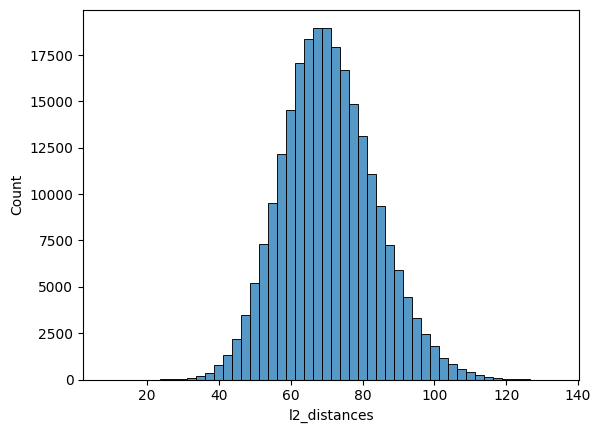

In [29]:
# Distribution of intra-label l2 distances
sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [30]:
# Descriptive statistics for intra-label cosine distances
intra_cos_df.describe()

,cosine_distances
count,242257.000000
mean,0.216930
std,0.088047
min,0.003084
25%,0.152747
50%,0.202114
75%,0.267808
max,0.768703


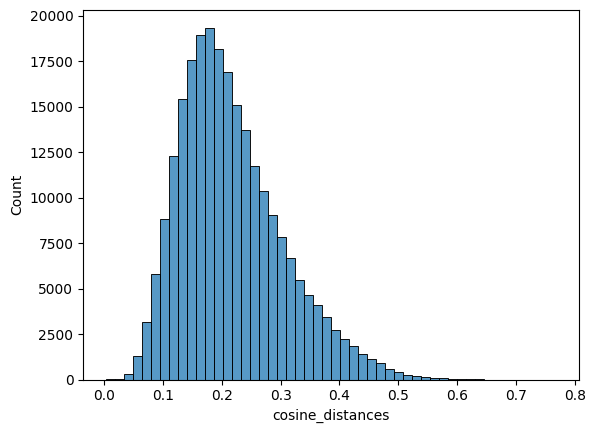

In [31]:
# Distribution of intra-label cosine distances
sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

### Inter-Label Distances for Padded_152

In [20]:
root_path = './data/vectorized/padded_152'
distances_stem = './data/vectorized/padded_152_inter_distances'
vector_leaf = '-pad'

In [ ]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = get_unique_names(root_path)
all_paths, vectors = get_all_paths_and_vectors(root_path)

In [ ]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
calculate_inter_distances(unique_names, all_paths, vectors, distances_stem)

In [35]:
# Grab all paths of inter-label json batches
inter_df_jsons = get_batch_paths(distances_stem, '.json')

In [ ]:
# Process into batch csvs
# This processing was able to be done with 20 GB of memory
write_inter_batch_frames(inter_df_jsons, distances_stem)

In [21]:
# Verifying correct counts for each label
pair_df_counts = confirm_inter_distance_counts(distances_stem, vector_leaf)
pair_df_counts.loc[pair_df_counts.proper_count == False]

,image,counts,correct_counts,proper_count


In [27]:
# Loading l2 distances from batch csvs
inter_l2_df = get_unbatched_frame(distances_stem, 'l2')

In [28]:
# Descriptive statistics for inter-label l2 distances
inter_l2_df.describe()

,l2_distances
count,8.730727e+07
mean,7.683657e+01
std,1.274179e+01
min,0.000000e+00
25%,6.782392e+01
50%,7.592907e+01
75%,8.484721e+01
max,1.823027e+02


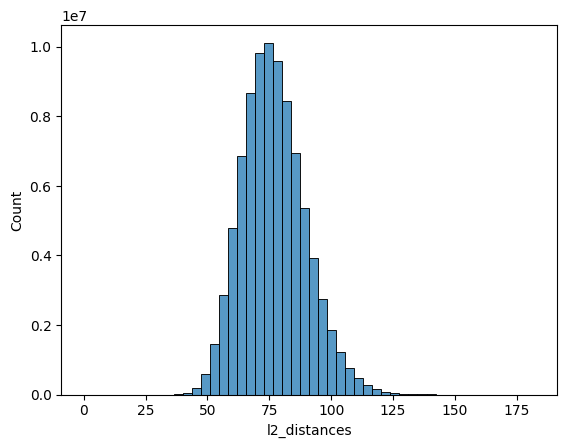

In [29]:
# Distribution of inter-label l2 distances
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [30]:
# Loading cosine distances from batch csvs
inter_cos_df = get_unbatched_frame(distances_stem, 'cos')

In [31]:
# Descriptive statistics for inter-label cosine distances
inter_cos_df.describe()

,cosine_distances
count,8.730727e+07
mean,2.649078e-01
std,9.324491e-02
min,0.000000e+00
25%,1.960075e-01
50%,2.516677e-01
75%,3.210618e-01
max,8.583051e-01


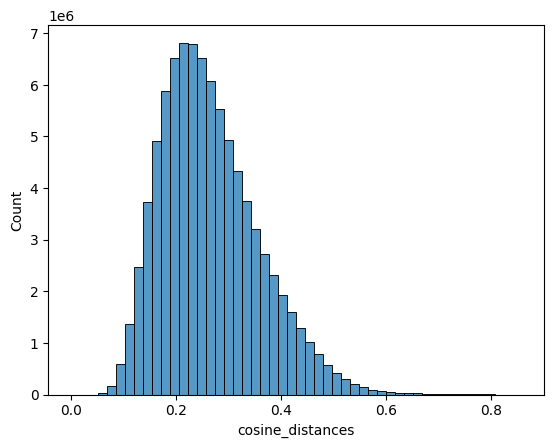

In [32]:
# Distribution of inter-label cosine distances
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

## Intra- and Inter-Distances for Stretched_152

### Intra-Distances for Stretched_152

In [14]:
root_path = './data/vectorized/stretched_152'
json_path = './data/vectorized/stretched_152_intra_distances.json'

In [50]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = get_unique_names(root_path)
all_paths, vectors = get_all_paths_and_vectors(root_path)

In [60]:
# Calculate intra-label distances and write to disk
calculate_intra_distances(unique_names, all_paths, vectors, json_path)

Calculating intra-label distances for AJ_Cook
Only 1 image for AJ_Cook, no intra-label distance exists.
Calculating intra-label distances for AJ_Lamas
Only 1 image for AJ_Lamas, no intra-label distance exists.
Calculating intra-label distances for Aaron_Eckhart
Only 1 image for Aaron_Eckhart, no intra-label distance exists.
Calculating intra-label distances for Aaron_Guiel
Only 1 image for Aaron_Guiel, no intra-label distance exists.
Calculating intra-label distances for Aaron_Patterson
Only 1 image for Aaron_Patterson, no intra-label distance exists.
Calculating intra-label distances for Aaron_Peirsol
Appending inter-label distances for Aaron_Peirsol to dictionary
Calculating intra-label distances for Aaron_Pena
Only 1 image for Aaron_Pena, no intra-label distance exists.
Calculating intra-label distances for Aaron_Sorkin
Appending inter-label distances for Aaron_Sorkin to dictionary
Calculating intra-label distances for Aaron_Tippin
Only 1 image for Aaron_Tippin, no intra-label dista

Only 1 image for Albaro_Recoba, no intra-label distance exists.
Calculating intra-label distances for Albert_Brooks
Only 1 image for Albert_Brooks, no intra-label distance exists.
Calculating intra-label distances for Albert_Costa
Appending inter-label distances for Albert_Costa to dictionary
Calculating intra-label distances for Albert_Montanes
Only 1 image for Albert_Montanes, no intra-label distance exists.
Calculating intra-label distances for Albert_Pujols
Only 1 image for Albert_Pujols, no intra-label distance exists.
Calculating intra-label distances for Alberta_Lee
Only 1 image for Alberta_Lee, no intra-label distance exists.
Calculating intra-label distances for Alberto_Acosta
Only 1 image for Alberto_Acosta, no intra-label distance exists.
Calculating intra-label distances for Alberto_Fujimori
Appending inter-label distances for Alberto_Fujimori to dictionary
Calculating intra-label distances for Alberto_Gonzales
Only 1 image for Alberto_Gonzales, no intra-label distance exis

Appending inter-label distances for Allison_Janney to dictionary
Calculating intra-label distances for Allison_Searing
Only 1 image for Allison_Searing, no intra-label distance exists.
Calculating intra-label distances for Ally_Sheedy
Only 1 image for Ally_Sheedy, no intra-label distance exists.
Calculating intra-label distances for Allyson_Felix
Appending inter-label distances for Allyson_Felix to dictionary
Calculating intra-label distances for Alma_Powell
Only 1 image for Alma_Powell, no intra-label distance exists.
Calculating intra-label distances for Almeida_Baptista
Only 1 image for Almeida_Baptista, no intra-label distance exists.
Calculating intra-label distances for Alonzo_Mourning
Only 1 image for Alonzo_Mourning, no intra-label distance exists.
Calculating intra-label distances for Alvaro_Noboa
Appending inter-label distances for Alvaro_Noboa to dictionary
Calculating intra-label distances for Alvaro_Silva_Calderon
Appending inter-label distances for Alvaro_Silva_Calderon t

Appending inter-label distances for Anibal_Ibarra to dictionary
Calculating intra-label distances for Anil_Ramsook
Only 1 image for Anil_Ramsook, no intra-label distance exists.
Calculating intra-label distances for Anita_DeFrantz
Only 1 image for Anita_DeFrantz, no intra-label distance exists.
Calculating intra-label distances for Anja_Paerson
Only 1 image for Anja_Paerson, no intra-label distance exists.
Calculating intra-label distances for Anjum_Hussain
Only 1 image for Anjum_Hussain, no intra-label distance exists.
Calculating intra-label distances for Ann_Godbehere
Only 1 image for Ann_Godbehere, no intra-label distance exists.
Calculating intra-label distances for Ann_Landers
Only 1 image for Ann_Landers, no intra-label distance exists.
Calculating intra-label distances for Ann_Morgan
Only 1 image for Ann_Morgan, no intra-label distance exists.
Calculating intra-label distances for Ann_Veneman
Appending inter-label distances for Ann_Veneman to dictionary
Calculating intra-label 

Only 1 image for Ashley_Olsen, no intra-label distance exists.
Calculating intra-label distances for Ashley_Postell
Only 1 image for Ashley_Postell, no intra-label distance exists.
Calculating intra-label distances for Ashraf_Alasmar
Only 1 image for Ashraf_Alasmar, no intra-label distance exists.
Calculating intra-label distances for Ashraf_Ghani
Only 1 image for Ashraf_Ghani, no intra-label distance exists.
Calculating intra-label distances for Ashton_Kutcher
Appending inter-label distances for Ashton_Kutcher to dictionary
Calculating intra-label distances for Asif_Ali_Zardari
Only 1 image for Asif_Ali_Zardari, no intra-label distance exists.
Calculating intra-label distances for Asif_Hanif
Only 1 image for Asif_Hanif, no intra-label distance exists.
Calculating intra-label distances for Askar_Akayev
Only 1 image for Askar_Akayev, no intra-label distance exists.
Calculating intra-label distances for Asmaa_Assad
Only 1 image for Asmaa_Assad, no intra-label distance exists.
Calculating

Appending inter-label distances for Bijan_Darvish to dictionary
Calculating intra-label distances for Bijan_Namdar_Zangeneh
Appending inter-label distances for Bijan_Namdar_Zangeneh to dictionary
Calculating intra-label distances for Bilal_Erdogan
Only 1 image for Bilal_Erdogan, no intra-label distance exists.
Calculating intra-label distances for Biljana_Plavsic
Appending inter-label distances for Biljana_Plavsic to dictionary
Calculating intra-label distances for Bill_Belichick
Appending inter-label distances for Bill_Belichick to dictionary
Calculating intra-label distances for Bill_Bradley
Only 1 image for Bill_Bradley, no intra-label distance exists.
Calculating intra-label distances for Bill_Butler
Only 1 image for Bill_Butler, no intra-label distance exists.
Calculating intra-label distances for Bill_Byrne
Only 1 image for Bill_Byrne, no intra-label distance exists.
Calculating intra-label distances for Bill_Callahan
Appending inter-label distances for Bill_Callahan to dictionar

Only 1 image for Boris_Jordan, no intra-label distance exists.
Calculating intra-label distances for Boris_Trajkovski
Only 1 image for Boris_Trajkovski, no intra-label distance exists.
Calculating intra-label distances for Boris_Yeltsin
Appending inter-label distances for Boris_Yeltsin to dictionary
Calculating intra-label distances for Boutros_Boutros_Ghali
Only 1 image for Boutros_Boutros_Ghali, no intra-label distance exists.
Calculating intra-label distances for Brad_Alexander_Smith
Only 1 image for Brad_Alexander_Smith, no intra-label distance exists.
Calculating intra-label distances for Brad_Banks
Only 1 image for Brad_Banks, no intra-label distance exists.
Calculating intra-label distances for Brad_Brownell
Only 1 image for Brad_Brownell, no intra-label distance exists.
Calculating intra-label distances for Brad_Garrett
Appending inter-label distances for Brad_Garrett to dictionary
Calculating intra-label distances for Brad_Gushue
Only 1 image for Brad_Gushue, no intra-label di

Appending inter-label distances for Cameron_Diaz to dictionary
Calculating intra-label distances for Camilla_Parker_Bowles
Appending inter-label distances for Camilla_Parker_Bowles to dictionary
Calculating intra-label distances for Camille_Colvin
Only 1 image for Camille_Colvin, no intra-label distance exists.
Calculating intra-label distances for Camille_Lewis
Only 1 image for Camille_Lewis, no intra-label distance exists.
Calculating intra-label distances for Camryn_Manheim
Only 1 image for Camryn_Manheim, no intra-label distance exists.
Calculating intra-label distances for Candace_Sutton
Only 1 image for Candace_Sutton, no intra-label distance exists.
Calculating intra-label distances for Candice_Beatty
Only 1 image for Candice_Beatty, no intra-label distance exists.
Calculating intra-label distances for Candice_Bergen
Appending inter-label distances for Candice_Bergen to dictionary
Calculating intra-label distances for Candie_Kung
Appending inter-label distances for Candie_Kung t

Only 1 image for Chang_Tso, no intra-label distance exists.
Calculating intra-label distances for Chante_Jawan_Mallard
Only 1 image for Chante_Jawan_Mallard, no intra-label distance exists.
Calculating intra-label distances for Charla_Moye
Only 1 image for Charla_Moye, no intra-label distance exists.
Calculating intra-label distances for Charlene_Barshefsky
Only 1 image for Charlene_Barshefsky, no intra-label distance exists.
Calculating intra-label distances for Charles_Bell
Only 1 image for Charles_Bell, no intra-label distance exists.
Calculating intra-label distances for Charles_Bronson
Appending inter-label distances for Charles_Bronson to dictionary
Calculating intra-label distances for Charles_Chandler_IV
Only 1 image for Charles_Chandler_IV, no intra-label distance exists.
Calculating intra-label distances for Charles_Cope
Only 1 image for Charles_Cope, no intra-label distance exists.
Calculating intra-label distances for Charles_Grassley
Appending inter-label distances for Cha

Appending inter-label distances for Christopher_Patten to dictionary
Calculating intra-label distances for Christopher_Reeve
Appending inter-label distances for Christopher_Reeve to dictionary
Calculating intra-label distances for Christopher_Russell
Only 1 image for Christopher_Russell, no intra-label distance exists.
Calculating intra-label distances for Christopher_Speer
Only 1 image for Christopher_Speer, no intra-label distance exists.
Calculating intra-label distances for Christopher_Walken
Appending inter-label distances for Christopher_Walken to dictionary
Calculating intra-label distances for Christopher_Whittle
Only 1 image for Christopher_Whittle, no intra-label distance exists.
Calculating intra-label distances for Christy_Ferer
Only 1 image for Christy_Ferer, no intra-label distance exists.
Calculating intra-label distances for Christy_Turlington
Only 1 image for Christy_Turlington, no intra-label distance exists.
Calculating intra-label distances for Chuanyun_Li
Only 1 im

Appending inter-label distances for Dalai_Lama to dictionary
Calculating intra-label distances for Dale_Bosworth
Only 1 image for Dale_Bosworth, no intra-label distance exists.
Calculating intra-label distances for Dale_Earnhardt
Only 1 image for Dale_Earnhardt, no intra-label distance exists.
Calculating intra-label distances for Dale_Earnhardt_Jr
Appending inter-label distances for Dale_Earnhardt_Jr to dictionary
Calculating intra-label distances for Dalia_Rabin-Pelosoff
Only 1 image for Dalia_Rabin-Pelosoff, no intra-label distance exists.
Calculating intra-label distances for Damarius_Bilbo
Only 1 image for Damarius_Bilbo, no intra-label distance exists.
Calculating intra-label distances for Damon_Dash
Only 1 image for Damon_Dash, no intra-label distance exists.
Calculating intra-label distances for Damon_Stoudamire
Only 1 image for Damon_Stoudamire, no intra-label distance exists.
Calculating intra-label distances for Damon_van_Dam
Appending inter-label distances for Damon_van_Dam

Only 1 image for David_Dorfman, no intra-label distance exists.
Calculating intra-label distances for David_Duke
Only 1 image for David_Duke, no intra-label distance exists.
Calculating intra-label distances for David_Duval
Only 1 image for David_Duval, no intra-label distance exists.
Calculating intra-label distances for David_Eldon
Only 1 image for David_Eldon, no intra-label distance exists.
Calculating intra-label distances for David_Gest
Only 1 image for David_Gest, no intra-label distance exists.
Calculating intra-label distances for David_Glenn
Only 1 image for David_Glenn, no intra-label distance exists.
Calculating intra-label distances for David_Hannay
Only 1 image for David_Hannay, no intra-label distance exists.
Calculating intra-label distances for David_Hanson
Only 1 image for David_Hanson, no intra-label distance exists.
Calculating intra-label distances for David_Hasselhoff
Only 1 image for David_Hasselhoff, no intra-label distance exists.
Calculating intra-label distan

Appending inter-label distances for Denzel_Washington to dictionary
Calculating intra-label distances for Dereck_Whittenburg
Only 1 image for Dereck_Whittenburg, no intra-label distance exists.
Calculating intra-label distances for Derek_Abney
Only 1 image for Derek_Abney, no intra-label distance exists.
Calculating intra-label distances for Derek_Bond
Only 1 image for Derek_Bond, no intra-label distance exists.
Calculating intra-label distances for Derek_Jeter
Appending inter-label distances for Derek_Jeter to dictionary
Calculating intra-label distances for Derek_King
Only 1 image for Derek_King, no intra-label distance exists.
Calculating intra-label distances for Derek_Lowe
Appending inter-label distances for Derek_Lowe to dictionary
Calculating intra-label distances for Derek_Parra
Only 1 image for Derek_Parra, no intra-label distance exists.
Calculating intra-label distances for Derian_Hatcher
Only 1 image for Derian_Hatcher, no intra-label distance exists.
Calculating intra-labe

Appending inter-label distances for Donald_Rumsfeld to dictionary
Calculating intra-label distances for Donald_Trump
Only 1 image for Donald_Trump, no intra-label distance exists.
Calculating intra-label distances for Donatella_Versace
Appending inter-label distances for Donatella_Versace to dictionary
Calculating intra-label distances for Donna_Barrera
Only 1 image for Donna_Barrera, no intra-label distance exists.
Calculating intra-label distances for Donna_Brazile
Only 1 image for Donna_Brazile, no intra-label distance exists.
Calculating intra-label distances for Donna_Morrissey
Only 1 image for Donna_Morrissey, no intra-label distance exists.
Calculating intra-label distances for Donna_Ralston
Only 1 image for Donna_Ralston, no intra-label distance exists.
Calculating intra-label distances for Donna_Shalala
Appending inter-label distances for Donna_Shalala to dictionary
Calculating intra-label distances for Donna_Walker
Only 1 image for Donna_Walker, no intra-label distance exists

Appending inter-label distances for Eileen_Coparropa to dictionary
Calculating intra-label distances for Eileen_Spina
Only 1 image for Eileen_Spina, no intra-label distance exists.
Calculating intra-label distances for Einars_Repse
Only 1 image for Einars_Repse, no intra-label distance exists.
Calculating intra-label distances for Ekaterina_Dmitriev
Only 1 image for Ekaterina_Dmitriev, no intra-label distance exists.
Calculating intra-label distances for Ekke_Hard_Forberg
Only 1 image for Ekke_Hard_Forberg, no intra-label distance exists.
Calculating intra-label distances for El_Hadji_Diouf
Only 1 image for El_Hadji_Diouf, no intra-label distance exists.
Calculating intra-label distances for Eladio_Larez
Only 1 image for Eladio_Larez, no intra-label distance exists.
Calculating intra-label distances for Elaine_Chao
Only 1 image for Elaine_Chao, no intra-label distance exists.
Calculating intra-label distances for Elaine_Stritch
Only 1 image for Elaine_Stritch, no intra-label distance e

Only 1 image for Eric_Vigouroux, no intra-label distance exists.
Calculating intra-label distances for Eric_Wedge
Only 1 image for Eric_Wedge, no intra-label distance exists.
Calculating intra-label distances for Erick_Barkley
Only 1 image for Erick_Barkley, no intra-label distance exists.
Calculating intra-label distances for Erik_Morales
Appending inter-label distances for Erik_Morales to dictionary
Calculating intra-label distances for Erika_Christensen
Appending inter-label distances for Erika_Christensen to dictionary
Calculating intra-label distances for Erika_Harold
Appending inter-label distances for Erika_Harold to dictionary
Calculating intra-label distances for Erika_Reyes
Only 1 image for Erika_Reyes, no intra-label distance exists.
Calculating intra-label distances for Eriko_Tamura
Only 1 image for Eriko_Tamura, no intra-label distance exists.
Calculating intra-label distances for Erin_Brockovich
Only 1 image for Erin_Brockovich, no intra-label distance exists.
Calculating

Appending inter-label distances for Franco_Dragone to dictionary
Calculating intra-label distances for Franco_Frattini
Only 1 image for Franco_Frattini, no intra-label distance exists.
Calculating intra-label distances for Francois_Botha
Only 1 image for Francois_Botha, no intra-label distance exists.
Calculating intra-label distances for Francois_Ozon
Only 1 image for Francois_Ozon, no intra-label distance exists.
Calculating intra-label distances for Francois_Pienaar
Only 1 image for Francois_Pienaar, no intra-label distance exists.
Calculating intra-label distances for Frank_Abagnale_Jr
Only 1 image for Frank_Abagnale_Jr, no intra-label distance exists.
Calculating intra-label distances for Frank_Beamer
Only 1 image for Frank_Beamer, no intra-label distance exists.
Calculating intra-label distances for Frank_Bell
Only 1 image for Frank_Bell, no intra-label distance exists.
Calculating intra-label distances for Frank_Cassell
Appending inter-label distances for Frank_Cassell to dictio

Only 1 image for George_Allen, no intra-label distance exists.
Calculating intra-label distances for George_Blaney
Only 1 image for George_Blaney, no intra-label distance exists.
Calculating intra-label distances for George_Bovell
Only 1 image for George_Bovell, no intra-label distance exists.
Calculating intra-label distances for George_Brumley
Appending inter-label distances for George_Brumley to dictionary
Calculating intra-label distances for George_Brumley_III
Only 1 image for George_Brumley_III, no intra-label distance exists.
Calculating intra-label distances for George_Clooney
Appending inter-label distances for George_Clooney to dictionary
Calculating intra-label distances for George_Foreman
Appending inter-label distances for George_Foreman to dictionary
Calculating intra-label distances for George_Galloway
Appending inter-label distances for George_Galloway to dictionary
Calculating intra-label distances for George_Gregan
Only 1 image for George_Gregan, no intra-label distan

Only 1 image for Grace_Dodd, no intra-label distance exists.
Calculating intra-label distances for Grace_Kelly
Only 1 image for Grace_Kelly, no intra-label distance exists.
Calculating intra-label distances for Gracia_Burnham
Only 1 image for Gracia_Burnham, no intra-label distance exists.
Calculating intra-label distances for Graciano_Rocchigiani
Only 1 image for Graciano_Rocchigiani, no intra-label distance exists.
Calculating intra-label distances for Grady_Irvin_Jr
Appending inter-label distances for Grady_Irvin_Jr to dictionary
Calculating intra-label distances for Grady_Little
Only 1 image for Grady_Little, no intra-label distance exists.
Calculating intra-label distances for Graeme_Lloyd
Only 1 image for Graeme_Lloyd, no intra-label distance exists.
Calculating intra-label distances for Graeme_Smith
Only 1 image for Graeme_Smith, no intra-label distance exists.
Calculating intra-label distances for Graham_Bentley
Only 1 image for Graham_Bentley, no intra-label distance exists.
C

Only 1 image for Harvey_Wachsman, no intra-label distance exists.
Calculating intra-label distances for Harvey_Weinstein
Appending inter-label distances for Harvey_Weinstein to dictionary
Calculating intra-label distances for Hasan_Wirayuda
Only 1 image for Hasan_Wirayuda, no intra-label distance exists.
Calculating intra-label distances for Hashan_Tillakaratne
Only 1 image for Hashan_Tillakaratne, no intra-label distance exists.
Calculating intra-label distances for Hashim_Thaci
Appending inter-label distances for Hashim_Thaci to dictionary
Calculating intra-label distances for Hassan_Nasrallah
Appending inter-label distances for Hassan_Nasrallah to dictionary
Calculating intra-label distances for Hassan_Wirajuda
Appending inter-label distances for Hassan_Wirajuda to dictionary
Calculating intra-label distances for Hassanal_Bolkiah
Only 1 image for Hassanal_Bolkiah, no intra-label distance exists.
Calculating intra-label distances for Hatsui_Hasuike
Only 1 image for Hatsui_Hasuike, no

Appending inter-label distances for Hugo_Chavez to dictionary
Calculating intra-label distances for Hugo_Colace
Only 1 image for Hugo_Colace, no intra-label distance exists.
Calculating intra-label distances for Hugo_Conte
Only 1 image for Hugo_Conte, no intra-label distance exists.
Calculating intra-label distances for Humberto_Coelho
Only 1 image for Humberto_Coelho, no intra-label distance exists.
Calculating intra-label distances for Humberto_Espinoza
Only 1 image for Humberto_Espinoza, no intra-label distance exists.
Calculating intra-label distances for Hun_Sen
Appending inter-label distances for Hun_Sen to dictionary
Calculating intra-label distances for Hung_Wan-ting
Only 1 image for Hung_Wan-ting, no intra-label distance exists.
Calculating intra-label distances for Hunter_Bates
Only 1 image for Hunter_Bates, no intra-label distance exists.
Calculating intra-label distances for Hunter_Kemper
Only 1 image for Hunter_Kemper, no intra-label distance exists.
Calculating intra-labe

Appending inter-label distances for Jacques_Chirac to dictionary
Calculating intra-label distances for Jacques_Kallis
Only 1 image for Jacques_Kallis, no intra-label distance exists.
Calculating intra-label distances for Jacques_Rogge
Appending inter-label distances for Jacques_Rogge to dictionary
Calculating intra-label distances for Jacques_Villeneuve
Only 1 image for Jacques_Villeneuve, no intra-label distance exists.
Calculating intra-label distances for Jada_Pinkett_Smith
Appending inter-label distances for Jada_Pinkett_Smith to dictionary
Calculating intra-label distances for Jade_Jagger
Only 1 image for Jade_Jagger, no intra-label distance exists.
Calculating intra-label distances for Jafar_Umar_Thalib
Only 1 image for Jafar_Umar_Thalib, no intra-label distance exists.
Calculating intra-label distances for Jaime_Orti
Only 1 image for Jaime_Orti, no intra-label distance exists.
Calculating intra-label distances for Jaime_Pressly
Only 1 image for Jaime_Pressly, no intra-label dist

Only 1 image for Janice_Goldfinger, no intra-label distance exists.
Calculating intra-label distances for Janine_Pietsch
Only 1 image for Janine_Pietsch, no intra-label distance exists.
Calculating intra-label distances for Janis_Ruth_Coulter
Only 1 image for Janis_Ruth_Coulter, no intra-label distance exists.
Calculating intra-label distances for Janusz_Kaminski
Only 1 image for Janusz_Kaminski, no intra-label distance exists.
Calculating intra-label distances for Jaouad_Gharib
Only 1 image for Jaouad_Gharib, no intra-label distance exists.
Calculating intra-label distances for Jaqueline_Godoy
Only 1 image for Jaqueline_Godoy, no intra-label distance exists.
Calculating intra-label distances for Jaromir_Jagr
Only 1 image for Jaromir_Jagr, no intra-label distance exists.
Calculating intra-label distances for Jason_Alexander
Appending inter-label distances for Jason_Alexander to dictionary
Calculating intra-label distances for Jason_Bentley
Only 1 image for Jason_Bentley, no intra-label

Appending inter-label distances for Jennifer_Keller to dictionary
Calculating intra-label distances for Jennifer_Lopez
Appending inter-label distances for Jennifer_Lopez to dictionary
Calculating intra-label distances for Jennifer_Love_Hewitt
Only 1 image for Jennifer_Love_Hewitt, no intra-label distance exists.
Calculating intra-label distances for Jennifer_McCoy
Only 1 image for Jennifer_McCoy, no intra-label distance exists.
Calculating intra-label distances for Jennifer_Murray
Only 1 image for Jennifer_Murray, no intra-label distance exists.
Calculating intra-label distances for Jennifer_Pena
Only 1 image for Jennifer_Pena, no intra-label distance exists.
Calculating intra-label distances for Jennifer_Reilly
Appending inter-label distances for Jennifer_Reilly to dictionary
Calculating intra-label distances for Jennifer_Renee_Short
Only 1 image for Jennifer_Renee_Short, no intra-label distance exists.
Calculating intra-label distances for Jennifer_Rodriguez
Appending inter-label dis

Only 1 image for Joaquin_Phoenix, no intra-label distance exists.
Calculating intra-label distances for Joaquin_Sanchez
Only 1 image for Joaquin_Sanchez, no intra-label distance exists.
Calculating intra-label distances for Job_Cohen
Appending inter-label distances for Job_Cohen to dictionary
Calculating intra-label distances for Jodie_Foster
Appending inter-label distances for Jodie_Foster to dictionary
Calculating intra-label distances for Jodie_Henry
Only 1 image for Jodie_Henry, no intra-label distance exists.
Calculating intra-label distances for Jodie_Kidd
Only 1 image for Jodie_Kidd, no intra-label distance exists.
Calculating intra-label distances for Jody_Richards
Only 1 image for Jody_Richards, no intra-label distance exists.
Calculating intra-label distances for Joe_Calzaghe
Appending inter-label distances for Joe_Calzaghe to dictionary
Calculating intra-label distances for Joe_Carnahan
Only 1 image for Joe_Carnahan, no intra-label distance exists.
Calculating intra-label di

Appending inter-label distances for John_Negroponte to dictionary
Calculating intra-label distances for John_Nimmo
Only 1 image for John_Nimmo, no intra-label distance exists.
Calculating intra-label distances for John_Norquist
Only 1 image for John_Norquist, no intra-label distance exists.
Calculating intra-label distances for John_Paul_DeJoria
Only 1 image for John_Paul_DeJoria, no intra-label distance exists.
Calculating intra-label distances for John_Paul_II
Appending inter-label distances for John_Paul_II to dictionary
Calculating intra-label distances for John_Perrota
Only 1 image for John_Perrota, no intra-label distance exists.
Calculating intra-label distances for John_Petty
Only 1 image for John_Petty, no intra-label distance exists.
Calculating intra-label distances for John_Philip_Elkann
Only 1 image for John_Philip_Elkann, no intra-label distance exists.
Calculating intra-label distances for John_Prescott
Only 1 image for John_Prescott, no intra-label distance exists.
Calc

Only 1 image for Joseph_Ganim, no intra-label distance exists.
Calculating intra-label distances for Joseph_Hoy
Only 1 image for Joseph_Hoy, no intra-label distance exists.
Calculating intra-label distances for Joseph_Kabila
Only 1 image for Joseph_Kabila, no intra-label distance exists.
Calculating intra-label distances for Joseph_LePore
Only 1 image for Joseph_LePore, no intra-label distance exists.
Calculating intra-label distances for Joseph_Lopez
Only 1 image for Joseph_Lopez, no intra-label distance exists.
Calculating intra-label distances for Joseph_Nacchio
Only 1 image for Joseph_Nacchio, no intra-label distance exists.
Calculating intra-label distances for Joseph_Ralston
Appending inter-label distances for Joseph_Ralston to dictionary
Calculating intra-label distances for Joseph_Safra
Only 1 image for Joseph_Safra, no intra-label distance exists.
Calculating intra-label distances for Joseph_Salgado
Only 1 image for Joseph_Salgado, no intra-label distance exists.
Calculating i

Only 1 image for Karol_Kucera, no intra-label distance exists.
Calculating intra-label distances for Kaspar_Villiger
Only 1 image for Kaspar_Villiger, no intra-label distance exists.
Calculating intra-label distances for Katalin_Kollat
Only 1 image for Katalin_Kollat, no intra-label distance exists.
Calculating intra-label distances for Kate_Burton
Only 1 image for Kate_Burton, no intra-label distance exists.
Calculating intra-label distances for Kate_Capshaw
Appending inter-label distances for Kate_Capshaw to dictionary
Calculating intra-label distances for Kate_Hudson
Appending inter-label distances for Kate_Hudson to dictionary
Calculating intra-label distances for Kate_Lee
Only 1 image for Kate_Lee, no intra-label distance exists.
Calculating intra-label distances for Kate_Moss
Only 1 image for Kate_Moss, no intra-label distance exists.
Calculating intra-label distances for Kate_Richardson
Only 1 image for Kate_Richardson, no intra-label distance exists.
Calculating intra-label dis

Appending inter-label distances for Kim_Clijsters to dictionary
Calculating intra-label distances for Kim_Dae-jung
Appending inter-label distances for Kim_Dae-jung to dictionary
Calculating intra-label distances for Kim_Dong-hwa
Only 1 image for Kim_Dong-hwa, no intra-label distance exists.
Calculating intra-label distances for Kim_Dong-tae
Only 1 image for Kim_Dong-tae, no intra-label distance exists.
Calculating intra-label distances for Kim_Gandy
Only 1 image for Kim_Gandy, no intra-label distance exists.
Calculating intra-label distances for Kim_Hong-gul
Only 1 image for Kim_Hong-gul, no intra-label distance exists.
Calculating intra-label distances for Kim_Hong-up
Only 1 image for Kim_Hong-up, no intra-label distance exists.
Calculating intra-label distances for Kim_Jin-sun
Appending inter-label distances for Kim_Jin-sun to dictionary
Calculating intra-label distances for Kim_Jong-Il
Appending inter-label distances for Kim_Jong-Il to dictionary
Calculating intra-label distances fo

Appending inter-label distances for Lars_Von_Trier to dictionary
Calculating intra-label distances for Laszlo_Kovacs
Only 1 image for Laszlo_Kovacs, no intra-label distance exists.
Calculating intra-label distances for Latrell_Sprewell
Appending inter-label distances for Latrell_Sprewell to dictionary
Calculating intra-label distances for Laura_Bozzo
Only 1 image for Laura_Bozzo, no intra-label distance exists.
Calculating intra-label distances for Laura_Bush
Appending inter-label distances for Laura_Bush to dictionary
Calculating intra-label distances for Laura_Elena_Harring
Only 1 image for Laura_Elena_Harring, no intra-label distance exists.
Calculating intra-label distances for Laura_Flessel
Only 1 image for Laura_Flessel, no intra-label distance exists.
Calculating intra-label distances for Laura_Gobai
Only 1 image for Laura_Gobai, no intra-label distance exists.
Calculating intra-label distances for Laura_Hernandez
Appending inter-label distances for Laura_Hernandez to dictionary

Only 1 image for Linn_Thornton, no intra-label distance exists.
Calculating intra-label distances for Lino_Oviedo
Appending inter-label distances for Lino_Oviedo to dictionary
Calculating intra-label distances for Linus_Roache
Only 1 image for Linus_Roache, no intra-label distance exists.
Calculating intra-label distances for Lionel_Chalmers
Only 1 image for Lionel_Chalmers, no intra-label distance exists.
Calculating intra-label distances for Lionel_Hampton
Only 1 image for Lionel_Hampton, no intra-label distance exists.
Calculating intra-label distances for Lionel_Richie
Appending inter-label distances for Lionel_Richie to dictionary
Calculating intra-label distances for Lisa_Girman
Only 1 image for Lisa_Girman, no intra-label distance exists.
Calculating intra-label distances for Lisa_Gottsegen
Appending inter-label distances for Lisa_Gottsegen to dictionary
Calculating intra-label distances for Lisa_Leslie
Only 1 image for Lisa_Leslie, no intra-label distance exists.
Calculating in

Only 1 image for Mamdouh_Habib, no intra-label distance exists.
Calculating intra-label distances for Manfred_Reyes_Villa
Only 1 image for Manfred_Reyes_Villa, no intra-label distance exists.
Calculating intra-label distances for Manfred_Stolpe
Appending inter-label distances for Manfred_Stolpe to dictionary
Calculating intra-label distances for Manijeh_Hekmat
Only 1 image for Manijeh_Hekmat, no intra-label distance exists.
Calculating intra-label distances for Manuel_Gehring
Only 1 image for Manuel_Gehring, no intra-label distance exists.
Calculating intra-label distances for Manuel_Jesus
Only 1 image for Manuel_Jesus, no intra-label distance exists.
Calculating intra-label distances for Manuel_Llorente
Only 1 image for Manuel_Llorente, no intra-label distance exists.
Calculating intra-label distances for Manuel_Pellegrini
Only 1 image for Manuel_Pellegrini, no intra-label distance exists.
Calculating intra-label distances for Manuel_Poggiali
Appending inter-label distances for Manuel

Appending inter-label distances for Mark_Philippoussis to dictionary
Calculating intra-label distances for Mark_Podlesny
Only 1 image for Mark_Podlesny, no intra-label distance exists.
Calculating intra-label distances for Mark_Polansky
Only 1 image for Mark_Polansky, no intra-label distance exists.
Calculating intra-label distances for Mark_Redman
Only 1 image for Mark_Redman, no intra-label distance exists.
Calculating intra-label distances for Mark_Richt
Appending inter-label distances for Mark_Richt to dictionary
Calculating intra-label distances for Mark_Rosenbaum
Only 1 image for Mark_Rosenbaum, no intra-label distance exists.
Calculating intra-label distances for Mark_Sacco
Only 1 image for Mark_Sacco, no intra-label distance exists.
Calculating intra-label distances for Mark_Salter
Only 1 image for Mark_Salter, no intra-label distance exists.
Calculating intra-label distances for Mark_Schweiker
Appending inter-label distances for Mark_Schweiker to dictionary
Calculating intra-l

Appending inter-label distances for Matthew_Perry to dictionary
Calculating intra-label distances for Matthew_Vaughan
Only 1 image for Matthew_Vaughan, no intra-label distance exists.
Calculating intra-label distances for Matthias_Sammer
Only 1 image for Matthias_Sammer, no intra-label distance exists.
Calculating intra-label distances for Maura_Tierney
Only 1 image for Maura_Tierney, no intra-label distance exists.
Calculating intra-label distances for Maureen_Fanning
Appending inter-label distances for Maureen_Fanning to dictionary
Calculating intra-label distances for Maureen_Kanka
Only 1 image for Maureen_Kanka, no intra-label distance exists.
Calculating intra-label distances for Maurice_Cheeks
Only 1 image for Maurice_Cheeks, no intra-label distance exists.
Calculating intra-label distances for Maurice_Papon
Only 1 image for Maurice_Papon, no intra-label distance exists.
Calculating intra-label distances for Maurice_Strong
Only 1 image for Maurice_Strong, no intra-label distance 

Only 1 image for Michael_Pfleger, no intra-label distance exists.
Calculating intra-label distances for Michael_Phelps
Appending inter-label distances for Michael_Phelps to dictionary
Calculating intra-label distances for Michael_Piuze
Only 1 image for Michael_Piuze, no intra-label distance exists.
Calculating intra-label distances for Michael_Powell
Appending inter-label distances for Michael_Powell to dictionary
Calculating intra-label distances for Michael_Richards
Only 1 image for Michael_Richards, no intra-label distance exists.
Calculating intra-label distances for Michael_Rolinee
Only 1 image for Michael_Rolinee, no intra-label distance exists.
Calculating intra-label distances for Michael_Schumacher
Appending inter-label distances for Michael_Schumacher to dictionary
Calculating intra-label distances for Michael_Shane_Jolly
Only 1 image for Michael_Shane_Jolly, no intra-label distance exists.
Calculating intra-label distances for Michael_Sheehan
Only 1 image for Michael_Sheehan

Only 1 image for Milton_Berle, no intra-label distance exists.
Calculating intra-label distances for Milton_Wynants
Only 1 image for Milton_Wynants, no intra-label distance exists.
Calculating intra-label distances for Minnie_Driver
Appending inter-label distances for Minnie_Driver to dictionary
Calculating intra-label distances for Minnie_Mendoza
Only 1 image for Minnie_Mendoza, no intra-label distance exists.
Calculating intra-label distances for Mira_Sorvino
Only 1 image for Mira_Sorvino, no intra-label distance exists.
Calculating intra-label distances for Miranda_Gaddis
Only 1 image for Miranda_Gaddis, no intra-label distance exists.
Calculating intra-label distances for Miranda_Otto
Only 1 image for Miranda_Otto, no intra-label distance exists.
Calculating intra-label distances for Mireille_Jospin-Dandieu
Only 1 image for Mireille_Jospin-Dandieu, no intra-label distance exists.
Calculating intra-label distances for Mirela_Manjani
Only 1 image for Mirela_Manjani, no intra-label di

Only 1 image for Mufti_Mohammad_Syed, no intra-label distance exists.
Calculating intra-label distances for Muhammad_Ali
Appending inter-label distances for Muhammad_Ali to dictionary
Calculating intra-label distances for Muhammad_Ibrahim_Bilal
Only 1 image for Muhammad_Ibrahim_Bilal, no intra-label distance exists.
Calculating intra-label distances for Muhammad_Saeed_al-Sahhaf
Appending inter-label distances for Muhammad_Saeed_al-Sahhaf to dictionary
Calculating intra-label distances for Mukesh_Ambani
Appending inter-label distances for Mukesh_Ambani to dictionary
Calculating intra-label distances for Mukhtar_Alytnbayev
Only 1 image for Mukhtar_Alytnbayev, no intra-label distance exists.
Calculating intra-label distances for Munir_Akram
Appending inter-label distances for Munir_Akram to dictionary
Calculating intra-label distances for Muwafak_al-Ani
Only 1 image for Muwafak_al-Ani, no intra-label distance exists.
Calculating intra-label distances for Myung_Yang
Only 1 image for Myung_

Appending inter-label distances for Nestor_Kirchner to dictionary
Calculating intra-label distances for Nestor_Santillan
Only 1 image for Nestor_Santillan, no intra-label distance exists.
Calculating intra-label distances for Newt_Gingrich
Only 1 image for Newt_Gingrich, no intra-label distance exists.
Calculating intra-label distances for Newton_Carlton_Slawson
Only 1 image for Newton_Carlton_Slawson, no intra-label distance exists.
Calculating intra-label distances for Nia_Vardalos
Appending inter-label distances for Nia_Vardalos to dictionary
Calculating intra-label distances for Niall_Connolly
Only 1 image for Niall_Connolly, no intra-label distance exists.
Calculating intra-label distances for Nicanor_Duarte_Frutos
Appending inter-label distances for Nicanor_Duarte_Frutos to dictionary
Calculating intra-label distances for Nicholas_Byron
Appending inter-label distances for Nicholas_Byron to dictionary
Calculating intra-label distances for Nicholas_Tse
Appending inter-label distanc

Appending inter-label distances for Ozzy_Osbourne to dictionary
Calculating intra-label distances for Pa_Kou_Hang
Only 1 image for Pa_Kou_Hang, no intra-label distance exists.
Calculating intra-label distances for Pablo_Khulental
Only 1 image for Pablo_Khulental, no intra-label distance exists.
Calculating intra-label distances for Pablo_Latras
Only 1 image for Pablo_Latras, no intra-label distance exists.
Calculating intra-label distances for Paddy_Long
Only 1 image for Paddy_Long, no intra-label distance exists.
Calculating intra-label distances for Paddy_Torsney
Only 1 image for Paddy_Torsney, no intra-label distance exists.
Calculating intra-label distances for Padraig_Harrington
Appending inter-label distances for Padraig_Harrington to dictionary
Calculating intra-label distances for Paek_Nam_Sun
Only 1 image for Paek_Nam_Sun, no intra-label distance exists.
Calculating intra-label distances for Paige_Fitzgerald
Only 1 image for Paige_Fitzgerald, no intra-label distance exists.
Ca

Only 1 image for Paul_Li_Calsi, no intra-label distance exists.
Calculating intra-label distances for Paul_Lo_Duca
Only 1 image for Paul_Lo_Duca, no intra-label distance exists.
Calculating intra-label distances for Paul_Lockhart
Only 1 image for Paul_Lockhart, no intra-label distance exists.
Calculating intra-label distances for Paul_Luvera
Only 1 image for Paul_Luvera, no intra-label distance exists.
Calculating intra-label distances for Paul_Martin
Appending inter-label distances for Paul_Martin to dictionary
Calculating intra-label distances for Paul_McCartney
Appending inter-label distances for Paul_McCartney to dictionary
Calculating intra-label distances for Paul_McNulty
Appending inter-label distances for Paul_McNulty to dictionary
Calculating intra-label distances for Paul_Michael_Daniels
Only 1 image for Paul_Michael_Daniels, no intra-label distance exists.
Calculating intra-label distances for Paul_Murphy
Only 1 image for Paul_Murphy, no intra-label distance exists.
Calculat

Appending inter-label distances for Peter_Costello to dictionary
Calculating intra-label distances for Peter_Fisher
Only 1 image for Peter_Fisher, no intra-label distance exists.
Calculating intra-label distances for Peter_Fitzgerald
Only 1 image for Peter_Fitzgerald, no intra-label distance exists.
Calculating intra-label distances for Peter_Fonda
Only 1 image for Peter_Fonda, no intra-label distance exists.
Calculating intra-label distances for Peter_Gabriel
Only 1 image for Peter_Gabriel, no intra-label distance exists.
Calculating intra-label distances for Peter_Gilmour
Only 1 image for Peter_Gilmour, no intra-label distance exists.
Calculating intra-label distances for Peter_Goldmark
Only 1 image for Peter_Goldmark, no intra-label distance exists.
Calculating intra-label distances for Peter_Greenaway
Appending inter-label distances for Peter_Greenaway to dictionary
Calculating intra-label distances for Peter_Greenspun
Only 1 image for Peter_Greenspun, no intra-label distance exist

Only 1 image for Qazi_Afzal, no intra-label distance exists.
Calculating intra-label distances for Qazi_Hussain_Ahmed
Only 1 image for Qazi_Hussain_Ahmed, no intra-label distance exists.
Calculating intra-label distances for Qian_Qichen
Only 1 image for Qian_Qichen, no intra-label distance exists.
Calculating intra-label distances for Queen_Beatrix
Appending inter-label distances for Queen_Beatrix to dictionary
Calculating intra-label distances for Queen_Elizabeth_II
Appending inter-label distances for Queen_Elizabeth_II to dictionary
Calculating intra-label distances for Queen_Latifah
Appending inter-label distances for Queen_Latifah to dictionary
Calculating intra-label distances for Queen_Noor
Only 1 image for Queen_Noor, no intra-label distance exists.
Calculating intra-label distances for Queen_Rania
Appending inter-label distances for Queen_Rania to dictionary
Calculating intra-label distances for Queen_Silvia
Only 1 image for Queen_Silvia, no intra-label distance exists.
Calcula

Only 1 image for Reyyan_Uzuner, no intra-label distance exists.
Calculating intra-label distances for Rhett_Warrener
Only 1 image for Rhett_Warrener, no intra-label distance exists.
Calculating intra-label distances for Rhina_Villatoro
Only 1 image for Rhina_Villatoro, no intra-label distance exists.
Calculating intra-label distances for Ricardo_Lagos
Appending inter-label distances for Ricardo_Lagos to dictionary
Calculating intra-label distances for Ricardo_Lopez_Murphy
Appending inter-label distances for Ricardo_Lopez_Murphy to dictionary
Calculating intra-label distances for Ricardo_Maduro
Appending inter-label distances for Ricardo_Maduro to dictionary
Calculating intra-label distances for Ricardo_Mayorga
Only 1 image for Ricardo_Mayorga, no intra-label distance exists.
Calculating intra-label distances for Ricardo_Monasterio
Appending inter-label distances for Ricardo_Monasterio to dictionary
Calculating intra-label distances for Ricardo_Sanchez
Appending inter-label distances fo

Appending inter-label distances for Rita_Wilson to dictionary
Calculating intra-label distances for Rob_Lowe
Appending inter-label distances for Rob_Lowe to dictionary
Calculating intra-label distances for Rob_Marshall
Appending inter-label distances for Rob_Marshall to dictionary
Calculating intra-label distances for Rob_Moore
Only 1 image for Rob_Moore, no intra-label distance exists.
Calculating intra-label distances for Rob_Morrow
Only 1 image for Rob_Morrow, no intra-label distance exists.
Calculating intra-label distances for Rob_Niedermayer
Only 1 image for Rob_Niedermayer, no intra-label distance exists.
Calculating intra-label distances for Rob_Ramsay
Only 1 image for Rob_Ramsay, no intra-label distance exists.
Calculating intra-label distances for Rob_Schneider
Appending inter-label distances for Rob_Schneider to dictionary
Calculating intra-label distances for Robbie_Coltrane
Only 1 image for Robbie_Coltrane, no intra-label distance exists.
Calculating intra-label distances 

Only 1 image for Roel_Campos, no intra-label distance exists.
Calculating intra-label distances for Rogelio_Montemayor
Only 1 image for Rogelio_Montemayor, no intra-label distance exists.
Calculating intra-label distances for Rogelio_Ramos
Only 1 image for Rogelio_Ramos, no intra-label distance exists.
Calculating intra-label distances for Roger_Clemens
Appending inter-label distances for Roger_Clemens to dictionary
Calculating intra-label distances for Roger_Cook
Only 1 image for Roger_Cook, no intra-label distance exists.
Calculating intra-label distances for Roger_Corbett
Only 1 image for Roger_Corbett, no intra-label distance exists.
Calculating intra-label distances for Roger_Daltrey
Only 1 image for Roger_Daltrey, no intra-label distance exists.
Calculating intra-label distances for Roger_Etchegaray
Only 1 image for Roger_Etchegaray, no intra-label distance exists.
Calculating intra-label distances for Roger_Federer
Appending inter-label distances for Roger_Federer to dictionary


Only 1 image for Sada_Jacobson, no intra-label distance exists.
Calculating intra-label distances for Sadam_Hassan
Only 1 image for Sadam_Hassan, no intra-label distance exists.
Calculating intra-label distances for Saddam_Hussein
Appending inter-label distances for Saddam_Hussein to dictionary
Calculating intra-label distances for Sadie_Frost
Appending inter-label distances for Sadie_Frost to dictionary
Calculating intra-label distances for Saeb_Erekat
Appending inter-label distances for Saeb_Erekat to dictionary
Calculating intra-label distances for Saeed_Anwar
Only 1 image for Saeed_Anwar, no intra-label distance exists.
Calculating intra-label distances for Saeed_Mortazavi
Only 1 image for Saeed_Mortazavi, no intra-label distance exists.
Calculating intra-label distances for Sahim_Alwan
Only 1 image for Sahim_Alwan, no intra-label distance exists.
Calculating intra-label distances for Saied_Hadi_al_Mudarissi
Only 1 image for Saied_Hadi_al_Mudarissi, no intra-label distance exists.


Appending inter-label distances for Serena_Williams to dictionary
Calculating intra-label distances for Sereyvuth_Kem
Only 1 image for Sereyvuth_Kem, no intra-label distance exists.
Calculating intra-label distances for Serge_Klarsfeld
Only 1 image for Serge_Klarsfeld, no intra-label distance exists.
Calculating intra-label distances for Serge_Melac
Only 1 image for Serge_Melac, no intra-label distance exists.
Calculating intra-label distances for Serge_Tchuruk
Only 1 image for Serge_Tchuruk, no intra-label distance exists.
Calculating intra-label distances for Sergei_Alexandrovitch_Ordzhonikidze
Only 1 image for Sergei_Alexandrovitch_Ordzhonikidze, no intra-label distance exists.
Calculating intra-label distances for Sergei_Ivanov
Appending inter-label distances for Sergei_Ivanov to dictionary
Calculating intra-label distances for Sergei_Yastrzhembsky
Only 1 image for Sergei_Yastrzhembsky, no intra-label distance exists.
Calculating intra-label distances for Sergei_Yushenkov
Only 1 im

Only 1 image for Sohail_Abbas, no intra-label distance exists.
Calculating intra-label distances for Sok_An
Only 1 image for Sok_An, no intra-label distance exists.
Calculating intra-label distances for Solomon_Passy
Only 1 image for Solomon_Passy, no intra-label distance exists.
Calculating intra-label distances for Sonia_Gandhi
Appending inter-label distances for Sonia_Gandhi to dictionary
Calculating intra-label distances for Sonia_Lopez
Only 1 image for Sonia_Lopez, no intra-label distance exists.
Calculating intra-label distances for Sonja_Kesselschlager
Only 1 image for Sonja_Kesselschlager, no intra-label distance exists.
Calculating intra-label distances for Sonya_Walger
Only 1 image for Sonya_Walger, no intra-label distance exists.
Calculating intra-label distances for Soon_Yi
Only 1 image for Soon_Yi, no intra-label distance exists.
Calculating intra-label distances for Sophia_Loren
Appending inter-label distances for Sophia_Loren to dictionary
Calculating intra-label distanc

Only 1 image for Steve_Peace, no intra-label distance exists.
Calculating intra-label distances for Steve_Phillips
Only 1 image for Steve_Phillips, no intra-label distance exists.
Calculating intra-label distances for Steve_Redgrave
Only 1 image for Steve_Redgrave, no intra-label distance exists.
Calculating intra-label distances for Steve_Rush
Only 1 image for Steve_Rush, no intra-label distance exists.
Calculating intra-label distances for Steve_Shiver
Only 1 image for Steve_Shiver, no intra-label distance exists.
Calculating intra-label distances for Steve_Spurrier
Appending inter-label distances for Steve_Spurrier to dictionary
Calculating intra-label distances for Steve_Stirling
Only 1 image for Steve_Stirling, no intra-label distance exists.
Calculating intra-label distances for Steve_Valentine
Only 1 image for Steve_Valentine, no intra-label distance exists.
Calculating intra-label distances for Steve_Wariner
Only 1 image for Steve_Wariner, no intra-label distance exists.
Calcul

Only 1 image for Ted_Costa, no intra-label distance exists.
Calculating intra-label distances for Ted_Maher
Appending inter-label distances for Ted_Maher to dictionary
Calculating intra-label distances for Ted_Nolan
Only 1 image for Ted_Nolan, no intra-label distance exists.
Calculating intra-label distances for Ted_Turner
Only 1 image for Ted_Turner, no intra-label distance exists.
Calculating intra-label distances for Ted_Washington
Only 1 image for Ted_Washington, no intra-label distance exists.
Calculating intra-label distances for Ted_Williams
Only 1 image for Ted_Williams, no intra-label distance exists.
Calculating intra-label distances for Teddy_Kollek
Only 1 image for Teddy_Kollek, no intra-label distance exists.
Calculating intra-label distances for Terence_Newman
Only 1 image for Terence_Newman, no intra-label distance exists.
Calculating intra-label distances for Teresa_Graves
Only 1 image for Teresa_Graves, no intra-label distance exists.
Calculating intra-label distances 

Only 1 image for Tom_Amstutz, no intra-label distance exists.
Calculating intra-label distances for Tom_Brady
Appending inter-label distances for Tom_Brady to dictionary
Calculating intra-label distances for Tom_Brennan
Only 1 image for Tom_Brennan, no intra-label distance exists.
Calculating intra-label distances for Tom_Christerson
Only 1 image for Tom_Christerson, no intra-label distance exists.
Calculating intra-label distances for Tom_Coughlin
Only 1 image for Tom_Coughlin, no intra-label distance exists.
Calculating intra-label distances for Tom_Coverdale
Appending inter-label distances for Tom_Coverdale to dictionary
Calculating intra-label distances for Tom_Craddick
Appending inter-label distances for Tom_Craddick to dictionary
Calculating intra-label distances for Tom_Crean
Appending inter-label distances for Tom_Crean to dictionary
Calculating intra-label distances for Tom_Cruise
Appending inter-label distances for Tom_Cruise to dictionary
Calculating intra-label distances fo

Appending inter-label distances for Valery_Giscard_dEstaing to dictionary
Calculating intra-label distances for Valorie_Brabazon
Only 1 image for Valorie_Brabazon, no intra-label distance exists.
Calculating intra-label distances for Van_Hilley
Only 1 image for Van_Hilley, no intra-label distance exists.
Calculating intra-label distances for Vanessa_Incontrada
Appending inter-label distances for Vanessa_Incontrada to dictionary
Calculating intra-label distances for Vanessa_Laine
Only 1 image for Vanessa_Laine, no intra-label distance exists.
Calculating intra-label distances for Vanessa_Redgrave
Appending inter-label distances for Vanessa_Redgrave to dictionary
Calculating intra-label distances for Vanessa_Williams
Appending inter-label distances for Vanessa_Williams to dictionary
Calculating intra-label distances for Vassilis_Xiros
Only 1 image for Vassilis_Xiros, no intra-label distance exists.
Calculating intra-label distances for Vecdi_Gonul
Only 1 image for Vecdi_Gonul, no intra-l

Appending inter-label distances for William_Macy to dictionary
Calculating intra-label distances for William_Martin
Appending inter-label distances for William_Martin to dictionary
Calculating intra-label distances for William_McDonough
Only 1 image for William_McDonough, no intra-label distance exists.
Calculating intra-label distances for William_Morrow
Only 1 image for William_Morrow, no intra-label distance exists.
Calculating intra-label distances for William_Murabito
Only 1 image for William_Murabito, no intra-label distance exists.
Calculating intra-label distances for William_Nessen
Only 1 image for William_Nessen, no intra-label distance exists.
Calculating intra-label distances for William_Overlin
Only 1 image for William_Overlin, no intra-label distance exists.
Calculating intra-label distances for William_Perry
Only 1 image for William_Perry, no intra-label distance exists.
Calculating intra-label distances for William_Pryor_Jr
Only 1 image for William_Pryor_Jr, no intra-la

In [15]:
# Read intra-label distances from disk and place into dataframe
intra_df = load_json_into_frame(json_path)

In [16]:
# Verifying correct counts for each label
all_paths = get_all_paths(root_path)
intra_df_counts = confirm_intra_distance_counts(intra_df, all_paths)
intra_df_counts.loc[intra_df_counts.proper_count == False]

,name,counts,correct_counts,proper_count


In [17]:
# Writing intra-label l2 distances to separate csv for further use
l2_csv_path = './data/vectorized/stretched_152_intra_distances_l2.csv'
intra_l2_df = get_distance_df(intra_df, 'l2_distances')
intra_l2_df.to_csv(l2_csv_path, index = False)

In [18]:
# Writing intra-label cosine distances to separate csv for further use
cos_csv_path = './data/vectorized/stretched_152_intra_distances_cos.csv'
intra_cos_df = get_distance_df(intra_df, 'cosine_distances')
intra_cos_df.to_csv(cos_csv_path, index = False)

In [19]:
# Descriptive statistics for intra-label l2 distances
intra_l2_df.describe()

,l2_distances
count,242257.000000
mean,90.819415
std,12.777496
min,12.005473
25%,82.534164
50%,90.555153
75%,98.986916
max,149.374008


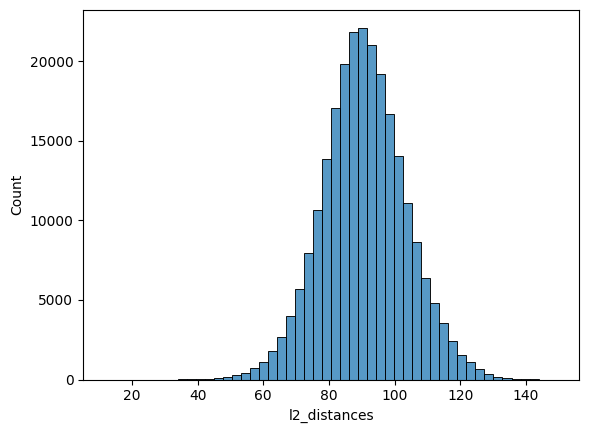

In [20]:
# Distribution of intra-label l2 distances
sns.histplot(data = intra_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [21]:
# Descriptive statistics for intra-label cosine distances
intra_cos_df.describe()

,cosine_distances
count,242257.000000
mean,0.520168
std,0.116936
min,0.006934
25%,0.442002
50%,0.521419
75%,0.600134
max,0.876655


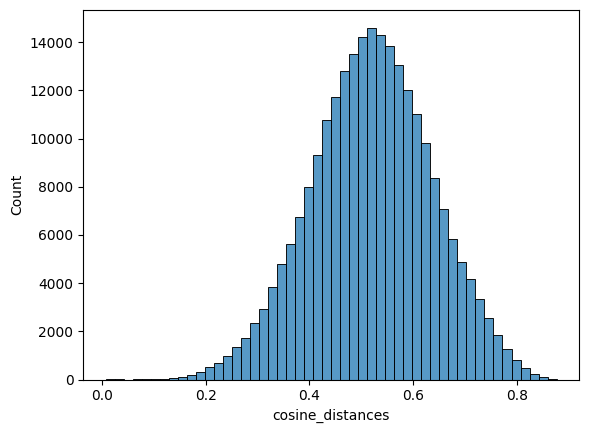

In [22]:
# Distribution of intra-label cosine distances
sns.histplot(data = intra_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

### Inter-Distances for Stretched_152

In [22]:
root_path = './data/vectorized/stretched_152'
distances_stem = './data/vectorized/stretched_152_inter_distances'
vector_leaf = '-stretched'

In [14]:
# Grab all unique names, vector paths, and load vectors into memory
unique_names = get_unique_names(root_path)
all_paths, vectors = get_all_paths_and_vectors(root_path)

In [15]:
# Calculating inter-label distances and writing to disk
# Processing was able to be done using 20 GB of memory, required ~2-3 hours to process
calculate_inter_distances(unique_names, all_paths, vectors, distances_stem)

Calculating inter-label distances for AJ_Cook
Appending inter-label distances for AJ_Cook to dictionary
Calculating inter-label distances for AJ_Lamas
Appending inter-label distances for AJ_Lamas to dictionary
Calculating inter-label distances for Aaron_Eckhart
Appending inter-label distances for Aaron_Eckhart to dictionary
Calculating inter-label distances for Aaron_Guiel
Appending inter-label distances for Aaron_Guiel to dictionary
Calculating inter-label distances for Aaron_Patterson
Appending inter-label distances for Aaron_Patterson to dictionary
Calculating inter-label distances for Aaron_Peirsol
Appending inter-label distances for Aaron_Peirsol to dictionary
Calculating inter-label distances for Aaron_Pena
Appending inter-label distances for Aaron_Pena to dictionary
Calculating inter-label distances for Aaron_Sorkin
Appending inter-label distances for Aaron_Sorkin to dictionary
Calculating inter-label distances for Aaron_Tippin
Appending inter-label distances for Aaron_Tippin to

Appending inter-label distances for Aileen_Riggin_Soule to dictionary
Calculating inter-label distances for Ain_Seppik
Appending inter-label distances for Ain_Seppik to dictionary
Calculating inter-label distances for Ainsworth_Dyer
Appending inter-label distances for Ainsworth_Dyer to dictionary
Calculating inter-label distances for Aishwarya_Rai
Appending inter-label distances for Aishwarya_Rai to dictionary
Calculating inter-label distances for Aitor_Gonzalez
Appending inter-label distances for Aitor_Gonzalez to dictionary
Calculating inter-label distances for Aiysha_Smith
Appending inter-label distances for Aiysha_Smith to dictionary
Calculating inter-label distances for Ajit_Agarkar
Appending inter-label distances for Ajit_Agarkar to dictionary
Calculating inter-label distances for Akbar_Al_Baker
Appending inter-label distances for Akbar_Al_Baker to dictionary
Calculating inter-label distances for Akbar_Hashemi_Rafsanjani
Appending inter-label distances for Akbar_Hashemi_Rafsanjan

Appending inter-label distances for Alex_King to dictionary
Calculating inter-label distances for Alex_Penelas
Appending inter-label distances for Alex_Penelas to dictionary
Calculating inter-label distances for Alex_Popov
Appending inter-label distances for Alex_Popov to dictionary
Calculating inter-label distances for Alex_Sink
Appending inter-label distances for Alex_Sink to dictionary
Calculating inter-label distances for Alex_Wallau
Appending inter-label distances for Alex_Wallau to dictionary
Calculating inter-label distances for Alex_Zanardi
Appending inter-label distances for Alex_Zanardi to dictionary
Calculating inter-label distances for Alexa_Loren
Appending inter-label distances for Alexa_Loren to dictionary
Calculating inter-label distances for Alexa_Vega
Appending inter-label distances for Alexa_Vega to dictionary
Calculating inter-label distances for Alexander_Downer
Appending inter-label distances for Alexander_Downer to dictionary
Calculating inter-label distances for 

Appending inter-label distances for Alvaro_Silva_Calderon to dictionary
Calculating inter-label distances for Alvaro_Uribe
Appending inter-label distances for Alvaro_Uribe to dictionary
Calculating inter-label distances for Aly_Wagner
Appending inter-label distances for Aly_Wagner to dictionary
Calculating inter-label distances for Alyse_Beaupre
Appending inter-label distances for Alyse_Beaupre to dictionary
Calculating inter-label distances for Alyson_Hannigan
Appending inter-label distances for Alyson_Hannigan to dictionary
Calculating inter-label distances for Amanda_Beard
Appending inter-label distances for Amanda_Beard to dictionary
Calculating inter-label distances for Amanda_Bynes
Appending inter-label distances for Amanda_Bynes to dictionary
Calculating inter-label distances for Amanda_Coetzer
Appending inter-label distances for Amanda_Coetzer to dictionary
Calculating inter-label distances for Amanda_Marsh
Appending inter-label distances for Amanda_Marsh to dictionary
Calculat

Appending inter-label distances for Andy_Benes to dictionary
Calculating inter-label distances for Andy_Bryant
Appending inter-label distances for Andy_Bryant to dictionary
Calculating inter-label distances for Andy_Dick
Appending inter-label distances for Andy_Dick to dictionary
Calculating inter-label distances for Andy_Garcia
Appending inter-label distances for Andy_Garcia to dictionary
Calculating inter-label distances for Andy_Graves
Appending inter-label distances for Andy_Graves to dictionary
Calculating inter-label distances for Andy_Griffith
Appending inter-label distances for Andy_Griffith to dictionary
Calculating inter-label distances for Andy_Griggs
Appending inter-label distances for Andy_Griggs to dictionary
Calculating inter-label distances for Andy_Hebb
Appending inter-label distances for Andy_Hebb to dictionary
Calculating inter-label distances for Andy_Lau
Appending inter-label distances for Andy_Lau to dictionary
Calculating inter-label distances for Andy_Madikians


Appending inter-label distances for Anthony_Rackauckas to dictionary
Calculating inter-label distances for Anthony_Scott_Miller
Appending inter-label distances for Anthony_Scott_Miller to dictionary
Calculating inter-label distances for Antje_Buschschulte
Appending inter-label distances for Antje_Buschschulte to dictionary
Calculating inter-label distances for Anton_Balasingham
Appending inter-label distances for Anton_Balasingham to dictionary
Calculating inter-label distances for Antonio_Banderas
Appending inter-label distances for Antonio_Banderas to dictionary
Calculating inter-label distances for Antonio_Bernardo
Appending inter-label distances for Antonio_Bernardo to dictionary
Calculating inter-label distances for Antonio_Cassano
Appending inter-label distances for Antonio_Cassano to dictionary
Calculating inter-label distances for Antonio_Catania
Appending inter-label distances for Antonio_Catania to dictionary
Calculating inter-label distances for Antonio_Elias_Saca
Appending 

Appending inter-label distances for Atom_Egoyan to dictionary
Calculating inter-label distances for Atsushi_Sato
Appending inter-label distances for Atsushi_Sato to dictionary
Calculating inter-label distances for Audrey_Lacroix
Appending inter-label distances for Audrey_Lacroix to dictionary
Calculating inter-label distances for Audrey_Sauret
Appending inter-label distances for Audrey_Sauret to dictionary
Calculating inter-label distances for Augustin_Calleri
Appending inter-label distances for Augustin_Calleri to dictionary
Calculating inter-label distances for Augusto_Pinochet
Appending inter-label distances for Augusto_Pinochet to dictionary
Calculating inter-label distances for Augusto_Roa_Bastos
Appending inter-label distances for Augusto_Roa_Bastos to dictionary
Calculating inter-label distances for Aung_San_Suu_Kyi
Appending inter-label distances for Aung_San_Suu_Kyi to dictionary
Calculating inter-label distances for Austin_Kearns
Appending inter-label distances for Austin_Kea

Appending inter-label distances for Benjamin_Bratt to dictionary
Calculating inter-label distances for Benjamin_Franklin
Appending inter-label distances for Benjamin_Franklin to dictionary
Calculating inter-label distances for Benjamin_Martinez
Appending inter-label distances for Benjamin_Martinez to dictionary
Calculating inter-label distances for Benjamin_McKenzie
Appending inter-label distances for Benjamin_McKenzie to dictionary
Calculating inter-label distances for Benjamin_Netanyahu
Appending inter-label distances for Benjamin_Netanyahu to dictionary
Calculating inter-label distances for Benjamin_Neulander
Appending inter-label distances for Benjamin_Neulander to dictionary
Calculating inter-label distances for Bernadette_Peters
Appending inter-label distances for Bernadette_Peters to dictionary
Calculating inter-label distances for Bernard_Ebbers
Appending inter-label distances for Bernard_Ebbers to dictionary
Calculating inter-label distances for Bernard_Giraudeau
Appending int

Appending inter-label distances for Bill_Stapleton to dictionary
Calculating inter-label distances for Bill_Stein
Appending inter-label distances for Bill_Stein to dictionary
Calculating inter-label distances for Bill_Walton
Appending inter-label distances for Bill_Walton to dictionary
Calculating inter-label distances for Billy_Andrade
Appending inter-label distances for Billy_Andrade to dictionary
Calculating inter-label distances for Billy_Beane
Appending inter-label distances for Billy_Beane to dictionary
Calculating inter-label distances for Billy_Bob_Thornton
Appending inter-label distances for Billy_Bob_Thornton to dictionary
Calculating inter-label distances for Billy_Boyd
Appending inter-label distances for Billy_Boyd to dictionary
Calculating inter-label distances for Billy_Crawford
Appending inter-label distances for Billy_Crawford to dictionary
Calculating inter-label distances for Billy_Crystal
Appending inter-label distances for Billy_Crystal to dictionary
Calculating int

Appending inter-label distances for Boutros_Boutros_Ghali to dictionary
Calculating inter-label distances for Brad_Alexander_Smith
Appending inter-label distances for Brad_Alexander_Smith to dictionary
Calculating inter-label distances for Brad_Banks
Appending inter-label distances for Brad_Banks to dictionary
Calculating inter-label distances for Brad_Brownell
Appending inter-label distances for Brad_Brownell to dictionary
Calculating inter-label distances for Brad_Garrett
Appending inter-label distances for Brad_Garrett to dictionary
Calculating inter-label distances for Brad_Gushue
Appending inter-label distances for Brad_Gushue to dictionary
Calculating inter-label distances for Brad_Johnson
Appending inter-label distances for Brad_Johnson to dictionary
Calculating inter-label distances for Brad_Miller
Appending inter-label distances for Brad_Miller to dictionary
Calculating inter-label distances for Brad_Pitt
Appending inter-label distances for Brad_Pitt to dictionary
Calculating 

Appending inter-label distances for Britney_Spears to dictionary
Calculating inter-label distances for Brittany_Snow
Appending inter-label distances for Brittany_Snow to dictionary
Calculating inter-label distances for Brock_Berlin
Appending inter-label distances for Brock_Berlin to dictionary
Calculating inter-label distances for Bronson_Arroyo
Appending inter-label distances for Bronson_Arroyo to dictionary
Calculating inter-label distances for Brook_Robinson
Appending inter-label distances for Brook_Robinson to dictionary
Calculating inter-label distances for Brooke_Adams
Appending inter-label distances for Brooke_Adams to dictionary
Calculating inter-label distances for Brooke_Gordon
Appending inter-label distances for Brooke_Gordon to dictionary
Calculating inter-label distances for Brooke_Shields
Appending inter-label distances for Brooke_Shields to dictionary
Calculating inter-label distances for Bruce_Arena
Appending inter-label distances for Bruce_Arena to dictionary
Calculati

Appending inter-label distances for Carlos_Beltran to dictionary
Calculating inter-label distances for Carlos_Bianchi
Appending inter-label distances for Carlos_Bianchi to dictionary
Calculating inter-label distances for Carlos_De_Abreu
Appending inter-label distances for Carlos_De_Abreu to dictionary
Calculating inter-label distances for Carlos_Fasciolo
Appending inter-label distances for Carlos_Fasciolo to dictionary
Calculating inter-label distances for Carlos_Ghosn
Appending inter-label distances for Carlos_Ghosn to dictionary
Calculating inter-label distances for Carlos_Iturgaitz
Appending inter-label distances for Carlos_Iturgaitz to dictionary
Calculating inter-label distances for Carlos_Juarez
Appending inter-label distances for Carlos_Juarez to dictionary
Calculating inter-label distances for Carlos_Lordkipanitse
Appending inter-label distances for Carlos_Lordkipanitse to dictionary
Calculating inter-label distances for Carlos_Manuel_Pruneda
Appending inter-label distances for

Appending inter-label distances for Cemil_Cicek to dictionary
Calculating inter-label distances for Cesar_Gaviria
Appending inter-label distances for Cesar_Gaviria to dictionary
Calculating inter-label distances for Cesar_Maia
Appending inter-label distances for Cesar_Maia to dictionary
Calculating inter-label distances for Cha_Yung-gu
Appending inter-label distances for Cha_Yung-gu to dictionary
Calculating inter-label distances for Chadha_Gurinder
Appending inter-label distances for Chadha_Gurinder to dictionary
Calculating inter-label distances for Chakib_Khelil
Appending inter-label distances for Chakib_Khelil to dictionary
Calculating inter-label distances for Chan_Choi
Appending inter-label distances for Chan_Choi to dictionary
Calculating inter-label distances for Chan_Gailey
Appending inter-label distances for Chan_Gailey to dictionary
Calculating inter-label distances for Chan_Ho_Park
Appending inter-label distances for Chan_Ho_Park to dictionary
Calculating inter-label distan

Appending inter-label distances for Chin-Hui_Tsao to dictionary
Calculating inter-label distances for Chip_Burrus
Appending inter-label distances for Chip_Burrus to dictionary
Calculating inter-label distances for Chip_Ganassi
Appending inter-label distances for Chip_Ganassi to dictionary
Calculating inter-label distances for Chip_Knight
Appending inter-label distances for Chip_Knight to dictionary
Calculating inter-label distances for Chistian_Stahl
Appending inter-label distances for Chistian_Stahl to dictionary
Calculating inter-label distances for Chita_Rivera
Appending inter-label distances for Chita_Rivera to dictionary
Calculating inter-label distances for Chloe_Sevigny
Appending inter-label distances for Chloe_Sevigny to dictionary
Calculating inter-label distances for Cho_Myung-kyun
Appending inter-label distances for Cho_Myung-kyun to dictionary
Calculating inter-label distances for Choi_Sung-hong
Appending inter-label distances for Choi_Sung-hong to dictionary
Calculating in

Appending inter-label distances for Christopher_Whittle to dictionary
Calculating inter-label distances for Christy_Ferer
Appending inter-label distances for Christy_Ferer to dictionary
Calculating inter-label distances for Christy_Turlington
Appending inter-label distances for Christy_Turlington to dictionary
Calculating inter-label distances for Chuanyun_Li
Appending inter-label distances for Chuanyun_Li to dictionary
Calculating inter-label distances for Chuck_Amato
Appending inter-label distances for Chuck_Amato to dictionary
Calculating inter-label distances for Chuck_Bednarik
Appending inter-label distances for Chuck_Bednarik to dictionary
Calculating inter-label distances for Chuck_Eidson
Appending inter-label distances for Chuck_Eidson to dictionary
Calculating inter-label distances for Chuck_Finley
Appending inter-label distances for Chuck_Finley to dictionary
Calculating inter-label distances for Chuck_Hagel
Appending inter-label distances for Chuck_Hagel to dictionary
Calcul

Appending inter-label distances for Compay_Segundo to dictionary
Calculating inter-label distances for Conan_OBrien
Appending inter-label distances for Conan_OBrien to dictionary
Calculating inter-label distances for Conchita_Martinez
Appending inter-label distances for Conchita_Martinez to dictionary
Calculating inter-label distances for Condoleezza_Rice
Appending inter-label distances for Condoleezza_Rice to dictionary
Calculating inter-label distances for Connie_Chung
Appending inter-label distances for Connie_Chung to dictionary
Calculating inter-label distances for Connie_Freydell
Appending inter-label distances for Connie_Freydell to dictionary
Calculating inter-label distances for Conrad_Black
Appending inter-label distances for Conrad_Black to dictionary
Calculating inter-label distances for Constance_Marie
Appending inter-label distances for Constance_Marie to dictionary
Calculating inter-label distances for Cora_Cambell
Appending inter-label distances for Cora_Cambell to dict

Appending inter-label distances for Dan_Prinster to dictionary
Calculating inter-label distances for Dan_Quayle
Appending inter-label distances for Dan_Quayle to dictionary
Calculating inter-label distances for Dan_Reeves
Appending inter-label distances for Dan_Reeves to dictionary
Calculating inter-label distances for Dan_Snyder
Appending inter-label distances for Dan_Snyder to dictionary
Calculating inter-label distances for Dan_Wheldon
Appending inter-label distances for Dan_Wheldon to dictionary
Calculating inter-label distances for Dana_Vollmer
Appending inter-label distances for Dana_Vollmer to dictionary
Calculating inter-label distances for Daniel_Barenboim
Appending inter-label distances for Daniel_Barenboim to dictionary
Calculating inter-label distances for Daniel_Bruehl
Appending inter-label distances for Daniel_Bruehl to dictionary
Calculating inter-label distances for Daniel_Chin
Appending inter-label distances for Daniel_Chin to dictionary
Calculating inter-label distanc

Appending inter-label distances for Dave_Ragone to dictionary
Calculating inter-label distances for Dave_Robertson
Appending inter-label distances for Dave_Robertson to dictionary
Calculating inter-label distances for Dave_Tucker
Appending inter-label distances for Dave_Tucker to dictionary
Calculating inter-label distances for Dave_Wannstedt
Appending inter-label distances for Dave_Wannstedt to dictionary
Calculating inter-label distances for Dave_Williams
Appending inter-label distances for Dave_Williams to dictionary
Calculating inter-label distances for Davey_Johnson
Appending inter-label distances for Davey_Johnson to dictionary
Calculating inter-label distances for David_Alpay
Appending inter-label distances for David_Alpay to dictionary
Calculating inter-label distances for David_Anderson
Appending inter-label distances for David_Anderson to dictionary
Calculating inter-label distances for David_Arquette
Appending inter-label distances for David_Arquette to dictionary
Calculatin

Appending inter-label distances for David_Trimble to dictionary
Calculating inter-label distances for David_Welch
Appending inter-label distances for David_Welch to dictionary
Calculating inter-label distances for David_Wells
Appending inter-label distances for David_Wells to dictionary
Calculating inter-label distances for David_Westerfield
Appending inter-label distances for David_Westerfield to dictionary
Calculating inter-label distances for David_Wolf
Appending inter-label distances for David_Wolf to dictionary
Calculating inter-label distances for David_Zeplowitz
Appending inter-label distances for David_Zeplowitz to dictionary
Calculating inter-label distances for Davis_Love_III
Appending inter-label distances for Davis_Love_III to dictionary
Calculating inter-label distances for Dawn_Staley
Appending inter-label distances for Dawn_Staley to dictionary
Calculating inter-label distances for Dawna_LoPiccolo
Appending inter-label distances for Dawna_LoPiccolo to dictionary
Calculat

Appending inter-label distances for Diana_Taylor to dictionary
Calculating inter-label distances for Diane_Green
Appending inter-label distances for Diane_Green to dictionary
Calculating inter-label distances for Diane_Ladd
Appending inter-label distances for Diane_Ladd to dictionary
Calculating inter-label distances for Diane_Lane
Appending inter-label distances for Diane_Lane to dictionary
Calculating inter-label distances for Dianne_Feinstein
Appending inter-label distances for Dianne_Feinstein to dictionary
Calculating inter-label distances for Dianne_Reeves
Appending inter-label distances for Dianne_Reeves to dictionary
Calculating inter-label distances for Dick_Armey
Appending inter-label distances for Dick_Armey to dictionary
Calculating inter-label distances for Dick_Bennett
Appending inter-label distances for Dick_Bennett to dictionary
Calculating inter-label distances for Dick_Cheney
Appending inter-label distances for Dick_Cheney to dictionary
Calculating inter-label distanc

Appending inter-label distances for Donna_Ralston to dictionary
Calculating inter-label distances for Donna_Shalala
Appending inter-label distances for Donna_Shalala to dictionary
Calculating inter-label distances for Donna_Walker
Appending inter-label distances for Donna_Walker to dictionary
Calculating inter-label distances for Donnie_Brennan
Appending inter-label distances for Donnie_Brennan to dictionary
Calculating inter-label distances for Donny_Osmond
Appending inter-label distances for Donny_Osmond to dictionary
Calculating inter-label distances for Dora_Bakoyianni
Appending inter-label distances for Dora_Bakoyianni to dictionary
Calculating inter-label distances for Doris_Roberts
Appending inter-label distances for Doris_Roberts to dictionary
Calculating inter-label distances for Doris_Schroeder
Appending inter-label distances for Doris_Schroeder to dictionary
Calculating inter-label distances for Dorothy_Lamour
Appending inter-label distances for Dorothy_Lamour to dictionary


Appending inter-label distances for Edmund_Stoiber to dictionary
Calculating inter-label distances for Edouard_Michelin
Appending inter-label distances for Edouard_Michelin to dictionary
Calculating inter-label distances for Eduard_Limonov
Appending inter-label distances for Eduard_Limonov to dictionary
Calculating inter-label distances for Eduard_Shevardnadze
Appending inter-label distances for Eduard_Shevardnadze to dictionary
Calculating inter-label distances for Eduardo_Chillida
Appending inter-label distances for Eduardo_Chillida to dictionary
Calculating inter-label distances for Eduardo_Duhalde
Appending inter-label distances for Eduardo_Duhalde to dictionary
Calculating inter-label distances for Eduardo_Fischer
Appending inter-label distances for Eduardo_Fischer to dictionary
Calculating inter-label distances for Eduardo_Romero
Appending inter-label distances for Eduardo_Romero to dictionary
Calculating inter-label distances for Edward_Albee
Appending inter-label distances for 

Appending inter-label distances for Ellen_Engleman to dictionary
Calculating inter-label distances for Ellen_MacArthur
Appending inter-label distances for Ellen_MacArthur to dictionary
Calculating inter-label distances for Ellen_Martin
Appending inter-label distances for Ellen_Martin to dictionary
Calculating inter-label distances for Ellen_Pompeo
Appending inter-label distances for Ellen_Pompeo to dictionary
Calculating inter-label distances for Ellen_Saracini
Appending inter-label distances for Ellen_Saracini to dictionary
Calculating inter-label distances for Elliott_Mincberg
Appending inter-label distances for Elliott_Mincberg to dictionary
Calculating inter-label distances for Elmar_Brok
Appending inter-label distances for Elmar_Brok to dictionary
Calculating inter-label distances for Elodie_Bouchez
Appending inter-label distances for Elodie_Bouchez to dictionary
Calculating inter-label distances for Eloy_Gutierrez
Appending inter-label distances for Eloy_Gutierrez to dictionary
C

Appending inter-label distances for Erin_Brockovich to dictionary
Calculating inter-label distances for Erin_Hershey_Presley
Appending inter-label distances for Erin_Hershey_Presley to dictionary
Calculating inter-label distances for Erin_Runnion
Appending inter-label distances for Erin_Runnion to dictionary
Calculating inter-label distances for Ernest_Hollings
Appending inter-label distances for Ernest_Hollings to dictionary
Calculating inter-label distances for Ernesto_Zedillo
Appending inter-label distances for Ernesto_Zedillo to dictionary
Calculating inter-label distances for Ernie_Els
Appending inter-label distances for Ernie_Els to dictionary
Calculating inter-label distances for Ernie_Eves
Appending inter-label distances for Ernie_Eves to dictionary
Calculating inter-label distances for Ernie_Fletcher
Appending inter-label distances for Ernie_Fletcher to dictionary
Calculating inter-label distances for Ernie_Grunfeld
Appending inter-label distances for Ernie_Grunfeld to diction

Appending inter-label distances for Felix_Trinidad to dictionary
Calculating inter-label distances for Ferenc_Madl
Appending inter-label distances for Ferenc_Madl to dictionary
Calculating inter-label distances for Fernando_Alonso
Appending inter-label distances for Fernando_Alonso to dictionary
Calculating inter-label distances for Fernando_Gonzalez
Appending inter-label distances for Fernando_Gonzalez to dictionary
Calculating inter-label distances for Fernando_Henrique_Cardoso
Appending inter-label distances for Fernando_Henrique_Cardoso to dictionary
Calculating inter-label distances for Fernando_Hierro
Appending inter-label distances for Fernando_Hierro to dictionary
Calculating inter-label distances for Fernando_Leon_de_Aranoa
Appending inter-label distances for Fernando_Leon_de_Aranoa to dictionary
Calculating inter-label distances for Fernando_Sanz
Appending inter-label distances for Fernando_Sanz to dictionary
Calculating inter-label distances for Fernando_Valenzuela
Appending

Appending inter-label distances for Frank_Zappa to dictionary
Calculating inter-label distances for Franklin_Brown
Appending inter-label distances for Franklin_Brown to dictionary
Calculating inter-label distances for Franklin_Damann
Appending inter-label distances for Franklin_Damann to dictionary
Calculating inter-label distances for Franko_Simatovic
Appending inter-label distances for Franko_Simatovic to dictionary
Calculating inter-label distances for Franz_Beckenbauer
Appending inter-label distances for Franz_Beckenbauer to dictionary
Calculating inter-label distances for Franz_Fischler
Appending inter-label distances for Franz_Fischler to dictionary
Calculating inter-label distances for Franz_Gsell
Appending inter-label distances for Franz_Gsell to dictionary
Calculating inter-label distances for Franz_Muentefering
Appending inter-label distances for Franz_Muentefering to dictionary
Calculating inter-label distances for Fred_Durst
Appending inter-label distances for Fred_Durst to

Appending inter-label distances for Gen_Meredith to dictionary
Calculating inter-label distances for Gene_Autry
Appending inter-label distances for Gene_Autry to dictionary
Calculating inter-label distances for Gene_Hackman
Appending inter-label distances for Gene_Hackman to dictionary
Calculating inter-label distances for Gene_Keady
Appending inter-label distances for Gene_Keady to dictionary
Calculating inter-label distances for Gene_Orza
Appending inter-label distances for Gene_Orza to dictionary
Calculating inter-label distances for Gene_Robinson
Appending inter-label distances for Gene_Robinson to dictionary
Calculating inter-label distances for Gene_Sauers
Appending inter-label distances for Gene_Sauers to dictionary
Calculating inter-label distances for Gennifer_Flowers
Appending inter-label distances for Gennifer_Flowers to dictionary
Calculating inter-label distances for Geno_Auriemma
Appending inter-label distances for Geno_Auriemma to dictionary
Calculating inter-label dista

Appending inter-label distances for Gianna_Angelopoulos-Daskalaki to dictionary
Calculating inter-label distances for Gianni_Agnelli
Appending inter-label distances for Gianni_Agnelli to dictionary
Calculating inter-label distances for Giannina_Facio
Appending inter-label distances for Giannina_Facio to dictionary
Calculating inter-label distances for Gideon_Black
Appending inter-label distances for Gideon_Black to dictionary
Calculating inter-label distances for Gideon_Yago
Appending inter-label distances for Gideon_Yago to dictionary
Calculating inter-label distances for Gil_Cates
Appending inter-label distances for Gil_Cates to dictionary
Calculating inter-label distances for Gil_de_Ferran
Appending inter-label distances for Gil_de_Ferran to dictionary
Calculating inter-label distances for Gilberto_Rodriguez_Orejuela
Appending inter-label distances for Gilberto_Rodriguez_Orejuela to dictionary
Calculating inter-label distances for Gilberto_Simoni
Appending inter-label distances for 

Appending inter-label distances for Greg_Owen to dictionary
Calculating inter-label distances for Greg_Rusedski
Appending inter-label distances for Greg_Rusedski to dictionary
Calculating inter-label distances for Gregg_Berhalter
Appending inter-label distances for Gregg_Berhalter to dictionary
Calculating inter-label distances for Gregg_Popovich
Appending inter-label distances for Gregg_Popovich to dictionary
Calculating inter-label distances for Gregor_Gysi
Appending inter-label distances for Gregor_Gysi to dictionary
Calculating inter-label distances for Gregorio_Honasan
Appending inter-label distances for Gregorio_Honasan to dictionary
Calculating inter-label distances for Gregorio_Rosal
Appending inter-label distances for Gregorio_Rosal to dictionary
Calculating inter-label distances for Gregory_Geoffroy
Appending inter-label distances for Gregory_Geoffroy to dictionary
Calculating inter-label distances for Gregory_Hines
Appending inter-label distances for Gregory_Hines to diction

Appending inter-label distances for Hannah_Stockbauer to dictionary
Calculating inter-label distances for Hanns_Schumacher
Appending inter-label distances for Hanns_Schumacher to dictionary
Calculating inter-label distances for Hans-Christian_Schmid
Appending inter-label distances for Hans-Christian_Schmid to dictionary
Calculating inter-label distances for Hans_Blix
Appending inter-label distances for Hans_Blix to dictionary
Calculating inter-label distances for Hans_Corell
Appending inter-label distances for Hans_Corell to dictionary
Calculating inter-label distances for Hans_Eichel
Appending inter-label distances for Hans_Eichel to dictionary
Calculating inter-label distances for Hans_Leistritz
Appending inter-label distances for Hans_Leistritz to dictionary
Calculating inter-label distances for Hans_Peter_Briegel
Appending inter-label distances for Hans_Peter_Briegel to dictionary
Calculating inter-label distances for Harald_Ringstorff
Appending inter-label distances for Harald_Rin

Appending inter-label distances for Herbert_Haupt to dictionary
Calculating inter-label distances for Herbie_Hancock
Appending inter-label distances for Herbie_Hancock to dictionary
Calculating inter-label distances for Herman_Edwards
Appending inter-label distances for Herman_Edwards to dictionary
Calculating inter-label distances for Herman_Moore
Appending inter-label distances for Herman_Moore to dictionary
Calculating inter-label distances for Hermando_Harton
Appending inter-label distances for Hermando_Harton to dictionary
Calculating inter-label distances for Hermann_Maier
Appending inter-label distances for Hermann_Maier to dictionary
Calculating inter-label distances for Hermes_Gamonal
Appending inter-label distances for Hermes_Gamonal to dictionary
Calculating inter-label distances for Hermogenes_Ebdane_Jr
Appending inter-label distances for Hermogenes_Ebdane_Jr to dictionary
Calculating inter-label distances for Hernan_Crespo
Appending inter-label distances for Hernan_Crespo 

Appending inter-label distances for Hunter_Bates to dictionary
Calculating inter-label distances for Hunter_Kemper
Appending inter-label distances for Hunter_Kemper to dictionary
Calculating inter-label distances for Hushiar_Zebari
Appending inter-label distances for Hushiar_Zebari to dictionary
Calculating inter-label distances for Hussam_Mohammed_Amin
Appending inter-label distances for Hussam_Mohammed_Amin to dictionary
Calculating inter-label distances for Hussein_Malik
Appending inter-label distances for Hussein_Malik to dictionary
Calculating inter-label distances for Hutomo_Mandala_Putra
Appending inter-label distances for Hutomo_Mandala_Putra to dictionary
Calculating inter-label distances for Hwang_Doo-yun
Appending inter-label distances for Hwang_Doo-yun to dictionary
Calculating inter-label distances for Iain_Anderson
Appending inter-label distances for Iain_Anderson to dictionary
Calculating inter-label distances for Iain_Duncan_Smith
Appending inter-label distances for Iai

Appending inter-label distances for Itzhak_Perlman to dictionary
Calculating inter-label distances for Iva_Majoli
Appending inter-label distances for Iva_Majoli to dictionary
Calculating inter-label distances for Ivan_Helguera
Appending inter-label distances for Ivan_Helguera to dictionary
Calculating inter-label distances for Ivan_Lee
Appending inter-label distances for Ivan_Lee to dictionary
Calculating inter-label distances for Ivan_Shvedoff
Appending inter-label distances for Ivan_Shvedoff to dictionary
Calculating inter-label distances for Ivan_Stambolic
Appending inter-label distances for Ivan_Stambolic to dictionary
Calculating inter-label distances for Ivana_Trump
Appending inter-label distances for Ivana_Trump to dictionary
Calculating inter-label distances for Iveta_Benesova
Appending inter-label distances for Iveta_Benesova to dictionary
Calculating inter-label distances for Ivo_Dubs
Appending inter-label distances for Ivo_Dubs to dictionary
Calculating inter-label distances

Appending inter-label distances for James_Hakett to dictionary
Calculating inter-label distances for James_Hallock
Appending inter-label distances for James_Hallock to dictionary
Calculating inter-label distances for James_Harris
Appending inter-label distances for James_Harris to dictionary
Calculating inter-label distances for James_Hill
Appending inter-label distances for James_Hill to dictionary
Calculating inter-label distances for James_Hoffa
Appending inter-label distances for James_Hoffa to dictionary
Calculating inter-label distances for James_Hughes
Appending inter-label distances for James_Hughes to dictionary
Calculating inter-label distances for James_Ivory
Appending inter-label distances for James_Ivory to dictionary
Calculating inter-label distances for James_Jones
Appending inter-label distances for James_Jones to dictionary
Calculating inter-label distances for James_Kelly
Appending inter-label distances for James_Kelly to dictionary
Calculating inter-label distances f

Appending inter-label distances for Jane_Walker_Wood to dictionary
Calculating inter-label distances for Janela_Jara
Appending inter-label distances for Janela_Jara to dictionary
Calculating inter-label distances for Janet_Chandler
Appending inter-label distances for Janet_Chandler to dictionary
Calculating inter-label distances for Janet_Crawford
Appending inter-label distances for Janet_Crawford to dictionary
Calculating inter-label distances for Janet_Ecker
Appending inter-label distances for Janet_Ecker to dictionary
Calculating inter-label distances for Janet_Horvath
Appending inter-label distances for Janet_Horvath to dictionary
Calculating inter-label distances for Janet_Leigh
Appending inter-label distances for Janet_Leigh to dictionary
Calculating inter-label distances for Janet_Napolitano
Appending inter-label distances for Janet_Napolitano to dictionary
Calculating inter-label distances for Janet_Thorpe
Appending inter-label distances for Janet_Thorpe to dictionary
Calculati

Appending inter-label distances for Jean_Brumley to dictionary
Calculating inter-label distances for Jean_Carnahan
Appending inter-label distances for Jean_Carnahan to dictionary
Calculating inter-label distances for Jean_Charest
Appending inter-label distances for Jean_Charest to dictionary
Calculating inter-label distances for Jean_Chretien
Appending inter-label distances for Jean_Chretien to dictionary
Calculating inter-label distances for Jean_Nagel
Appending inter-label distances for Jean_Nagel to dictionary
Calculating inter-label distances for Jean_Todt
Appending inter-label distances for Jean_Todt to dictionary
Calculating inter-label distances for Jeane_Kirkpatrick
Appending inter-label distances for Jeane_Kirkpatrick to dictionary
Calculating inter-label distances for Jeanette_Gray
Appending inter-label distances for Jeanette_Gray to dictionary
Calculating inter-label distances for Jeanette_Stauffer
Appending inter-label distances for Jeanette_Stauffer to dictionary
Calculati

Appending inter-label distances for Jerome_Golmard to dictionary
Calculating inter-label distances for Jerome_Jenkins
Appending inter-label distances for Jerome_Jenkins to dictionary
Calculating inter-label distances for Jerry_Angelo
Appending inter-label distances for Jerry_Angelo to dictionary
Calculating inter-label distances for Jerry_Bruckheimer
Appending inter-label distances for Jerry_Bruckheimer to dictionary
Calculating inter-label distances for Jerry_Colangelo
Appending inter-label distances for Jerry_Colangelo to dictionary
Calculating inter-label distances for Jerry_Falwell
Appending inter-label distances for Jerry_Falwell to dictionary
Calculating inter-label distances for Jerry_Hall
Appending inter-label distances for Jerry_Hall to dictionary
Calculating inter-label distances for Jerry_Jones
Appending inter-label distances for Jerry_Jones to dictionary
Calculating inter-label distances for Jerry_Lewis
Appending inter-label distances for Jerry_Lewis to dictionary
Calculati

Appending inter-label distances for Jim_Taylor to dictionary
Calculating inter-label distances for Jim_Thome
Appending inter-label distances for Jim_Thome to dictionary
Calculating inter-label distances for Jim_Tressel
Appending inter-label distances for Jim_Tressel to dictionary
Calculating inter-label distances for Jim_Wall
Appending inter-label distances for Jim_Wall to dictionary
Calculating inter-label distances for Jim_Wessling
Appending inter-label distances for Jim_Wessling to dictionary
Calculating inter-label distances for Jim_Wong
Appending inter-label distances for Jim_Wong to dictionary
Calculating inter-label distances for Jim_Zorn
Appending inter-label distances for Jim_Zorn to dictionary
Calculating inter-label distances for Jimmy_Carter
Appending inter-label distances for Jimmy_Carter to dictionary
Calculating inter-label distances for Jimmy_Gobble
Appending inter-label distances for Jimmy_Gobble to dictionary
Calculating inter-label distances for Jimmy_Gurule
Appendin

Appending inter-label distances for John_Allen_Muhammad to dictionary
Calculating inter-label distances for John_Anderson
Appending inter-label distances for John_Anderson to dictionary
Calculating inter-label distances for John_Ashcroft
Appending inter-label distances for John_Ashcroft to dictionary
Calculating inter-label distances for John_Baldacci
Appending inter-label distances for John_Baldacci to dictionary
Calculating inter-label distances for John_Banko
Appending inter-label distances for John_Banko to dictionary
Calculating inter-label distances for John_Barnett
Appending inter-label distances for John_Barnett to dictionary
Calculating inter-label distances for John_Belushi
Appending inter-label distances for John_Belushi to dictionary
Calculating inter-label distances for John_Blaney
Appending inter-label distances for John_Blaney to dictionary
Calculating inter-label distances for John_Bolton
Appending inter-label distances for John_Bolton to dictionary
Calculating inter-la

Appending inter-label distances for John_Philip_Elkann to dictionary
Calculating inter-label distances for John_Prescott
Appending inter-label distances for John_Prescott to dictionary
Calculating inter-label distances for John_Reid
Appending inter-label distances for John_Reid to dictionary
Calculating inter-label distances for John_Reilly
Appending inter-label distances for John_Reilly to dictionary
Calculating inter-label distances for John_Richardson
Appending inter-label distances for John_Richardson to dictionary
Calculating inter-label distances for John_Rigas
Appending inter-label distances for John_Rigas to dictionary
Calculating inter-label distances for John_Robbins
Appending inter-label distances for John_Robbins to dictionary
Calculating inter-label distances for John_Rosa
Appending inter-label distances for John_Rosa to dictionary
Calculating inter-label distances for John_Rowe
Appending inter-label distances for John_Rowe to dictionary
Calculating inter-label distances f

Appending inter-label distances for Jorge_Rodolfo_Canicoba_Corral to dictionary
Calculating inter-label distances for Jorge_Valdano
Appending inter-label distances for Jorge_Valdano to dictionary
Calculating inter-label distances for Jorma_Huhtala
Appending inter-label distances for Jorma_Huhtala to dictionary
Calculating inter-label distances for Joschka_Fischer
Appending inter-label distances for Joschka_Fischer to dictionary
Calculating inter-label distances for Jose_Acasuso
Appending inter-label distances for Jose_Acasuso to dictionary
Calculating inter-label distances for Jose_Alencar
Appending inter-label distances for Jose_Alencar to dictionary
Calculating inter-label distances for Jose_Bove
Appending inter-label distances for Jose_Bove to dictionary
Calculating inter-label distances for Jose_Canseco
Appending inter-label distances for Jose_Canseco to dictionary
Calculating inter-label distances for Jose_Canseco_Sr
Appending inter-label distances for Jose_Canseco_Sr to dictionar

Appending inter-label distances for Juan_Roman_Riquelme to dictionary
Calculating inter-label distances for Juan_Sanchez
Appending inter-label distances for Juan_Sanchez to dictionary
Calculating inter-label distances for Juan_Valencia_Osorio
Appending inter-label distances for Juan_Valencia_Osorio to dictionary
Calculating inter-label distances for Juanes
Appending inter-label distances for Juanes to dictionary
Calculating inter-label distances for Judd_Davies
Appending inter-label distances for Judd_Davies to dictionary
Calculating inter-label distances for Jude_Law
Appending inter-label distances for Jude_Law to dictionary
Calculating inter-label distances for Judi_Dench
Appending inter-label distances for Judi_Dench to dictionary
Calculating inter-label distances for Judi_Patton
Appending inter-label distances for Judi_Patton to dictionary
Calculating inter-label distances for Judith_Nathan
Appending inter-label distances for Judith_Nathan to dictionary
Calculating inter-label dist

Appending inter-label distances for Karen_Lynn_Gorney to dictionary
Calculating inter-label distances for Karen_Mok
Appending inter-label distances for Karen_Mok to dictionary
Calculating inter-label distances for Karen_Pereiras
Appending inter-label distances for Karen_Pereiras to dictionary
Calculating inter-label distances for Karen_Sharpe_Kramer
Appending inter-label distances for Karen_Sharpe_Kramer to dictionary
Calculating inter-label distances for Karin_Pilsaeter
Appending inter-label distances for Karin_Pilsaeter to dictionary
Calculating inter-label distances for Karin_Stoiber
Appending inter-label distances for Karin_Stoiber to dictionary
Calculating inter-label distances for Karin_Viard
Appending inter-label distances for Karin_Viard to dictionary
Calculating inter-label distances for Karl-Heinz_Rummenigge
Appending inter-label distances for Karl-Heinz_Rummenigge to dictionary
Calculating inter-label distances for Karol_Kucera
Appending inter-label distances for Karol_Kucer

Appending inter-label distances for Kelly_Ripa to dictionary
Calculating inter-label distances for Kelly_Santos
Appending inter-label distances for Kelly_Santos to dictionary
Calculating inter-label distances for Kelsey_Grammer
Appending inter-label distances for Kelsey_Grammer to dictionary
Calculating inter-label distances for Kelvin_Sampson
Appending inter-label distances for Kelvin_Sampson to dictionary
Calculating inter-label distances for Kemal_Dervis
Appending inter-label distances for Kemal_Dervis to dictionary
Calculating inter-label distances for Ken_Balk
Appending inter-label distances for Ken_Balk to dictionary
Calculating inter-label distances for Ken_Dorsey
Appending inter-label distances for Ken_Dorsey to dictionary
Calculating inter-label distances for Ken_Kutaragi
Appending inter-label distances for Ken_Kutaragi to dictionary
Calculating inter-label distances for Ken_Loach
Appending inter-label distances for Ken_Loach to dictionary
Calculating inter-label distances for

Appending inter-label distances for Kimi_Raikkonen to dictionary
Calculating inter-label distances for Kimora_Lee
Appending inter-label distances for Kimora_Lee to dictionary
Calculating inter-label distances for King_Abdullah_II
Appending inter-label distances for King_Abdullah_II to dictionary
Calculating inter-label distances for King_Bhumibol_Adulyadej
Appending inter-label distances for King_Bhumibol_Adulyadej to dictionary
Calculating inter-label distances for King_Gyanendra
Appending inter-label distances for King_Gyanendra to dictionary
Calculating inter-label distances for Kirby_Puckett
Appending inter-label distances for Kirby_Puckett to dictionary
Calculating inter-label distances for Kirk_Doerger
Appending inter-label distances for Kirk_Doerger to dictionary
Calculating inter-label distances for Kirk_Douglas
Appending inter-label distances for Kirk_Douglas to dictionary
Calculating inter-label distances for Kirk_Ferentz
Appending inter-label distances for Kirk_Ferentz to di

Appending inter-label distances for Larry_Coker to dictionary
Calculating inter-label distances for Larry_Donald
Appending inter-label distances for Larry_Donald to dictionary
Calculating inter-label distances for Larry_Ellison
Appending inter-label distances for Larry_Ellison to dictionary
Calculating inter-label distances for Larry_Eustachy
Appending inter-label distances for Larry_Eustachy to dictionary
Calculating inter-label distances for Larry_Flynt
Appending inter-label distances for Larry_Flynt to dictionary
Calculating inter-label distances for Larry_Greene
Appending inter-label distances for Larry_Greene to dictionary
Calculating inter-label distances for Larry_Hagman
Appending inter-label distances for Larry_Hagman to dictionary
Calculating inter-label distances for Larry_Hahn
Appending inter-label distances for Larry_Hahn to dictionary
Calculating inter-label distances for Larry_Harris
Appending inter-label distances for Larry_Harris to dictionary
Calculating inter-label di

Appending inter-label distances for Lee_Hong-ki to dictionary
Calculating inter-label distances for Lee_Hyung-taik
Appending inter-label distances for Lee_Hyung-taik to dictionary
Calculating inter-label distances for Lee_Jun
Appending inter-label distances for Lee_Jun to dictionary
Calculating inter-label distances for Lee_Nam-shin
Appending inter-label distances for Lee_Nam-shin to dictionary
Calculating inter-label distances for Lee_Soo-hyuck
Appending inter-label distances for Lee_Soo-hyuck to dictionary
Calculating inter-label distances for Lee_Tae-sik
Appending inter-label distances for Lee_Tae-sik to dictionary
Calculating inter-label distances for Lee_Yeo-jin
Appending inter-label distances for Lee_Yeo-jin to dictionary
Calculating inter-label distances for Lee_Yuan-tseh
Appending inter-label distances for Lee_Yuan-tseh to dictionary
Calculating inter-label distances for Leigh_Winchell
Appending inter-label distances for Leigh_Winchell to dictionary
Calculating inter-label dist

Appending inter-label distances for Linda_Dano to dictionary
Calculating inter-label distances for Linda_Franklin
Appending inter-label distances for Linda_Franklin to dictionary
Calculating inter-label distances for Linda_Ham
Appending inter-label distances for Linda_Ham to dictionary
Calculating inter-label distances for Linda_Lingle
Appending inter-label distances for Linda_Lingle to dictionary
Calculating inter-label distances for Linda_Mason
Appending inter-label distances for Linda_Mason to dictionary
Calculating inter-label distances for Linda_Sanchez
Appending inter-label distances for Linda_Sanchez to dictionary
Calculating inter-label distances for Lindsay_Benko
Appending inter-label distances for Lindsay_Benko to dictionary
Calculating inter-label distances for Lindsay_Davenport
Appending inter-label distances for Lindsay_Davenport to dictionary
Calculating inter-label distances for Lindsay_Lohan
Appending inter-label distances for Lindsay_Lohan to dictionary
Calculating int

Appending inter-label distances for Luis_Figo to dictionary
Calculating inter-label distances for Luis_Fonsi
Appending inter-label distances for Luis_Fonsi to dictionary
Calculating inter-label distances for Luis_Gonzalez
Appending inter-label distances for Luis_Gonzalez to dictionary
Calculating inter-label distances for Luis_Gonzalez_Macchi
Appending inter-label distances for Luis_Gonzalez_Macchi to dictionary
Calculating inter-label distances for Luis_Guzman
Appending inter-label distances for Luis_Guzman to dictionary
Calculating inter-label distances for Luis_Horna
Appending inter-label distances for Luis_Horna to dictionary
Calculating inter-label distances for Luis_Pujols
Appending inter-label distances for Luis_Pujols to dictionary
Calculating inter-label distances for Luis_Rosario_Huertas
Appending inter-label distances for Luis_Rosario_Huertas to dictionary
Calculating inter-label distances for Luis_Sanchez
Appending inter-label distances for Luis_Sanchez to dictionary
Calcul

Appending inter-label distances for Marc_Gold to dictionary
Calculating inter-label distances for Marc_Grossman
Appending inter-label distances for Marc_Grossman to dictionary
Calculating inter-label distances for Marc_Leger
Appending inter-label distances for Marc_Leger to dictionary
Calculating inter-label distances for Marc_Racicot
Appending inter-label distances for Marc_Racicot to dictionary
Calculating inter-label distances for Marc_Shaiman
Appending inter-label distances for Marc_Shaiman to dictionary
Calculating inter-label distances for Marcella_Anderson
Appending inter-label distances for Marcella_Anderson to dictionary
Calculating inter-label distances for Marcelo_Bielsa
Appending inter-label distances for Marcelo_Bielsa to dictionary
Calculating inter-label distances for Marcelo_Ebrard
Appending inter-label distances for Marcelo_Ebrard to dictionary
Calculating inter-label distances for Marcelo_Rios
Appending inter-label distances for Marcelo_Rios to dictionary
Calculating 

Appending inter-label distances for Mario_Kreutzberger to dictionary
Calculating inter-label distances for Mario_Lemieux
Appending inter-label distances for Mario_Lemieux to dictionary
Calculating inter-label distances for Mario_Lobo_Zagallo
Appending inter-label distances for Mario_Lobo_Zagallo to dictionary
Calculating inter-label distances for Mario_Puzo
Appending inter-label distances for Mario_Puzo to dictionary
Calculating inter-label distances for Mario_Vasquez_Rana
Appending inter-label distances for Mario_Vasquez_Rana to dictionary
Calculating inter-label distances for Marion_Barry
Appending inter-label distances for Marion_Barry to dictionary
Calculating inter-label distances for Marion_Fahnestock
Appending inter-label distances for Marion_Fahnestock to dictionary
Calculating inter-label distances for Marisa_Tomei
Appending inter-label distances for Marisa_Tomei to dictionary
Calculating inter-label distances for Marisol_Breton
Appending inter-label distances for Marisol_Bret

Appending inter-label distances for Martha_Stewart to dictionary
Calculating inter-label distances for Martie_Maguire
Appending inter-label distances for Martie_Maguire to dictionary
Calculating inter-label distances for Martin_Bandier
Appending inter-label distances for Martin_Bandier to dictionary
Calculating inter-label distances for Martin_Boryczewski
Appending inter-label distances for Martin_Boryczewski to dictionary
Calculating inter-label distances for Martin_Brodeur
Appending inter-label distances for Martin_Brodeur to dictionary
Calculating inter-label distances for Martin_Brooke
Appending inter-label distances for Martin_Brooke to dictionary
Calculating inter-label distances for Martin_Burnham
Appending inter-label distances for Martin_Burnham to dictionary
Calculating inter-label distances for Martin_Cauchon
Appending inter-label distances for Martin_Cauchon to dictionary
Calculating inter-label distances for Martin_Frost
Appending inter-label distances for Martin_Frost to 

Appending inter-label distances for Matt_Doherty to dictionary
Calculating inter-label distances for Matt_Herden
Appending inter-label distances for Matt_Herden to dictionary
Calculating inter-label distances for Matt_LeBlanc
Appending inter-label distances for Matt_LeBlanc to dictionary
Calculating inter-label distances for Matt_Morris
Appending inter-label distances for Matt_Morris to dictionary
Calculating inter-label distances for Matt_Roney
Appending inter-label distances for Matt_Roney to dictionary
Calculating inter-label distances for Matt_Siebrandt
Appending inter-label distances for Matt_Siebrandt to dictionary
Calculating inter-label distances for Matt_Walters
Appending inter-label distances for Matt_Walters to dictionary
Calculating inter-label distances for Matt_Welsh
Appending inter-label distances for Matt_Welsh to dictionary
Calculating inter-label distances for Matthew_Broderick
Appending inter-label distances for Matthew_Broderick to dictionary
Calculating inter-label

Appending inter-label distances for Michael_Bouchard to dictionary
Calculating inter-label distances for Michael_Boyce
Appending inter-label distances for Michael_Boyce to dictionary
Calculating inter-label distances for Michael_Brandon
Appending inter-label distances for Michael_Brandon to dictionary
Calculating inter-label distances for Michael_Broad
Appending inter-label distances for Michael_Broad to dictionary
Calculating inter-label distances for Michael_Caine
Appending inter-label distances for Michael_Caine to dictionary
Calculating inter-label distances for Michael_Capellas
Appending inter-label distances for Michael_Capellas to dictionary
Calculating inter-label distances for Michael_Chang
Appending inter-label distances for Michael_Chang to dictionary
Calculating inter-label distances for Michael_Chertoff
Appending inter-label distances for Michael_Chertoff to dictionary
Calculating inter-label distances for Michael_Chiklis
Appending inter-label distances for Michael_Chiklis

Appending inter-label distances for Michel_Duclos to dictionary
Calculating inter-label distances for Michel_Kratochvil
Appending inter-label distances for Michel_Kratochvil to dictionary
Calculating inter-label distances for Michel_Minard
Appending inter-label distances for Michel_Minard to dictionary
Calculating inter-label distances for Michel_Temer
Appending inter-label distances for Michel_Temer to dictionary
Calculating inter-label distances for Michel_Therrien
Appending inter-label distances for Michel_Therrien to dictionary
Calculating inter-label distances for Michelangelo_Antonioni
Appending inter-label distances for Michelangelo_Antonioni to dictionary
Calculating inter-label distances for Michele_Placido
Appending inter-label distances for Michele_Placido to dictionary
Calculating inter-label distances for Michelle_Bachelet
Appending inter-label distances for Michelle_Bachelet to dictionary
Calculating inter-label distances for Michelle_Branch
Appending inter-label distance

Appending inter-label distances for Mike_Sweeney to dictionary
Calculating inter-label distances for Mike_Szymanczyk
Appending inter-label distances for Mike_Szymanczyk to dictionary
Calculating inter-label distances for Mike_Thibault
Appending inter-label distances for Mike_Thibault to dictionary
Calculating inter-label distances for Mike_Tice
Appending inter-label distances for Mike_Tice to dictionary
Calculating inter-label distances for Mike_Tyson
Appending inter-label distances for Mike_Tyson to dictionary
Calculating inter-label distances for Mike_Webster
Appending inter-label distances for Mike_Webster to dictionary
Calculating inter-label distances for Mike_Weir
Appending inter-label distances for Mike_Weir to dictionary
Calculating inter-label distances for Mikhail_Gorbachev
Appending inter-label distances for Mikhail_Gorbachev to dictionary
Calculating inter-label distances for Mikhail_Kalashnikov
Appending inter-label distances for Mikhail_Kalashnikov to dictionary
Calculati

Appending inter-label distances for Mohammed_Ashraf_Hafiz to dictionary
Calculating inter-label distances for Mohammed_Baqir_al-Hakim
Appending inter-label distances for Mohammed_Baqir_al-Hakim to dictionary
Calculating inter-label distances for Mohammed_Dahlan
Appending inter-label distances for Mohammed_Dahlan to dictionary
Calculating inter-label distances for Mohammed_Mehdi_Saleh
Appending inter-label distances for Mohammed_Mehdi_Saleh to dictionary
Calculating inter-label distances for Mohammed_Salmane
Appending inter-label distances for Mohammed_Salmane to dictionary
Calculating inter-label distances for Molly_Sims
Appending inter-label distances for Molly_Sims to dictionary
Calculating inter-label distances for Momcilo_Perisic
Appending inter-label distances for Momcilo_Perisic to dictionary
Calculating inter-label distances for Momir_Nikolic
Appending inter-label distances for Momir_Nikolic to dictionary
Calculating inter-label distances for Mona_Ayoub
Appending inter-label dis

Appending inter-label distances for Nastassia_Kinski to dictionary
Calculating inter-label distances for Nastia_Liukin
Appending inter-label distances for Nastia_Liukin to dictionary
Calculating inter-label distances for Natalia_Dmitrieva
Appending inter-label distances for Natalia_Dmitrieva to dictionary
Calculating inter-label distances for Natalia_Motuziuk
Appending inter-label distances for Natalia_Motuziuk to dictionary
Calculating inter-label distances for Natalia_Verbeke
Appending inter-label distances for Natalia_Verbeke to dictionary
Calculating inter-label distances for Natalia_Vodonova
Appending inter-label distances for Natalia_Vodonova to dictionary
Calculating inter-label distances for Natalie_Cole
Appending inter-label distances for Natalie_Cole to dictionary
Calculating inter-label distances for Natalie_Coughlin
Appending inter-label distances for Natalie_Coughlin to dictionary
Calculating inter-label distances for Natalie_Imbruglia
Appending inter-label distances for N

Appending inter-label distances for Nicolas_Sarkozy to dictionary
Calculating inter-label distances for Nicole
Appending inter-label distances for Nicole to dictionary
Calculating inter-label distances for Nicole_Hiltz
Appending inter-label distances for Nicole_Hiltz to dictionary
Calculating inter-label distances for Nicole_Kidman
Appending inter-label distances for Nicole_Kidman to dictionary
Calculating inter-label distances for Nicole_Parker
Appending inter-label distances for Nicole_Parker to dictionary
Calculating inter-label distances for Nicoletta_Braschi
Appending inter-label distances for Nicoletta_Braschi to dictionary
Calculating inter-label distances for Nida_Blanca
Appending inter-label distances for Nida_Blanca to dictionary
Calculating inter-label distances for Nigel_Redden
Appending inter-label distances for Nigel_Redden to dictionary
Calculating inter-label distances for Nikki_Cascone
Appending inter-label distances for Nikki_Cascone to dictionary
Calculating inter-la

Appending inter-label distances for Osama_Al_Baz to dictionary
Calculating inter-label distances for Osama_bin_Laden
Appending inter-label distances for Osama_bin_Laden to dictionary
Calculating inter-label distances for Oscar_Bolanos
Appending inter-label distances for Oscar_Bolanos to dictionary
Calculating inter-label distances for Oscar_DLeon
Appending inter-label distances for Oscar_DLeon to dictionary
Calculating inter-label distances for Oscar_De_La_Hoya
Appending inter-label distances for Oscar_De_La_Hoya to dictionary
Calculating inter-label distances for Oscar_Elias_Biscet
Appending inter-label distances for Oscar_Elias_Biscet to dictionary
Calculating inter-label distances for Oscar_de_la_Renta
Appending inter-label distances for Oscar_de_la_Renta to dictionary
Calculating inter-label distances for Osmond_Smith
Appending inter-label distances for Osmond_Smith to dictionary
Calculating inter-label distances for Osrat_Iosef
Appending inter-label distances for Osrat_Iosef to di

Appending inter-label distances for Patrik_Kristiansson to dictionary
Calculating inter-label distances for Patsy_Hardy
Appending inter-label distances for Patsy_Hardy to dictionary
Calculating inter-label distances for Patsy_Kensit
Appending inter-label distances for Patsy_Kensit to dictionary
Calculating inter-label distances for Patsy_Mink
Appending inter-label distances for Patsy_Mink to dictionary
Calculating inter-label distances for Patti_Balgojevich
Appending inter-label distances for Patti_Balgojevich to dictionary
Calculating inter-label distances for Patti_Labelle
Appending inter-label distances for Patti_Labelle to dictionary
Calculating inter-label distances for Patti_Lank
Appending inter-label distances for Patti_Lank to dictionary
Calculating inter-label distances for Patti_Smith
Appending inter-label distances for Patti_Smith to dictionary
Calculating inter-label distances for Patty_Duke
Appending inter-label distances for Patty_Duke to dictionary
Calculating inter-labe

Appending inter-label distances for Paulina_Rodriguez_Davila to dictionary
Calculating inter-label distances for Pauline_Landers
Appending inter-label distances for Pauline_Landers to dictionary
Calculating inter-label distances for Pauline_Phillips
Appending inter-label distances for Pauline_Phillips to dictionary
Calculating inter-label distances for Paulo_Cesar_Pinheiro
Appending inter-label distances for Paulo_Cesar_Pinheiro to dictionary
Calculating inter-label distances for Pedro_Almodovar
Appending inter-label distances for Pedro_Almodovar to dictionary
Calculating inter-label distances for Pedro_Alvarez
Appending inter-label distances for Pedro_Alvarez to dictionary
Calculating inter-label distances for Pedro_Duque
Appending inter-label distances for Pedro_Duque to dictionary
Calculating inter-label distances for Pedro_Mahecha
Appending inter-label distances for Pedro_Mahecha to dictionary
Calculating inter-label distances for Pedro_Malan
Appending inter-label distances for Ped

Appending inter-label distances for Peter_Struck to dictionary
Calculating inter-label distances for Peter_Ueberroth
Appending inter-label distances for Peter_Ueberroth to dictionary
Calculating inter-label distances for Petria_Thomas
Appending inter-label distances for Petria_Thomas to dictionary
Calculating inter-label distances for Petro_Symonenko
Appending inter-label distances for Petro_Symonenko to dictionary
Calculating inter-label distances for Pham_Sy_Chien
Appending inter-label distances for Pham_Sy_Chien to dictionary
Calculating inter-label distances for Pham_Thi_Mai_Phuong
Appending inter-label distances for Pham_Thi_Mai_Phuong to dictionary
Calculating inter-label distances for Phan_Van_Khai
Appending inter-label distances for Phan_Van_Khai to dictionary
Calculating inter-label distances for Pharrell_Williams
Appending inter-label distances for Pharrell_Williams to dictionary
Calculating inter-label distances for Phil_Bennett
Appending inter-label distances for Phil_Benne

Appending inter-label distances for Princess_Maxima to dictionary
Calculating inter-label distances for Princess_Stephanie
Appending inter-label distances for Princess_Stephanie to dictionary
Calculating inter-label distances for Princess_Victoria
Appending inter-label distances for Princess_Victoria to dictionary
Calculating inter-label distances for Pringe_Ernst_August
Appending inter-label distances for Pringe_Ernst_August to dictionary
Calculating inter-label distances for Priscilla_Owen
Appending inter-label distances for Priscilla_Owen to dictionary
Calculating inter-label distances for Priscilla_Presley
Appending inter-label distances for Priscilla_Presley to dictionary
Calculating inter-label distances for Priyanka_Chopra
Appending inter-label distances for Priyanka_Chopra to dictionary
Calculating inter-label distances for Prospero_Pichay
Appending inter-label distances for Prospero_Pichay to dictionary
Calculating inter-label distances for Pupi_Avati
Appending inter-label dis

Appending inter-label distances for Randall_Tobias to dictionary
Calculating inter-label distances for Randy_Brown
Appending inter-label distances for Randy_Brown to dictionary
Calculating inter-label distances for Randy_Dryer
Appending inter-label distances for Randy_Dryer to dictionary
Calculating inter-label distances for Randy_Ferbey
Appending inter-label distances for Randy_Ferbey to dictionary
Calculating inter-label distances for Randy_Jackson
Appending inter-label distances for Randy_Jackson to dictionary
Calculating inter-label distances for Randy_Johnson
Appending inter-label distances for Randy_Johnson to dictionary
Calculating inter-label distances for Randy_Travis
Appending inter-label distances for Randy_Travis to dictionary
Calculating inter-label distances for Rani_Mukherjee
Appending inter-label distances for Rani_Mukherjee to dictionary
Calculating inter-label distances for Ranil_Wickremasinghe
Appending inter-label distances for Ranil_Wickremasinghe to dictionary
Cal

Appending inter-label distances for Richard_Armitage to dictionary
Calculating inter-label distances for Richard_Barry
Appending inter-label distances for Richard_Barry to dictionary
Calculating inter-label distances for Richard_Branson
Appending inter-label distances for Richard_Branson to dictionary
Calculating inter-label distances for Richard_Butler
Appending inter-label distances for Richard_Butler to dictionary
Calculating inter-label distances for Richard_Carl
Appending inter-label distances for Richard_Carl to dictionary
Calculating inter-label distances for Richard_Chamberlain
Appending inter-label distances for Richard_Chamberlain to dictionary
Calculating inter-label distances for Richard_Cohen
Appending inter-label distances for Richard_Cohen to dictionary
Calculating inter-label distances for Richard_Crenna
Appending inter-label distances for Richard_Crenna to dictionary
Calculating inter-label distances for Richard_Daley
Appending inter-label distances for Richard_Daley t

Appending inter-label distances for Rio_Ferdinand to dictionary
Calculating inter-label distances for Rita_Grande
Appending inter-label distances for Rita_Grande to dictionary
Calculating inter-label distances for Rita_Moreno
Appending inter-label distances for Rita_Moreno to dictionary
Calculating inter-label distances for Rita_Wilson
Appending inter-label distances for Rita_Wilson to dictionary
Calculating inter-label distances for Rob_Lowe
Appending inter-label distances for Rob_Lowe to dictionary
Calculating inter-label distances for Rob_Marshall
Appending inter-label distances for Rob_Marshall to dictionary
Calculating inter-label distances for Rob_Moore
Appending inter-label distances for Rob_Moore to dictionary
Calculating inter-label distances for Rob_Morrow
Appending inter-label distances for Rob_Morrow to dictionary
Calculating inter-label distances for Rob_Niedermayer
Appending inter-label distances for Rob_Niedermayer to dictionary
Calculating inter-label distances for Rob_

Appending inter-label distances for Roberto_Cavalli to dictionary
Calculating inter-label distances for Roberto_Cercelletta
Appending inter-label distances for Roberto_Cercelletta to dictionary
Calculating inter-label distances for Roberto_Guaterroma
Appending inter-label distances for Roberto_Guaterroma to dictionary
Calculating inter-label distances for Roberto_Laratro
Appending inter-label distances for Roberto_Laratro to dictionary
Calculating inter-label distances for Roberto_Lavagna
Appending inter-label distances for Roberto_Lavagna to dictionary
Calculating inter-label distances for Roberto_Marinho
Appending inter-label distances for Roberto_Marinho to dictionary
Calculating inter-label distances for Roberto_Robaina
Appending inter-label distances for Roberto_Robaina to dictionary
Calculating inter-label distances for Roberto_Tovar
Appending inter-label distances for Roberto_Tovar to dictionary
Calculating inter-label distances for Robin_Cook
Appending inter-label distances for

Appending inter-label distances for Ron_Lantz to dictionary
Calculating inter-label distances for Ron_Zook
Appending inter-label distances for Ron_Zook to dictionary
Calculating inter-label distances for Ronald_Brower
Appending inter-label distances for Ronald_Brower to dictionary
Calculating inter-label distances for Ronald_Harwood
Appending inter-label distances for Ronald_Harwood to dictionary
Calculating inter-label distances for Ronald_Ito
Appending inter-label distances for Ronald_Ito to dictionary
Calculating inter-label distances for Ronald_Kadish
Appending inter-label distances for Ronald_Kadish to dictionary
Calculating inter-label distances for Ronald_Kessler
Appending inter-label distances for Ronald_Kessler to dictionary
Calculating inter-label distances for Ronald_Perelman
Appending inter-label distances for Ronald_Perelman to dictionary
Calculating inter-label distances for Ronald_Post
Appending inter-label distances for Ronald_Post to dictionary
Calculating inter-label 

Appending inter-label distances for Sachin_Tendulkar to dictionary
Calculating inter-label distances for Sada_Jacobson
Appending inter-label distances for Sada_Jacobson to dictionary
Calculating inter-label distances for Sadam_Hassan
Appending inter-label distances for Sadam_Hassan to dictionary
Calculating inter-label distances for Saddam_Hussein
Appending inter-label distances for Saddam_Hussein to dictionary
Calculating inter-label distances for Sadie_Frost
Appending inter-label distances for Sadie_Frost to dictionary
Calculating inter-label distances for Saeb_Erekat
Appending inter-label distances for Saeb_Erekat to dictionary
Calculating inter-label distances for Saeed_Anwar
Appending inter-label distances for Saeed_Anwar to dictionary
Calculating inter-label distances for Saeed_Mortazavi
Appending inter-label distances for Saeed_Mortazavi to dictionary
Calculating inter-label distances for Sahim_Alwan
Appending inter-label distances for Sahim_Alwan to dictionary
Calculating inter

Appending inter-label distances for Scott_Peterson to dictionary
Calculating inter-label distances for Scott_Ritter
Appending inter-label distances for Scott_Ritter to dictionary
Calculating inter-label distances for Scott_Rolen
Appending inter-label distances for Scott_Rolen to dictionary
Calculating inter-label distances for Scott_Rudin
Appending inter-label distances for Scott_Rudin to dictionary
Calculating inter-label distances for Scott_Sullivan
Appending inter-label distances for Scott_Sullivan to dictionary
Calculating inter-label distances for Scott_Verplank
Appending inter-label distances for Scott_Verplank to dictionary
Calculating inter-label distances for Scott_Wallach
Appending inter-label distances for Scott_Wallach to dictionary
Calculating inter-label distances for Scott_Weiland
Appending inter-label distances for Scott_Weiland to dictionary
Calculating inter-label distances for Scott_Wittman
Appending inter-label distances for Scott_Wittman to dictionary
Calculating i

Appending inter-label distances for Shawn_Bradley to dictionary
Calculating inter-label distances for Shawn_Kemp
Appending inter-label distances for Shawn_Kemp to dictionary
Calculating inter-label distances for Shawn_Marion
Appending inter-label distances for Shawn_Marion to dictionary
Calculating inter-label distances for Sheikh_Ahmed_Yassin
Appending inter-label distances for Sheikh_Ahmed_Yassin to dictionary
Calculating inter-label distances for Sheila_Copps
Appending inter-label distances for Sheila_Copps to dictionary
Calculating inter-label distances for Sheila_Fraser
Appending inter-label distances for Sheila_Fraser to dictionary
Calculating inter-label distances for Sheila_Taormina
Appending inter-label distances for Sheila_Taormina to dictionary
Calculating inter-label distances for Sheila_Wellstone
Appending inter-label distances for Sheila_Wellstone to dictionary
Calculating inter-label distances for Sheldon_Silver
Appending inter-label distances for Sheldon_Silver to dicti

Appending inter-label distances for Stan_Kasten to dictionary
Calculating inter-label distances for Stan_Kroenke
Appending inter-label distances for Stan_Kroenke to dictionary
Calculating inter-label distances for Stanislas_Wawrinka
Appending inter-label distances for Stanislas_Wawrinka to dictionary
Calculating inter-label distances for Stanley_Ho
Appending inter-label distances for Stanley_Ho to dictionary
Calculating inter-label distances for Stanley_McChrystal
Appending inter-label distances for Stanley_McChrystal to dictionary
Calculating inter-label distances for Stanley_Nelson
Appending inter-label distances for Stanley_Nelson to dictionary
Calculating inter-label distances for Stanley_Tong
Appending inter-label distances for Stanley_Tong to dictionary
Calculating inter-label distances for Stefaan_Declerk
Appending inter-label distances for Stefaan_Declerk to dictionary
Calculating inter-label distances for Stefan_Holm
Appending inter-label distances for Stefan_Holm to dictionar

Appending inter-label distances for Steve_Lenard to dictionary
Calculating inter-label distances for Steve_Mariucci
Appending inter-label distances for Steve_Mariucci to dictionary
Calculating inter-label distances for Steve_McManaman
Appending inter-label distances for Steve_McManaman to dictionary
Calculating inter-label distances for Steve_Nash
Appending inter-label distances for Steve_Nash to dictionary
Calculating inter-label distances for Steve_Nesbitt
Appending inter-label distances for Steve_Nesbitt to dictionary
Calculating inter-label distances for Steve_Pagliuca
Appending inter-label distances for Steve_Pagliuca to dictionary
Calculating inter-label distances for Steve_Park
Appending inter-label distances for Steve_Park to dictionary
Calculating inter-label distances for Steve_Patterson
Appending inter-label distances for Steve_Patterson to dictionary
Calculating inter-label distances for Steve_Peace
Appending inter-label distances for Steve_Peace to dictionary
Calculating i

Appending inter-label distances for Svetlana_Koroleva to dictionary
Calculating inter-label distances for Svetoslav_Todorov
Appending inter-label distances for Svetoslav_Todorov to dictionary
Calculating inter-label distances for Sybille_Schmid
Appending inter-label distances for Sybille_Schmid to dictionary
Calculating inter-label distances for Syed_Abdul_Rahman_Geelani
Appending inter-label distances for Syed_Abdul_Rahman_Geelani to dictionary
Calculating inter-label distances for Syed_Ibrahim
Appending inter-label distances for Syed_Ibrahim to dictionary
Calculating inter-label distances for Sylvester_Stallone
Appending inter-label distances for Sylvester_Stallone to dictionary
Calculating inter-label distances for Sylvia_Plachy
Appending inter-label distances for Sylvia_Plachy to dictionary
Calculating inter-label distances for Sylvie_Guillem
Appending inter-label distances for Sylvie_Guillem to dictionary
Calculating inter-label distances for Szu_Yu_Chen
Appending inter-label dist

Appending inter-label distances for Teddy_Kollek to dictionary
Calculating inter-label distances for Terence_Newman
Appending inter-label distances for Terence_Newman to dictionary
Calculating inter-label distances for Teresa_Graves
Appending inter-label distances for Teresa_Graves to dictionary
Calculating inter-label distances for Teresa_Heinz_Kerry
Appending inter-label distances for Teresa_Heinz_Kerry to dictionary
Calculating inter-label distances for Teresa_Williams
Appending inter-label distances for Teresa_Williams to dictionary
Calculating inter-label distances for Teresa_Worbis
Appending inter-label distances for Teresa_Worbis to dictionary
Calculating inter-label distances for Teri_Files
Appending inter-label distances for Teri_Files to dictionary
Calculating inter-label distances for Teri_Garr
Appending inter-label distances for Teri_Garr to dictionary
Calculating inter-label distances for Teri_ORourke
Appending inter-label distances for Teri_ORourke to dictionary
Calculati

Appending inter-label distances for Tim_Allen to dictionary
Calculating inter-label distances for Tim_Blake_Nelson
Appending inter-label distances for Tim_Blake_Nelson to dictionary
Calculating inter-label distances for Tim_Chapman
Appending inter-label distances for Tim_Chapman to dictionary
Calculating inter-label distances for Tim_Conway
Appending inter-label distances for Tim_Conway to dictionary
Calculating inter-label distances for Tim_Curley
Appending inter-label distances for Tim_Curley to dictionary
Calculating inter-label distances for Tim_Curry
Appending inter-label distances for Tim_Curry to dictionary
Calculating inter-label distances for Tim_Duncan
Appending inter-label distances for Tim_Duncan to dictionary
Calculating inter-label distances for Tim_Floyd
Appending inter-label distances for Tim_Floyd to dictionary
Calculating inter-label distances for Tim_Henman
Appending inter-label distances for Tim_Henman to dictionary
Calculating inter-label distances for Tim_Howard
A

Appending inter-label distances for Tom_Rouen to dictionary
Calculating inter-label distances for Tom_Schnackenberg
Appending inter-label distances for Tom_Schnackenberg to dictionary
Calculating inter-label distances for Tom_Scully
Appending inter-label distances for Tom_Scully to dictionary
Calculating inter-label distances for Tom_Sizemore
Appending inter-label distances for Tom_Sizemore to dictionary
Calculating inter-label distances for Tom_Smothers
Appending inter-label distances for Tom_Smothers to dictionary
Calculating inter-label distances for Tom_Tunney
Appending inter-label distances for Tom_Tunney to dictionary
Calculating inter-label distances for Tom_Vilsack
Appending inter-label distances for Tom_Vilsack to dictionary
Calculating inter-label distances for Tom_Watson
Appending inter-label distances for Tom_Watson to dictionary
Calculating inter-label distances for Tom_Welch
Appending inter-label distances for Tom_Welch to dictionary
Calculating inter-label distances for 

Calculating inter-label distances for Tyler_Hamilton
Appending inter-label distances for Tyler_Hamilton to dictionary
Calculating inter-label distances for Tyra_Banks
Appending inter-label distances for Tyra_Banks to dictionary
Calculating inter-label distances for Tyron_Garner
Appending inter-label distances for Tyron_Garner to dictionary
Calculating inter-label distances for Tyrone_Medley
Appending inter-label distances for Tyrone_Medley to dictionary
Calculating inter-label distances for Tzipora_Obziler
Appending inter-label distances for Tzipora_Obziler to dictionary
Calculating inter-label distances for Uday_Hussein
Appending inter-label distances for Uday_Hussein to dictionary
Calculating inter-label distances for Ulrich_Kueperkoch
Appending inter-label distances for Ulrich_Kueperkoch to dictionary
Calculating inter-label distances for Uma_Thurman
Appending inter-label distances for Uma_Thurman to dictionary
Calculating inter-label distances for Uri_Lopolianski
Appending inter-la

Appending inter-label distances for Vladimir_Spidla to dictionary
Calculating inter-label distances for Vladimir_Ustinov
Appending inter-label distances for Vladimir_Ustinov to dictionary
Calculating inter-label distances for Vladimir_Voltchkov
Appending inter-label distances for Vladimir_Voltchkov to dictionary
Calculating inter-label distances for Vladimiro_Montesinos
Appending inter-label distances for Vladimiro_Montesinos to dictionary
Calculating inter-label distances for Vojislav_Kostunica
Appending inter-label distances for Vojislav_Kostunica to dictionary
Calculating inter-label distances for Vojislav_Seselj
Appending inter-label distances for Vojislav_Seselj to dictionary
Calculating inter-label distances for Vyacheslav_Fetisov
Appending inter-label distances for Vyacheslav_Fetisov to dictionary
Calculating inter-label distances for Vytas_Danelius
Appending inter-label distances for Vytas_Danelius to dictionary
Calculating inter-label distances for Walid_Al-Awadi
Appending int

Appending inter-label distances for William_Overlin to dictionary
Calculating inter-label distances for William_Perry
Appending inter-label distances for William_Perry to dictionary
Calculating inter-label distances for William_Pryor_Jr
Appending inter-label distances for William_Pryor_Jr to dictionary
Calculating inter-label distances for William_Ragland
Appending inter-label distances for William_Ragland to dictionary
Calculating inter-label distances for William_Rehnquist
Appending inter-label distances for William_Rehnquist to dictionary
Calculating inter-label distances for William_Rosenberg
Appending inter-label distances for William_Rosenberg to dictionary
Calculating inter-label distances for William_Shatner
Appending inter-label distances for William_Shatner to dictionary
Calculating inter-label distances for William_Swor
Appending inter-label distances for William_Swor to dictionary
Calculating inter-label distances for William_Umbach
Appending inter-label distances for Willi

Appending inter-label distances for Yuri_Fedotov to dictionary
Calculating inter-label distances for Yuri_Luzhkov
Appending inter-label distances for Yuri_Luzhkov to dictionary
Calculating inter-label distances for Yuri_Malenchenko
Appending inter-label distances for Yuri_Malenchenko to dictionary
Calculating inter-label distances for Yusaku_Miyazato
Appending inter-label distances for Yusaku_Miyazato to dictionary
Calculating inter-label distances for Yusuf_Misbac
Appending inter-label distances for Yusuf_Misbac to dictionary
Calculating inter-label distances for Yuvraj_Singh
Appending inter-label distances for Yuvraj_Singh to dictionary
Calculating inter-label distances for Yves_Brodeur
Appending inter-label distances for Yves_Brodeur to dictionary
Calculating inter-label distances for Zach_Parise
Appending inter-label distances for Zach_Parise to dictionary
Calculating inter-label distances for Zach_Pillar
Appending inter-label distances for Zach_Pillar to dictionary
Calculating int

In [18]:
# Grab all paths of inter-label json batches
inter_df_jsons = get_batch_paths(distances_stem, '.json')

In [19]:
# Process into batch csvs
# This processing was able to be done with 20 GB of memory
write_inter_batch_frames(inter_df_jsons, distances_stem)

In [23]:
# Verifying correct counts for each label
pair_df_counts = confirm_inter_distance_counts(distances_stem, vector_leaf)
pair_df_counts.loc[pair_df_counts.proper_count == False]

,image,counts,correct_counts,proper_count


In [21]:
# Loading l2 distances from batch csvs
inter_l2_df = get_unbatched_frame(distances_stem, 'l2')

In [22]:
# Descriptive statistics for inter-label l2 distances
inter_l2_df.describe()

,l2_distances
count,8.730727e+07
mean,9.458980e+01
std,1.094541e+01
min,0.000000e+00
25%,8.728706e+01
50%,9.441270e+01
75%,1.016945e+02
max,1.645074e+02


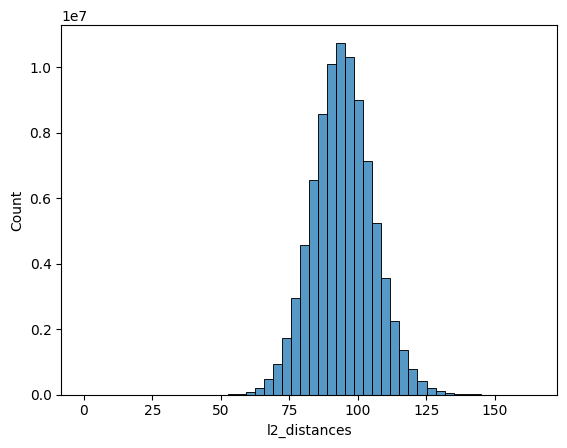

In [23]:
# Distribution of inter-label l2 distances
sns.histplot(data = inter_l2_df, x = 'l2_distances', stat = 'count', bins = 50);

In [24]:
# Loading cosine distances from batch csvs
inter_cos_df = get_unbatched_frame(distances_stem, 'cos')

In [25]:
# Descriptive statistics for inter-label cosine distances
inter_cos_df.describe()

,cosine_distances
count,8.730727e+07
mean,5.748289e-01
std,9.828222e-02
min,-1.192093e-07
25%,5.094723e-01
50%,5.782969e-01
75%,6.438360e-01
max,9.307189e-01


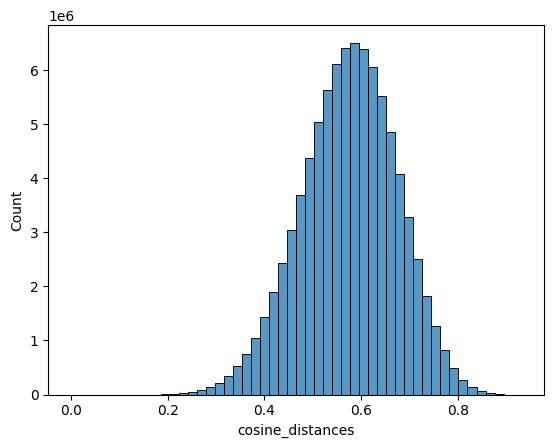

In [26]:
# Distribution of inter-label cosine distances
sns.histplot(data = inter_cos_df, x = 'cosine_distances', stat = 'count', bins = 50);

# Other Testing

In [ ]:
image1_path = './data/raw/test/Abdullah_Gul_0006.jpg'
image2_path = './data/raw/test/Abdullah_Gul_0005.jpg'
image3_path = './data/raw/test/Adrien_Brody_0005.jpg'

In [ ]:
prep1 = ImagePreprocessor(image1_path)
prep2 = ImagePreprocessor(image2_path)
prep3 = ImagePreprocessor(image3_path)

In [ ]:
prep1.set_vectorizer(vectorizer)
prep2.set_vectorizer(vectorizer)
prep3.set_vectorizer(vectorizer)

In [ ]:
prep1.preprocess_image(pad = True)
prep2.preprocess_image(pad = True)
prep3.preprocess_image(pad = True)

In [ ]:
prep1.vectorize()
prep2.vectorize()
prep3.vectorize()

In [ ]:
vector1 = prep1.get_vector()
vector2 = prep2.get_vector()
vector3 = prep3.get_vector()

In [ ]:
dist_v1v2 = calculation.l2_distance(vector1, vector2)
dist_v1v3 = calculation.l2_distance(vector1, vector3)
dist_v2v3 = calculation.l2_distance(vector2, vector3)

In [ ]:
dist_v1v2, dist_v1v3, dist_v2v3

In [ ]:
distcos_v1v2 = calculation.cosine_distance(vector1, vector2)
distcos_v1v3 = calculation.cosine_distance(vector1, vector3)
distcos_v2v3 = calculation.cosine_distance(vector2, vector3)

In [ ]:
distcos_v1v2, distcos_v1v3, distcos_v2v3

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15, 10))

ax[0].imshow(prep1.get_image());
ax[1].imshow(prep2.get_image());
ax[2].imshow(prep3.get_image());

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15, 10))

ax[0].imshow(prep1.get_resized_image());
ax[1].imshow(prep2.get_resized_image());
ax[2].imshow(prep3.get_resized_image());